In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion, quaternion2euler
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import io

In [3]:
cmap=plt.get_cmap('tab10')

In [4]:
TRAIN_COLOR = cmap(2)
VAL_COLOR = cmap(1)
TEST_COLOR_LOR = cmap(0)
TEST_COLOR_EOR = cmap(3)

In [5]:
ROOT_DIR = ".."
NUM_PROJECTIONS = 5000
DATA_DIR = "../data/publication_plots_data"

In [6]:
color_cvg1 = u'#1f77b4'
color_cvg2 = u'#ff7f0e'  #u'#2ca02c'

---

# Sampling

In [7]:
tick_size = 18
label_size = 22
legend_size = 20

In [8]:
data = np.load("../data/publication_plots_data/uniforms2_quaternions_angles_dQ.npz")
q_true1, angles_true1, dQ1 = data['arr_0'], data['arr_1'], data['arr_2']

data = np.load("../data/publication_plots_data/uniformEuler_quaternions_angles_dQ.npz")
q_true2, angles_true2, dQ2 = data['arr_0'], data['arr_1'], data['arr_2']

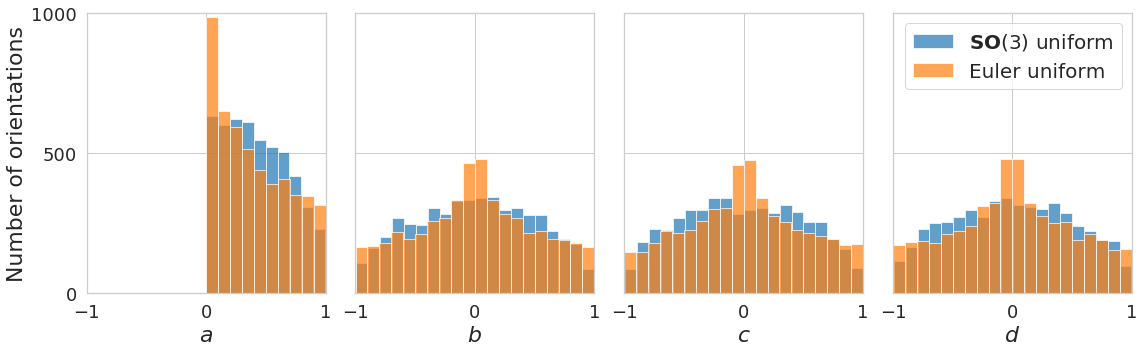

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5), sharey=True)
#quaternion_color = "lightcoral"
#gs1 = gridspec.GridSpec(4, 13)
#gs1.update(wspace=0.025, hspace=0.05) 
#axs = list(map(lambda i: plt.subplot(gs1[i]), range(4)))
plt.axis('on')
#plt.title("Quaternion: $q = a + b\mathbf{i} + c\mathbf{j} + d\mathbf{k}$", loc='center', fontsize=label_size)
alpha=0.7
bins=20
axs[0].hist(q_true1[:,3], bins=bins//2, alpha=alpha, color=color_cvg1)
axs[0].hist(q_true2[:,3], bins=bins//2, alpha=alpha, color=color_cvg2)
axs[0].set_xlabel("$a$", fontsize=label_size)
axs[0].set_ylabel("Number of orientations", fontsize=label_size)
axs[1].hist(q_true1[:,0], bins=bins, alpha=alpha, color=color_cvg1)
axs[1].hist(q_true2[:,0], bins=bins, alpha=alpha, color=color_cvg2)
axs[1].set_xlabel("$b$", fontsize=label_size)
axs[2].hist(q_true1[:,1], bins=bins, alpha=alpha, color=color_cvg1)
axs[2].hist(q_true2[:,1], bins=bins, alpha=alpha, color=color_cvg2)
axs[2].set_xlabel("$c$", fontsize=label_size)
axs[3].hist(q_true1[:,2], bins=bins, alpha=alpha, label=r"$\mathbf{SO}(3)$ uniform", color=color_cvg1)
axs[3].hist(q_true2[:,2], bins=bins, alpha=alpha, label="Euler uniform", color=color_cvg2)
axs[3].set_xlabel("$d$", fontsize=label_size)

axs[0].set_ylim(0,1000)
axs[0].set_xlim(-1,1)
axs[1].set_xlim(-1,1)
axs[2].set_xlim(-1,1)
axs[3].set_xlim(-1,1)
axs[0].yaxis.set_major_locator(plt.MaxNLocator(2))
axs[0].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
axs[1].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
axs[2].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
axs[3].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))

axs[0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[2].tick_params(axis='both', which='major', labelsize=tick_size)
axs[3].tick_params(axis='both', which='major', labelsize=tick_size)

plt.legend(fontsize=legend_size)
plt.subplots_adjust(wspace=0.001)
plt.tight_layout()
plt.savefig("pdfs/uniform_quaternions_vs_angles_q.pdf", pad_inches=1)
plt.show();

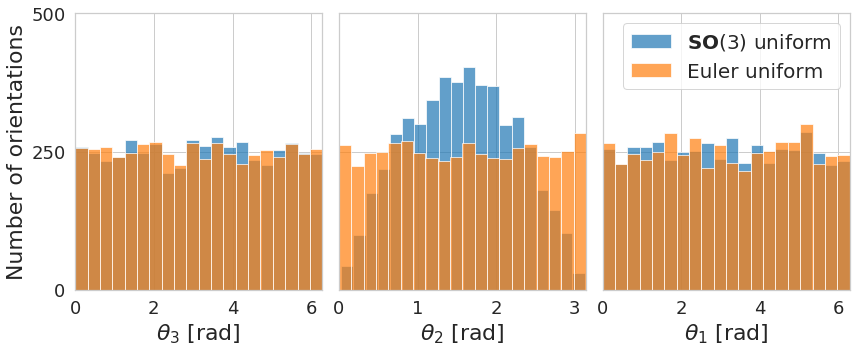

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
#gs1 = gridspec.GridSpec(4, 13)
#gs1.update(wspace=0.025, hspace=0.05) 
#axs = list(map(lambda i: plt.subplot(gs1[i]), range(4)))
plt.axis('on')
#plt.title(r"Euler angles: $\mathbf{\theta} = (\theta_3, \theta_2, \theta_1)$", loc='center')
#angles_color = "darkseagreen"
alpha=0.7
bins=20
axs[0].hist(angles_true1[:,0]%(2*np.pi), bins=bins, alpha=alpha, color=color_cvg1)
axs[0].hist(angles_true2[:,0]%(2*np.pi), bins=bins, alpha=alpha, color=color_cvg2)
axs[0].set_xlabel(r"$\theta_3$ [rad]", fontsize=label_size)
axs[0].set_ylabel("Number of orientations", fontsize=label_size)
axs[1].hist(angles_true1[:,1], bins=bins, alpha=alpha, color=color_cvg1)
axs[1].hist(angles_true2[:,1], bins=bins, alpha=alpha, color=color_cvg2)
axs[1].set_xlabel(r"$\theta_2$ [rad]", fontsize=label_size)
axs[2].hist(angles_true1[:,2]%(2*np.pi), bins=bins, alpha=alpha, label=r"$\mathbf{SO}(3)$ uniform", color=color_cvg1)
axs[2].hist(angles_true2[:,2]%(2*np.pi), bins=bins, alpha=alpha, label="Euler uniform", color=color_cvg2)
axs[2].set_xlabel(r"$\theta_1$ [rad]", fontsize=label_size)

axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,np.pi)
axs[2].set_xlim(0,2*np.pi)
axs[0].set_ylim(0,500)
axs[0].yaxis.set_major_locator(plt.MaxNLocator(2))
#axs[0].xaxis.set_major_locator(plt.MaxNLocator(steps=[3]))
axs[1].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
#axs[2].xaxis.set_major_locator(plt.MaxNLocator(steps=[2]))


axs[0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[2].tick_params(axis='both', which='major', labelsize=tick_size)

plt.legend(fontsize=legend_size)
plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
plt.savefig("pdfs/uniform_quaternions_vs_angles_ang.pdf", pad_inches=1)
plt.show();

In [11]:
from cryoem.rotation_matrices import RotationMatrix
from scipy.spatial.transform import Rotation as R
import ipyvolume as ipv
from matplotlib.colors import ListedColormap
from matplotlib import cm

In [12]:
def plot_detector_pixels(angles, projections=None, d_p=None, point_size=2, color=None):
    if projections is None:
        angle_ref = angles[0]
        distances = d_q(euler2quaternion(angle_ref), euler2quaternion(angles)).numpy() #[]
    else:
        projection_ref = projections[0]
        print(projection_ref.shape)
        distances = d_p(np.broadcast_to(projection_ref, (len(projections), *projection_ref.shape[-2:])), projections).flatten() #[]
    cmap = plt.cm.get_cmap('viridis', 3)

    colors = list(map(lambda x: cmap(x), distances))

    colormap = cm.coolwarm
    dist_min = 0
    dist_max = np.pi
    znorm = distances - dist_min #distances.min()
    znorm /= (dist_max - dist_min) #znorm.ptp()
    #znorm.min(), znorm.max()
    colorm = colormap(znorm)
    
    # NOTE: used
    ipv.clear()

    if isinstance(angles[0], tf.Variable):
        angles = np.array([a.numpy() for a in angles])

    arr = RotationMatrix(angles)

    ipv.figure(width=500, height=500)
    
    if color is None:
        color = colorm[...,:3]
        s = ipv.scatter(arr[0:1, 0], arr[0:1, 1], arr[0:1, 2],
                marker="sphere", color="black", size=5)

    s = ipv.scatter(arr[:, 0], arr[:, 1], arr[:, 2],
                marker="sphere", color=color, size=point_size)
    
    ipv.xlim(-1, 1)
    ipv.ylim(-1, 1)
    ipv.zlim(-1, 1)
    ipv.show()

In [13]:
plot_detector_pixels(angles_true1, point_size=1.5, color=color_cvg1)

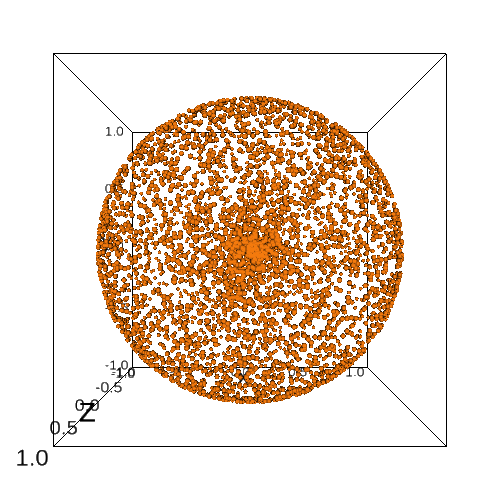

In [14]:
plot_detector_pixels(angles_true2, point_size=1.5, color=color_cvg2)

In [16]:
ipv.screenshot()

Output()

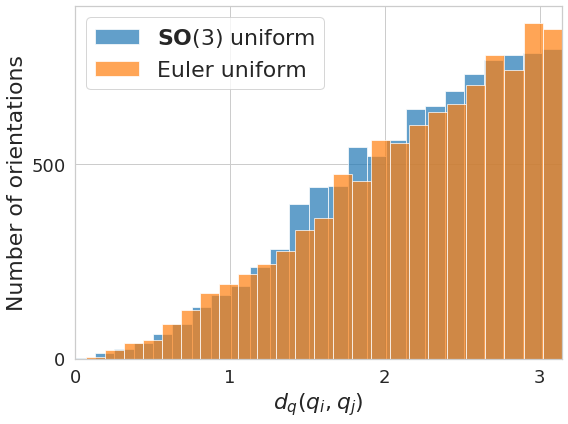

In [17]:
fig, ax = plt.subplots(figsize=(8,6));
alpha=0.7
bins=25
ax.hist(dQ1, bins=bins, alpha=alpha, label=r"$\mathbf{SO}(3)$ uniform", color=color_cvg1);
ax.hist(dQ2, bins=bins, alpha=alpha, label="Euler uniform", color=color_cvg2);
ax.set_xlim(0, np.pi)
#ax.set_ylim(0, 1000)
ax.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax.set_ylabel("Number of orientations", fontsize=label_size)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(2))
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.legend(fontsize=label_size, loc=0)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.tight_layout()
plt.savefig("pdfs/dQ_5j0n_uniform_quaternions_vs_angles.pdf", pad_inches=1)
plt.show();

In [19]:
DATA_DIR

'../data/publication_plots_data'

In [67]:
tick_size=20
label_size=26

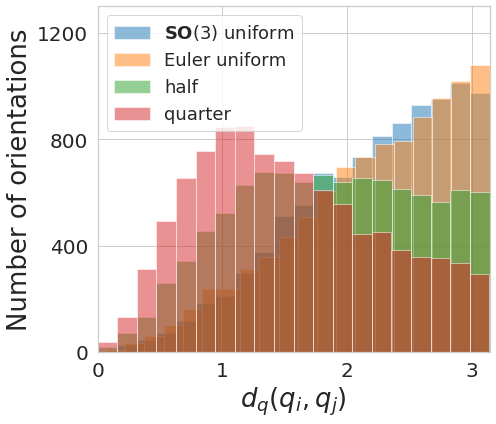

In [68]:
color_cvg1 = u'#1f77b4'
color_cvg2 = u'#ff7f0e'
color_cvg3 = u'#2ca02c'
color_cvg4 = u'#d62728'

data = np.load("../data/publication_plots_data/uniforms2_quaternions_angles_dQ.npz")
q_true1, angles_true1, dQ1 = data['arr_0'], data['arr_1'], data['arr_2']

data = np.load("../data/publication_plots_data/uniformEuler_quaternions_angles_dQ.npz")
q_true2, angles_true2, dQ2 = data['arr_0'], data['arr_1'], data['arr_2']

PROTEIN="5j0n"
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"
data = h5py.File(os.path.join(DATA_DIR, projections_filename), 'r')
angles_true1 = data['Angles']

PROTEIN="5a1a"
projections_filename = f"{PROTEIN}_uniform_ProjectionsAngles_ProjNber5000_AngCoverage1.0,0.4,1.0_AngShift0.0,0.0,0.0.h5"
data = h5py.File(os.path.join(DATA_DIR, projections_filename), 'r')
angles_true2 = data['Angles']

idx1 = list(np.random.choice(range(5000), size=10000))
idx2 = list(np.random.choice(range(5000), size=10000))
q1_true1 = euler2quaternion([angles_true1[i] for i in idx1])
q2_true1 = euler2quaternion([angles_true1[i] for i in idx2])
dQ3 = d_q(q1_true1, q2_true1).numpy()
q1_true2 = euler2quaternion([angles_true2[i] for i in idx1])
q2_true2 = euler2quaternion([angles_true2[i] for i in idx2])
dQ4 = d_q(q1_true2, q2_true2).numpy()



#####
fig, ax = plt.subplots(figsize=(7,6));
ax.hist(dQ1,bins=20, alpha=0.5, label=r"$\mathbf{SO}(3)$ uniform", color=color_cvg1);  #
ax.hist(dQ2,bins=20, alpha=0.5, label="Euler uniform", color=color_cvg2);  #
ax.hist(dQ3,bins=20, alpha=0.5, label="half", color=color_cvg3);  #
ax.hist(dQ4,bins=20, alpha=0.5, label="quarter", color=color_cvg4);  #

ax.set_xlim(0, np.pi)
ax.set_ylim(0, 1300)
ax.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax.set_ylabel("Number of orientations", fontsize=label_size)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.legend(loc=2, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.tight_layout()
plt.savefig("pdfs/dQ_distribution_coverage.pdf", pad_inches=1)
plt.show();

In [66]:
plot_detector_pixels(angles_true1, point_size=1.5, color=color_cvg3)

In [52]:
plot_detector_pixels(angles_true2, point_size=1.5, color=color_cvg4)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6));
alpha=0.7
bins=25
ax.hist(dQ1, bins=bins, alpha=alpha, label=r"$\mathbf{SO}(3)$ uniform", color=color_cvg1);
ax.hist(dQ2, bins=bins, alpha=alpha, label="Euler uniform", color=color_cvg2);
ax.set_xlim(0, np.pi)
#ax.set_ylim(0, 1000)
ax.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax.set_ylabel("Number of orientations", fontsize=label_size)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(2))
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.legend(fontsize=label_size, loc=0)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.tight_layout()
plt.savefig("pdfs/dQ_distribution_coverage.pdf", pad_inches=1)
plt.show();

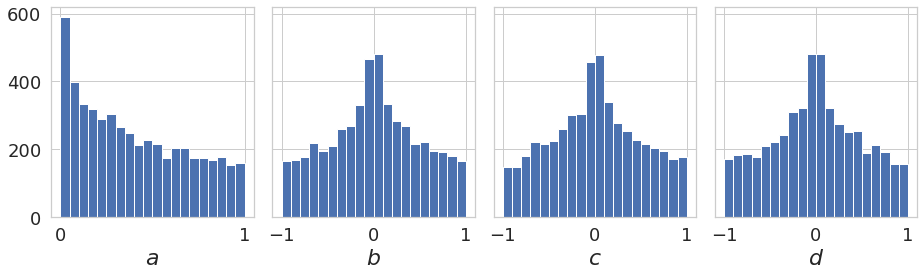

In [155]:
fig, axs = plt.subplots(1, 4, figsize=(13, 4), sharey=True)
#quaternion_color = "lightcoral"
#gs1 = gridspec.GridSpec(4, 13)
#gs1.update(wspace=0.025, hspace=0.05) 
#axs = list(map(lambda i: plt.subplot(gs1[i]), range(4)))
plt.axis('on')
#plt.title("Quaternion: $q = a + b\mathbf{i} + c\mathbf{j} + d\mathbf{k}$", loc='center', fontsize=label_size)

axs[0].hist(q_true[:,3], bins=20)
axs[0].set_xlabel("$a$", fontsize=label_size)
axs[1].hist(q_true[:,0], bins=20)
axs[1].set_xlabel("$b$", fontsize=label_size)
axs[2].hist(q_true[:,1], bins=20)
axs[2].set_xlabel("$c$", fontsize=label_size)
axs[3].hist(q_true[:,2], bins=20)
axs[3].set_xlabel("$d$", fontsize=label_size)

#axs[0].set_xlim(0,1)
axs[0].yaxis.set_major_locator(plt.MaxNLocator(4))
axs[0].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
axs[1].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
axs[2].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
axs[3].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))

axs[0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[2].tick_params(axis='both', which='major', labelsize=tick_size)
axs[3].tick_params(axis='both', which='major', labelsize=tick_size)

plt.subplots_adjust(wspace=0.1)
plt.tight_layout()
plt.savefig("pdfs/uniform_angles_q.pdf", pad_inches=1)
plt.show();

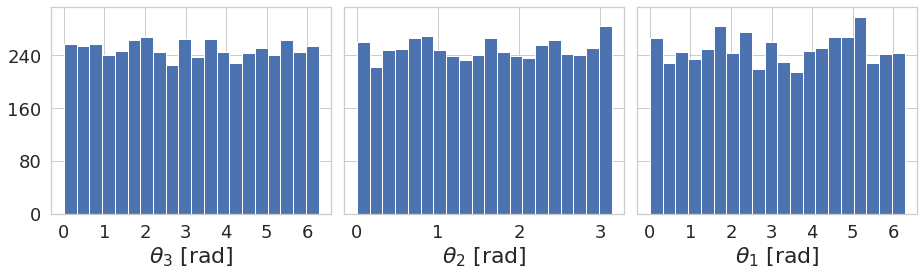

In [156]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
#gs1 = gridspec.GridSpec(4, 13)
#gs1.update(wspace=0.025, hspace=0.05) 
#axs = list(map(lambda i: plt.subplot(gs1[i]), range(4)))
plt.axis('on')
#plt.title(r"Euler angles: $\mathbf{\theta} = (\theta_3, \theta_2, \theta_1)$", loc='center')
#angles_color = "darkseagreen"

axs[0].hist(angles_true[:,0]%(2*np.pi), bins=20)
axs[0].set_xlabel(r"$\theta_3$ [rad]", fontsize=label_size)
axs[1].hist(angles_true[:,1], bins=20)
axs[1].set_xlabel(r"$\theta_2$ [rad]", fontsize=label_size)
axs[2].hist(angles_true[:,2]%(2*np.pi), bins=20)
axs[2].set_xlabel(r"$\theta_1$ [rad]", fontsize=label_size)

#axs[0].set_xlim(0,1)
axs[0].yaxis.set_major_locator(plt.MaxNLocator(4))
axs[0].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
axs[1].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
axs[2].xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))


axs[0].tick_params(axis='both', which='major', labelsize=tick_size)
axs[1].tick_params(axis='both', which='major', labelsize=tick_size)
axs[2].tick_params(axis='both', which='major', labelsize=tick_size)

plt.subplots_adjust(wspace=0.1)
plt.tight_layout()
plt.savefig("pdfs/uniform_angles_ang.pdf", pad_inches=1)
plt.show();

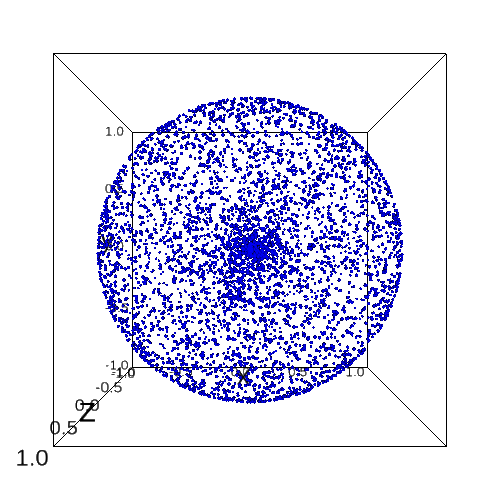

In [48]:
plot_detector_pixels(angles_true)

In [49]:
ipv.screenshot()

Output()

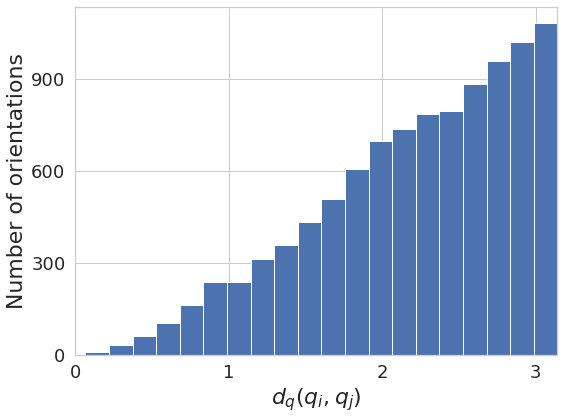

In [158]:
fig, ax = plt.subplots(figsize=(8,6));
ax.hist(dQ, bins=20);
ax.set_xlim(0, np.pi)
#ax.set_ylim(0, np.pi)
ax.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax.set_ylabel("Number of orientations", fontsize=label_size)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.tight_layout()
plt.savefig("pdfs/dQ_5j0n_uniform_angles.pdf", pad_inches=1)
plt.show();

---

In [72]:
from cryoem.plots import plot_detector_pixels, plot_rays
from cryoem.rotation_matrices import RotationMatrix

In [73]:
def plot_detector_pixels(angles, color="blue", img=None, img_size_scale=2):
    # NOTE: used
    ipv.clear()

    if isinstance(angles[0], tf.Variable):
        angles = np.array([a.numpy() for a in angles])

    arr = RotationMatrix(angles)

    ipv.figure(width=500, height=500)
    ipv.scatter(arr[:, 0], arr[:, 1], arr[:, 2],
                marker="sphere", color=color, size=1)
    if img is not None:
#         img = np.zeros((protein_image.shape[0], protein_image.shape[1], 3))
#         img[:, :, 0] = protein_image[:, :, 0]
#         img[:, :, 1] = protein_image[:, :, 1]
#         img[:, :, 2] = protein_image[:, :, 2]
#         print(img.shape)
        
        x = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[0])
        y = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[1])
        X, Y = np.meshgrid(x, y)
        x_shape = X.shape
        y_shape = Y.shape
        #X = X.flatten()
        #Y = Y.flatten()

        Z = np.zeros(X.shape)
        #vector = np.column_stack((X, Y, Z))
        #print(img.min())
        print(X.shape, Y.shape, Z.shape)
    
        ipv.plot_surface(X, Y, Z, color=img)
    
    ipv.xlim(-1, 1)
    ipv.ylim(-1, 1)
    ipv.zlim(-1, 1)
    ipv.view(45,135)
    ipv.show()


In [16]:
from matplotlib import image

image = image.imread("pdfs/5j0n_fullcvg_uniformS2_noise0_gt.png")

image.shape

(872, 1160, 3)

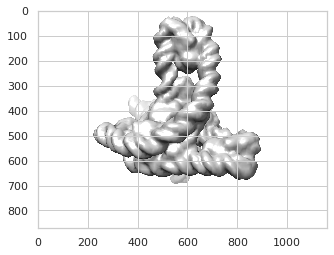

In [17]:
plt.imshow(image)

In [1]:
# plot_detector_pixels(angles_true1, img=None)

In [2]:
# ipv.screenshot()

In [3]:
# plot_detector_pixels(data['Angles'])

In [4]:
# ipv.screenshot()

In [5]:
 #plot_rays(data['Angles'], range(100))

---

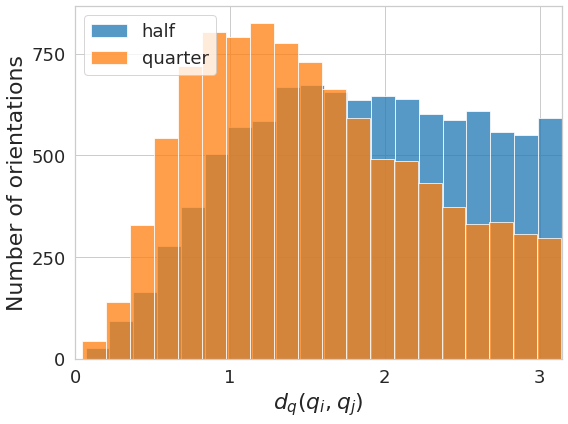

---

In [17]:
idx1 = list(np.random.choice(range(5000), size=10000))
idx2 = list(np.random.choice(range(5000), size=10000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dQ = d_q(q1_true, q2_true).numpy()

In [18]:
tick_size=18
label_size=22


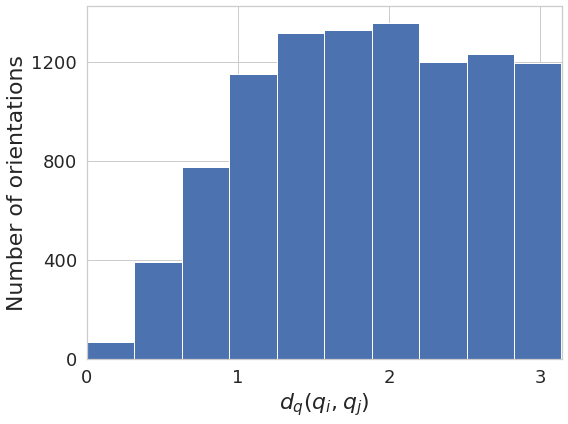

In [19]:
fig, ax = plt.subplots(figsize=(8,6));
ax.hist(dQ,bins=10);
ax.set_xlim(0, np.pi)
#ax.set_ylim(0, np.pi)
ax.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax.set_ylabel("Number of orientations", fontsize=label_size)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.tight_layout()
plt.savefig("pdfs/dQ_5a1a_quarter.pdf", pad_inches=1)
plt.show();

---

---

In [316]:
# projections = data['Projections']
# angles_true = np.array(data['Angles'])
# projections.shape, angles_true.shape

In [317]:
data = np.load(f"{DATA_DIR}/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [318]:
tick_size=15
label_size=15
labelpad = 20
fontsize = 20

---

In [320]:
# model = tf.keras.models.load_model(f"{DATA_DIR}/dimension4_de.h5")

In [ ]:
plot_model(model, to_file="pdfs/model_plot_4d.png", expand_nested=True, show_shapes=True, show_layer_names=True)

---

## Learning from Noisy Projections

In [326]:
df0_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

df5_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var5_train-tag-epoch_loss.csv")
df5_train["noise_variance"] = df5_train.apply(lambda x: 5, axis=1)
df5_train["dataset"] = df5_train.apply(lambda x: "train", axis=1)

df5_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var5_validation-tag-epoch_loss.csv")
df5_val["noise_variance"] = df5_val.apply(lambda x: 5, axis=1)
df5_val["dataset"] = df5_val.apply(lambda x: "validation", axis=1)

df10_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var10_train-tag-epoch_loss.csv")
df10_train["noise_variance"] = df10_train.apply(lambda x: 10, axis=1)
df10_train["dataset"] = df10_train.apply(lambda x: "train", axis=1)

df10_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var10_validation-tag-epoch_loss.csv")
df10_val["noise_variance"] = df10_val.apply(lambda x: 10, axis=1)
df10_val["dataset"] = df10_val.apply(lambda x: "validation", axis=1)

df14_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var14_train-tag-epoch_loss.csv")
df14_train["noise_variance"] = df14_train.apply(lambda x: 16, axis=1)
df14_train["dataset"] = df14_train.apply(lambda x: "train", axis=1)

df14_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var14_validation-tag-epoch_loss.csv")
df14_val["noise_variance"] = df14_val.apply(lambda x: 16, axis=1)
df14_val["dataset"] = df14_val.apply(lambda x: "validation", axis=1)

df20_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var20_train-tag-epoch_loss.csv")
df20_train["noise_variance"] = df20_train.apply(lambda x: 20, axis=1)
df20_train["dataset"] = df20_train.apply(lambda x: "train", axis=1)

df20_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var20_validation-tag-epoch_loss.csv")
df20_val["noise_variance"] = df20_val.apply(lambda x: 20, axis=1)
df20_val["dataset"] = df20_val.apply(lambda x: "validation", axis=1)

df25_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var25_train-tag-epoch_loss.csv")
df25_train["noise_variance"] = df25_train.apply(lambda x: 25, axis=1)
df25_train["dataset"] = df25_train.apply(lambda x: "train", axis=1)

df25_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var25_validation-tag-epoch_loss.csv")
df25_val["noise_variance"] = df25_val.apply(lambda x: 25, axis=1)
df25_val["dataset"] = df25_val.apply(lambda x: "validation", axis=1)

In [327]:
df = pd.concat([eval(f"df{i}_{d}") for i in [0, 5, 10, 14, 20, 25] for d in ["train", "val"]])

In [328]:
df.dataset.unique()

array(['train', 'validation'], dtype=object)

In [333]:
tick_size = 20
label_size = 27

textbox_size=14.3
small_text = 11
labelpad = 20
fontsize = 20

0
1
2
3
4
5


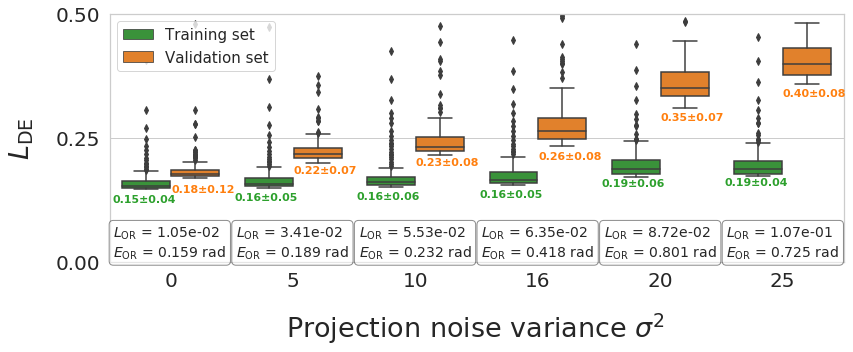

In [334]:
fig, ax = plt.subplots(figsize=(12,5))

df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

mapping = {0:0, 1:5, 2:10, 3:16, 4:20, 5:25}
color_map  = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}

box_plot = sns.boxplot(x="noise_variance", y="Value", hue="dataset_full", data=df, ax=ax, palette=color_map)
box_plot.tick_params(labelsize=tick_size)
ax.set_xlabel("Projection noise variance $\sigma^2$ ", fontsize=label_size, labelpad=labelpad);
ax.set_ylabel("$L_\mathrm{DE}$", fontsize=label_size, labelpad=labelpad);
ax.set_ylim(0, 0.5)
ax.legend(loc=2, fontsize=15)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

medians_na = df[df.dataset=='train'].groupby(['noise_variance'])['Value'].median()#.sort_values(ascending=False)
stds_na = df[df.dataset=='train'].groupby(['noise_variance'])['Value'].std()
vertical_offset_na = df[df.dataset=='train']['noise_variance'].median() * 0.004 # offset from median for display
horizontal_offset_na = 0.26

medians = df[df.dataset=='validation'].groupby(['noise_variance'])['Value'].median()#.sort_values(ascending=False)
stds = df[df.dataset=='validation'].groupby(['noise_variance'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['noise_variance'].median() * 0.0043 # offset from median for display
horizontal_offset = 0.22


props_red = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.0)
props_blue = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.0)
props = dict(boxstyle='round', edgecolor=TEST_COLOR_LOR, alpha=1.)

Es = [0.1594, 0.1893, 0.2315, 0.4184, 0.8012, 0.7251]
ARs = [1.05e-02, 3.41e-02, 5.53e-02, 6.35e-02, 8.72e-02, 1.07e-01]

for xtick in box_plot.get_xticks():
    margin = 0.019 if xtick<3 else 0.0 if xtick==3 else -0.01
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset+margin, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)
    print(xtick)
    
    
    ret_val = "$L_\mathrm{OR}$ = "+f"{ARs[xtick]:.2e}" + "\n$E_\mathrm{OR}$ = "+f"{Es[xtick]:.3f} rad"
    #box_plot.text(0.03+xtick*0.163, 0.3+xtick*0.08, "$L_{OR}$ = "+f"{ARs[xtick]:.2e}", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_blue)
    #box_plot.text(0.03+xtick*0.163, 0.37+xtick*0.08, "$E_{OR}$ = "+f"{Es[xtick]:.3f} rad", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_red)
    #box_plot.text(0.03+xtick*0.163, 0.37+xtick*0.08, "", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props)
    #r = plt.Rectangle((-0.37+xtick*0.98, 0.4+xtick*0.13), 0.96, 0.25, facecolor="black", alpha=0.1)
    #ax.add_patch(r)
    box_plot.text(0.005+xtick*0.167, 0.15, ret_val, #+xtick*0.09
              #ha="center",
              size=textbox_size,
              verticalalignment='top',
              transform=ax.transAxes,
                  fontsize=14,
              bbox=dict(boxstyle="round", fc="w", ec="k", alpha=0.5))

for xtick in box_plot.get_xticks():
    margin = 0.018 if xtick<6 else -0.01
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na+margin, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)
#ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.yaxis.set_major_locator(plt.MaxNLocator(2))
plt.tight_layout()
plt.savefig("pdfs/de_noises_nums.pdf")
plt.show()

---

## Learning from Noisy Projections

In [7]:
# tick_size = 20
# label_size = 28

# textbox_size=14.3
# small_text = 11
# labelpad = 20
# fontsize = 20

In [8]:
df4_train = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim4_de_train-tag-epoch_loss.csv")
df4_train["dim"] = df4_train.apply(lambda x: 4, axis=1)
df4_train["dataset"] = df4_train.apply(lambda x: "train", axis=1)

df4_val = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim4_de_validation-tag-epoch_loss.csv")
df4_val["dim"] = df4_val.apply(lambda x: 4, axis=1)
df4_val["dataset"] = df4_val.apply(lambda x: "validation", axis=1)

###

df8_train = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim8_de_train-tag-epoch_loss.csv")
df8_train["dim"] = df8_train.apply(lambda x: 8, axis=1)
df8_train["dataset"] = df8_train.apply(lambda x: "train", axis=1)

df8_val = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim8_de_validation-tag-epoch_loss.csv")
df8_val["dim"] = df8_val.apply(lambda x: 8, axis=1)
df8_val["dataset"] = df8_val.apply(lambda x: "validation", axis=1)

###

df16_train = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim16_de_train-tag-epoch_loss.csv")
df16_train["dim"] = df16_train.apply(lambda x: 16, axis=1)
df16_train["dataset"] = df16_train.apply(lambda x: "train", axis=1)

df16_val = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim16_de_validation-tag-epoch_loss.csv")
df16_val["dim"] = df16_val.apply(lambda x: 16, axis=1)
df16_val["dataset"] = df16_val.apply(lambda x: "validation", axis=1)

###

df32_train = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim32_de_train-tag-epoch_loss.csv")
df32_train["dim"] = df32_train.apply(lambda x: 32, axis=1)
df32_train["dataset"] = df32_train.apply(lambda x: "train", axis=1)

df32_val = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim32_de_validation-tag-epoch_loss.csv")
df32_val["dim"] = df32_val.apply(lambda x: 32, axis=1)
df32_val["dataset"] = df32_val.apply(lambda x: "validation", axis=1)

###

df64_train = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim64_de_train-tag-epoch_loss.csv")
df64_train["dim"] = df64_train.apply(lambda x: 64, axis=1)
df64_train["dataset"] = df64_train.apply(lambda x: "train", axis=1)

df64_val = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim64_de_validation-tag-epoch_loss.csv")
df64_val["dim"] = df64_val.apply(lambda x: 64, axis=1)
df64_val["dataset"] = df64_val.apply(lambda x: "validation", axis=1)

###

df128_train = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim128_de_train-tag-epoch_loss.csv")
df128_train["dim"] = df128_train.apply(lambda x: 128, axis=1)
df128_train["dataset"] = df128_train.apply(lambda x: "train", axis=1)

df128_val = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim128_de_validation-tag-epoch_loss.csv")
df128_val["dim"] = df128_val.apply(lambda x: 128, axis=1)
df128_val["dataset"] = df128_val.apply(lambda x: "validation", axis=1)

###

df256_train = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim256_de_train-tag-epoch_loss.csv")
df256_train["dim"] = df256_train.apply(lambda x: 256, axis=1)
df256_train["dataset"] = df256_train.apply(lambda x: "train", axis=1)

df256_val = pd.read_csv(f"{DATA_DIR}/run-5j0n_dim256_de_validation-tag-epoch_loss.csv")
df256_val["dim"] = df256_val.apply(lambda x: 256, axis=1)
df256_val["dataset"] = df256_val.apply(lambda x: "validation", axis=1)

###

df512_train = pd.read_csv(f"{DATA_DIR}/run_train_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
df512_train["dim"] = df512_train.apply(lambda x: 512, axis=1)
df512_train["dataset"] = df512_train.apply(lambda x: "train", axis=1)

df512_val = pd.read_csv(f"{DATA_DIR}/run_validation_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
df512_val["dim"] = df512_val.apply(lambda x: 512, axis=1)
df512_val["dataset"] = df512_val.apply(lambda x: "validation", axis=1)


In [9]:
vals = [4,8,16,32,128,256, 512]  #64
df = pd.concat([eval(f"df{i}_{d}") for i in vals for d in ["train", "val"]])

In [10]:
df.dataset.unique()

array(['train', 'validation'], dtype=object)

In [11]:
#df1 = pd.read_csv(f"{DATA_DIR}/dPdQ_euclidean_dist.csv")
data = np.load(f'{DATA_DIR}/dPdQ_data_4d_5j0n.npz')
dP  = data['arr_0']
dQ  = data['arr_1']
df1 = pd.DataFrame(data={"d_P":dP, "d_Q":dQ})

#df2 = pd.read_csv(f"{DATA_DIR}/dPdQ_euclidean_dist.csv")
data = np.load(f'{DATA_DIR}/dPdQ_data_32d_5j0n.npz')
dP  = data['arr_0']
dQ  = data['arr_1']
df2 = pd.DataFrame(data={"d_P":dP, "d_Q":dQ})

#df3 = pd.read_csv(f"{DATA_DIR}/dPdQ_euclidean_dist.csv")
data = np.load(f'{DATA_DIR}/dPdQ_d5j0n_fullcvg_uniformS2_noisy0.npz')
dP  = data['arr_0']
dQ  = data['arr_1']
df3 = pd.DataFrame(data={"d_P":dP, "d_Q":dQ})

In [12]:
# tick_size = 22
tick_size_bigger = 32
# label_size = 25
label_size_bigger = 45
legend_size=24

# textbox_size=17
# small_text = 15
tick_size = 20
label_size = 28

textbox_size=14.3
small_text = 20
labelpad = 20
fontsize = 20

/home/jelena/miniconda3/envs/protein_reconstruction/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


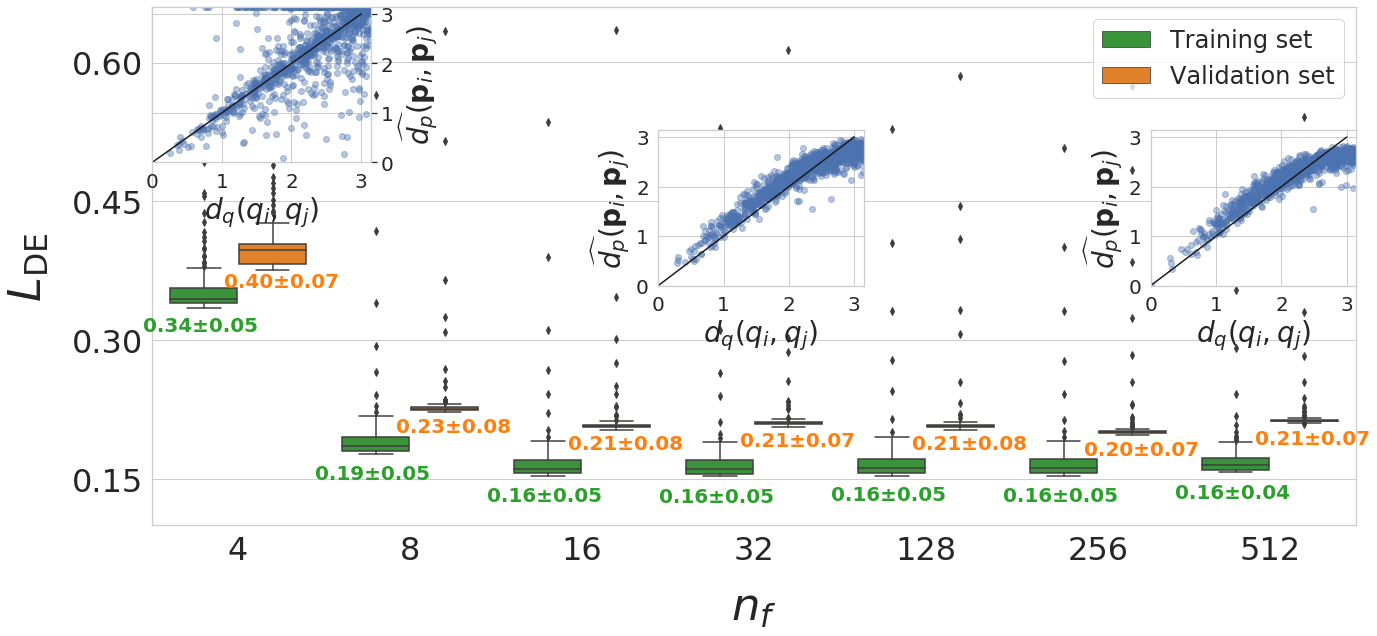

In [13]:
#fig, ax = plt.subplots(figsize=(14,7))
fig = plt.figure(figsize=(19, 9))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax = fig.add_axes([0.11, 0.17, 0.88, 0.8])
ax2 = fig.add_axes([0.11, 0.73, 0.16, 0.24], facecolor="white")
ax3 = fig.add_axes([0.48, 0.54, 0.15, 0.24], facecolor="white")
ax4 = fig.add_axes([0.84, 0.54, 0.15, 0.24], facecolor="white")

df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

mapping = dict(enumerate(vals))#{0:4, 1:5, 2:10, 3:16, 4:20, 5:25}
color_map  = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}

box_plot = sns.boxplot(x="dim", y="Value", hue="dataset_full", data=df, ax=ax, palette=color_map)
box_plot.tick_params(labelsize=tick_size_bigger)
ax.set_xlabel("$n_{f}$ ", fontsize=label_size_bigger, labelpad=labelpad);
ax.set_ylabel("$L_\mathrm{DE}$", fontsize=label_size_bigger, labelpad=labelpad);
ax.set_ylim(0.1, 0.66)
ax.legend(loc=1, fontsize=legend_size)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

medians_na = df[df.dataset=='train'].groupby(['dim'])['Value'].median()#.sort_values(ascending=False)
stds_na = df[df.dataset=='train'].groupby(['dim'])['Value'].std()
vertical_offset_na = df[df.dataset=='train']['dim'].median() * 0.0011 # offset from median for display
horizontal_offset_na = 0.25

medians = df[df.dataset=='validation'].groupby(['dim'])['Value'].median()#.sort_values(ascending=False)
stds = df[df.dataset=='validation'].groupby(['dim'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['dim'].median() * 0.0011 # offset from median for display
horizontal_offset = 0.22


props_red = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.0)
props_blue = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.0)
props = dict(boxstyle='round', edgecolor=TEST_COLOR_LOR, alpha=1.)

# Es = [0.1594, 0.1893, 0.2315, 0.4184, 0.8012, 0.7251]
# ARs = [1.05e-02, 3.41e-02, 5.53e-02, 6.35e-02, 8.72e-02, 1.07e-01]

for xtick in box_plot.get_xticks():
    if xtick==0:
        margin = -0.005
    elif xtick==1:
        margin=0.01
    elif xtick==2:
        margin=0.01
    elif xtick==3:
        margin=0.01
    elif xtick==4:
        margin=0.01
    elif xtick==5:
        margin=0.01
    elif xtick==6:
        margin=0.01
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset+margin, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)
    #print(xtick)
    
    #ret_val = "$L_\mathrm{OR}$ = "+f"{ARs[xtick]:.2e}" + "\n$E_\mathrm{OR}$ = "+f"{Es[xtick]:.3f} rad"
    #box_plot.text(0.03+xtick*0.163, 0.3+xtick*0.08, "$L_{OR}$ = "+f"{ARs[xtick]:.2e}", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_blue)
    #box_plot.text(0.03+xtick*0.163, 0.37+xtick*0.08, "$E_{OR}$ = "+f"{Es[xtick]:.3f} rad", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_red)
    #box_plot.text(0.03+xtick*0.163, 0.37+xtick*0.08, "", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props)
    #r = plt.Rectangle((-0.37+xtick*0.98, 0.4+xtick*0.13), 0.96, 0.25, facecolor="black", alpha=0.1)
    #ax.add_patch(r)
#     box_plot.text(0.005+xtick*0.167, 0.15, ret_val, #+xtick*0.09
#               #ha="center",
#               size=textbox_size,
#               verticalalignment='top',
#               transform=ax.transAxes,
#                   fontsize=14,
#               bbox=dict(boxstyle="round", fc="w", ec="k", alpha=0.5))

for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)

axs_num = 3
for ax_num in range(2, axs_num+2):
    axn = eval(f"ax{ax_num}")
    dfn = eval(f"df{ax_num-1}")
    if ax_num==2:
        ax2.yaxis.tick_right()
        ax2.yaxis.set_label_position("right")
    axn.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
    axn.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
    axn.set_xlim(0, np.pi)
    axn.set_ylim(0, np.pi)
    axn.scatter(dfn["d_Q"], dfn["d_P"], color="b", alpha=0.4, label="projection pair");  # "reg", "kde"
    #sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
    x = np.arange(0, np.pi);
    axn.plot(x, x, color="k")
    axn.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
    axn.set_ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
    axn.tick_params(axis='both', which='major', labelsize=tick_size)
    #axn.legend(loc=2, fontsize=legend_size)
    

#ax.xaxis.set_major_locator(plt.MaxNLocator(2))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig("pdfs/de_nf.pdf")
plt.show()

---

## Learning from Shifted Projections

In [321]:
tick_size = 24
label_size = 27

textbox_size=16
small_text = 12

In [322]:
df0_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["translation"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)
#df0_train = df0_train[df0_train.Step<100]

df0_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["translation"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)
#df0_val = df0_val[df0_val.Step<100]

df5_train = pd.read_csv(f"{DATA_DIR}/run-translation5_train-tag-epoch_loss.csv")
df5_train["translation"] = df5_train.apply(lambda x: 5, axis=1)
df5_train["dataset"] = df5_train.apply(lambda x: "train", axis=1)

df5_val = pd.read_csv(f"{DATA_DIR}/run-translation5_validation-tag-epoch_loss.csv")
df5_val["translation"] = df5_val.apply(lambda x: 5, axis=1)
df5_val["dataset"] = df5_val.apply(lambda x: "validation", axis=1)

df10_train = pd.read_csv(f"{DATA_DIR}/run-translation10_train-tag-epoch_loss.csv")
df10_train["translation"] = df10_train.apply(lambda x: 10, axis=1)
df10_train["dataset"] = df10_train.apply(lambda x: "train", axis=1)

df10_val = pd.read_csv(f"{DATA_DIR}/run-translation10_validation-tag-epoch_loss.csv")
df10_val["translation"] = df10_val.apply(lambda x: 10, axis=1)
df10_val["dataset"] = df10_val.apply(lambda x: "validation", axis=1)

df14_train = pd.read_csv(f"{DATA_DIR}/run-translation15_train-tag-epoch_loss.csv")
df14_train["translation"] = df14_train.apply(lambda x: 15, axis=1)
df14_train["dataset"] = df14_train.apply(lambda x: "train", axis=1)

df14_val = pd.read_csv(f"{DATA_DIR}/run-translation15_validation-tag-epoch_loss.csv")
df14_val["translation"] = df14_val.apply(lambda x: 15, axis=1)
df14_val["dataset"] = df14_val.apply(lambda x: "validation", axis=1)

df20_train = pd.read_csv(f"{DATA_DIR}/run-translation20_train-tag-epoch_loss.csv")
df20_train["translation"] = df20_train.apply(lambda x: 20, axis=1)
df20_train["dataset"] = df20_train.apply(lambda x: "train", axis=1)

df20_val = pd.read_csv(f"{DATA_DIR}/run-translation20_validation-tag-epoch_loss.csv")
df20_val["translation"] = df20_val.apply(lambda x: 20, axis=1)
df20_val["dataset"] = df20_val.apply(lambda x: "validation", axis=1)

In [323]:
df = pd.concat([eval(f"df{i}_{d}") for i in [0, 5, 10, 14, 20] for d in ["train", "val"]])

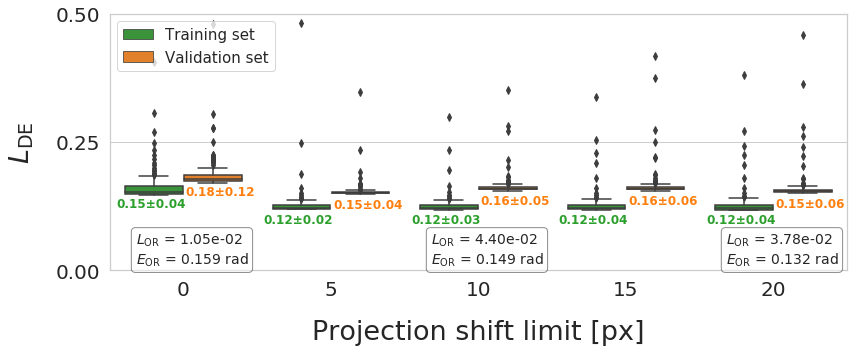

In [324]:
fig, ax = plt.subplots(figsize=(12,5))

df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

mapping = {0:0, 1:5, 2:10, 3:15, 4:20}
color_map  = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}

box_plot = sns.boxplot(x="translation", y="Value", hue="dataset_full", data=df, ax=ax, palette=color_map)
box_plot.tick_params(labelsize=20)
ax.set_xlabel("Projection shift limit [px]", fontsize=label_size, labelpad=labelpad);
ax.set_ylabel("$L_\mathrm{DE}$", fontsize=label_size, labelpad=labelpad);
ax.set_ylim(0, 0.5)
ax.legend(loc=2, fontsize=15)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

medians_na = df[df.dataset=='train'].groupby(['translation'])['Value'].median()#.sort_values(ascending=False)
stds_na = df[df.dataset=='train'].groupby(['translation'])['Value'].std()
vertical_offset_na = df[df.dataset=='train']['translation'].median() * 0.003 # offset from median for display
horizontal_offset_na = 0.25

medians = df[df.dataset=='validation'].groupby(['translation'])['Value'].median()#.sort_values(ascending=False)
stds = df[df.dataset=='validation'].groupby(['translation'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['translation'].median() * 0.003 # offset from median for display
horizontal_offset = 0.22

props_red = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
props_blue = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)

Es =  [0.1594,   0.0, 0.14933, 0.0, 0.13211]
ARs = [1.05e-02, 0.0, 0.044,   0.0, 0.0378]

for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)
    if xtick not in [1, 3]:
        #box_plot.text(0.05+xtick*0.195, 0.3+0.08, "$L_{OR}$ = "+f"{ARs[xtick]:.2e}", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_blue)
        #box_plot.text(0.05+xtick*0.195, 0.37+0.08, "$E_{OR}$ = "+f"{Es[xtick]:.3f} rad", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_red)
        ret_val = "$L_\mathrm{OR}$ = "+f"{ARs[xtick]:.2e}" + "\n$E_\mathrm{OR}$ = "+f"{Es[xtick]:.3f} rad"
        #box_plot.text(0.03+xtick*0.163, 0.3+xtick*0.08, "$L_{OR}$ = "+f"{ARs[xtick]:.2e}", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_blue)
        #box_plot.text(0.03+xtick*0.163, 0.37+xtick*0.08, "$E_{OR}$ = "+f"{Es[xtick]:.3f} rad", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props_red)
        #box_plot.text(0.03+xtick*0.163, 0.37+xtick*0.08, "", transform=ax.transAxes, fontsize=17, verticalalignment='top', bbox=props)
        #r = plt.Rectangle((-0.37+xtick*0.98, 0.4+xtick*0.13), 0.96, 0.25, facecolor="black", alpha=0.1)
        #ax.add_patch(r)
        box_plot.text(0.035+xtick*0.2, 0.15, ret_val,
                  #ha="center",
                  size=textbox_size,
                  verticalalignment='top',
                  transform=ax.transAxes,
                      fontsize=14,
                  bbox=dict(boxstyle="round", fc="w", ec="k", alpha=0.5))

for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)
ax.yaxis.set_major_locator(plt.MaxNLocator(2))
plt.tight_layout()
plt.savefig("pdfs/de_translation_nums.pdf")
plt.show()

---

# Euclidean vs. Geodesic vs. MLP

In [158]:
tick_size = 20
label_size = 25

textbox_size=16
small_text = 20
labelpad = 20

In [159]:
import pandas as pd

In [160]:
df=None

In [161]:
df_geo_train = pd.read_csv(f"{DATA_DIR}/run-cosine_distance_metric_train-tag-epoch_loss.csv")
df_geo_train["distance_metric"] = df_geo_train.apply(lambda x: "Cosine", axis=1)
df_geo_train["dataset"] = df_geo_train.apply(lambda x: "train", axis=1)

df_geo_val = pd.read_csv(f"{DATA_DIR}/run-cosine_distance_metric_validation-tag-epoch_loss.csv")
df_geo_val["distance_metric"] = df_geo_val.apply(lambda x: "Cosine", axis=1)
df_geo_val["dataset"] = df_geo_val.apply(lambda x: "validation", axis=1)


df_eucl_train = pd.read_csv(f"{DATA_DIR}/run-euclidean_distance_metric_train-tag-epoch_loss.csv")
df_eucl_train["distance_metric"] = df_eucl_train.apply(lambda x: "Euclidean", axis=1)
df_eucl_train["dataset"] = df_eucl_train.apply(lambda x: "train", axis=1)

df_eucl_val = pd.read_csv(f"{DATA_DIR}/run-euclidean_distance_metric_validation-tag-epoch_loss.csv")
df_eucl_val["distance_metric"] = df_eucl_val.apply(lambda x: "Euclidean", axis=1)
df_eucl_val["dataset"] = df_eucl_val.apply(lambda x: "validation", axis=1)


# df_mlp_train = pd.read_csv(f"{DATA_DIR}/run-mlp_distance_metric_train-tag-epoch_loss.csv")
# df_mlp_train["distance_metric"] = df_mlp_train.apply(lambda x: "MLP", axis=1)
# df_mlp_train["dataset"] = df_mlp_train.apply(lambda x: "train", axis=1)

# df_mlp_val = pd.read_csv(f"{DATA_DIR}/run-mlp_distance_metric_validation-tag-epoch_loss.csv")
# df_mlp_val["distance_metric"] = df_mlp_val.apply(lambda x: "MLP", axis=1)
# df_mlp_val["dataset"] = df_mlp_val.apply(lambda x: "validation", axis=1)

In [162]:
df = pd.concat([eval(f"df_{dm}_{ds}") for dm in ["geo", "eucl"] for ds in ["train", "val"]])

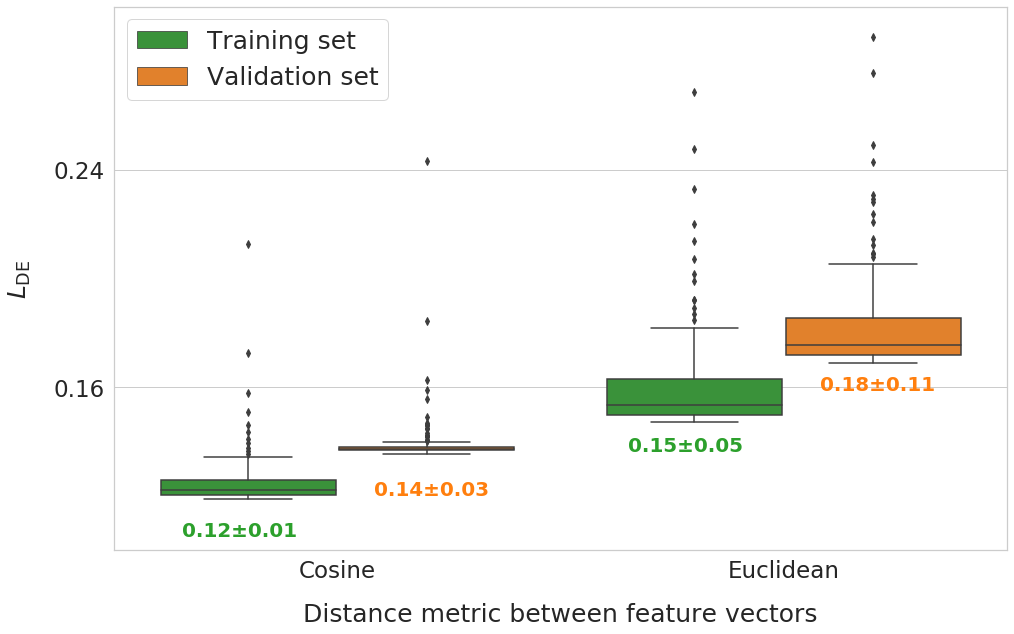

In [163]:
fig, ax = plt.subplots(figsize=(16,10))

df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

#mapping = {0:0, 1:5, 2:10, 3:15, 4:20}
mapping = {0:"Cosine", 1:"Euclidean"}  #, 2:"MLP"

color_map  = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}


box_plot = sns.boxplot(x="distance_metric", y="Value", hue="dataset_full", data=df, ax=ax, palette=color_map)
box_plot.tick_params(labelsize=label_size-2)
ax.set_xlabel("Distance metric between feature vectors", fontsize=label_size, labelpad=labelpad);
ax.set_ylabel("$L_\mathrm{DE}$", fontsize=label_size, labelpad=labelpad);
ax.set_ylim(0.1, 0.3)
ax.legend(loc=2, fontsize=25)

medians_na = df[df.dataset=='train'].groupby(['distance_metric'])['Value'].median()#.sort_values(ascending=False)
stds_na = df[df.dataset=='train'].groupby(['distance_metric'])['Value'].std()
vertical_offset_na = df[df.dataset=='validation']['Value'].median() * 0.1 # offset from median for display
horizontal_offset_na = 0.21
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
medians = df[df.dataset=='validation'].groupby(['distance_metric'])['Value'].median()#.sort_values(ascending=False)
stds = df[df.dataset=='validation'].groupby(['distance_metric'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['Value'].median() * 0.1 # offset from median for display
horizontal_offset = 0.22
#print(medians)
for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)


for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)

In [164]:
tick_size = 18
label_size = 22
textbox_size=22

In [165]:
data = np.load(f"{DATA_DIR}/dPdQ_5a1a.npz")
dP, dQ = data['arr_0'], data['arr_1']

# Creating the dataframe for SNS plot
data = {"d_Q" : dQ,
        "d_P" : dP}
df1 = pd.DataFrame(data=data)


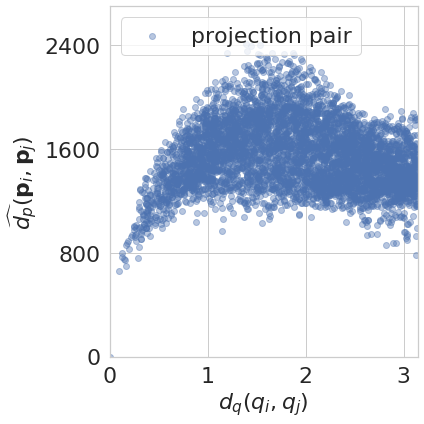

In [166]:
#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(df1["d_Q"], df1["d_P"], color="b", alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
#plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 2700)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=label_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

plt.tight_layout()
plt.savefig("pdfs/dPdQ_5a1a_euclidean.pdf", pad_inches=1)
plt.show();

In [167]:
tick_size = 18
label_size = 22
textbox_size=22

In [168]:
data = np.load(f"{DATA_DIR}/dPdQ_5j0n.npz")
dP, dQ = data['arr_0'], data['arr_1']

# Creating the dataframe for SNS plot
data = {"d_Q" : dQ,
        "d_P" : dP}
df1 = pd.DataFrame(data=data)


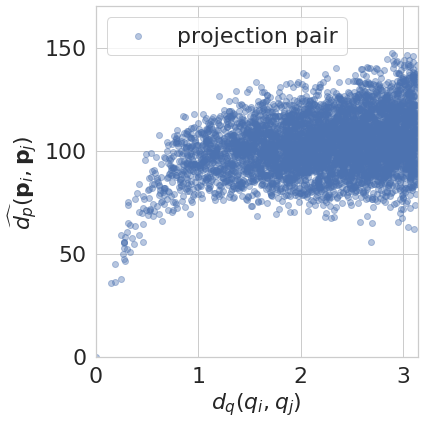

In [169]:
#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(df1["d_Q"], df1["d_P"], color="b", alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
#plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 170)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=label_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

plt.tight_layout()
plt.savefig("pdfs/dPdQ_5j0n_euclidean.pdf", pad_inches=1)
plt.show();

In [170]:
tick_size = 18
label_size = 22
textbox_size=22

In [171]:
data = np.load(f"{DATA_DIR}/dPdQ_5a1a_full.npz")
dP, dQ = data['arr_0'], data['arr_1']

# Creating the dataframe for SNS plot
data = {"d_Q" : dQ,
        "d_P" : dP}
df1 = pd.DataFrame(data=data)


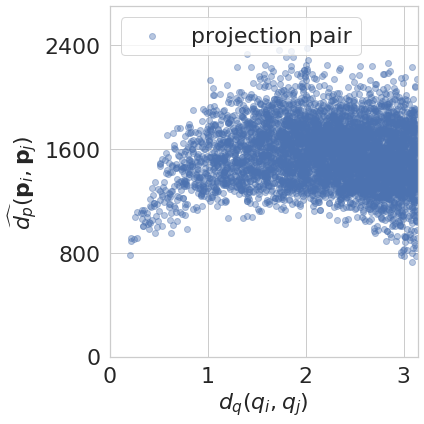

In [172]:
#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(df1["d_Q"], df1["d_P"], color="b", alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
#plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 2700)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=label_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

plt.tight_layout()
plt.savefig("pdfs/dPdQ_5a1a_full_euclidean.pdf", pad_inches=1)
plt.show();

---

---

---

In [173]:
tick_size = 18
label_size = 22
textbox_size=22

In [174]:
df1 = pd.read_csv(f"{DATA_DIR}/dPdQ_cosine_dist.csv")

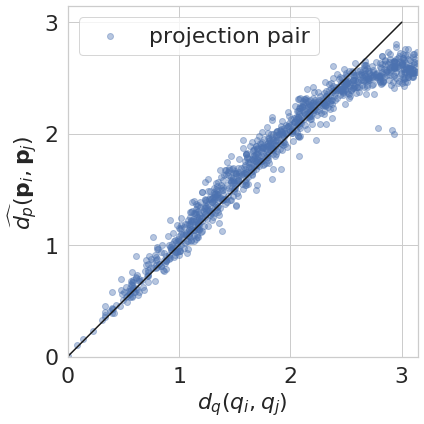

In [175]:
#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(df1["d_Q"], df1["d_P"], color="b", alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=label_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
#plt.savefig("pdfs/dPdQ_5a1a.pdf", pad_inches=1)
plt.show();

---

In [176]:
df2 = pd.read_csv(f"{DATA_DIR}/dPdQ_euclidean_dist.csv")

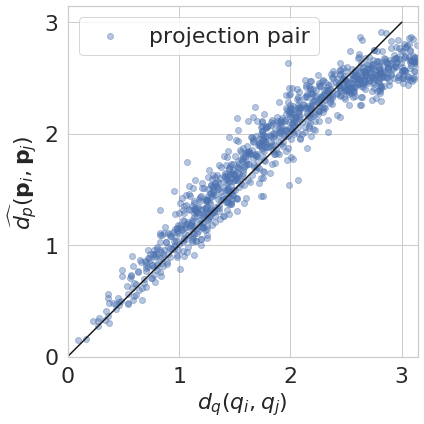

In [177]:
#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(df2["d_Q"], df2["d_P"], color="b", alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=label_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
#plt.savefig("pdfs/dPdQ_5a1a.pdf", pad_inches=1)
plt.show();

In [178]:
# tick_size = 22
# tick_size_bigger = 27
# label_size = 25
# label_size_bigger = 40
# legend_size=20

# #textbox_size=17
# #small_text = 15

In [183]:
# # tick_size = 22
# tick_size_bigger = 32
# # label_size = 25
# label_size_bigger = 45
# # legend_size=20

# # textbox_size=17
# # small_text = 15
# tick_size = 20
# label_size = 28

# textbox_size=14.3
# small_text = 20
# labelpad = 20
# fontsize = 20

In [186]:
legend_size = 15  #18
legend_size_big = 20
tick_size_bigger = 32
tick_size = 22
label_size_bigger = 45
label_size = 22

textbox_size=22
small_text = 22

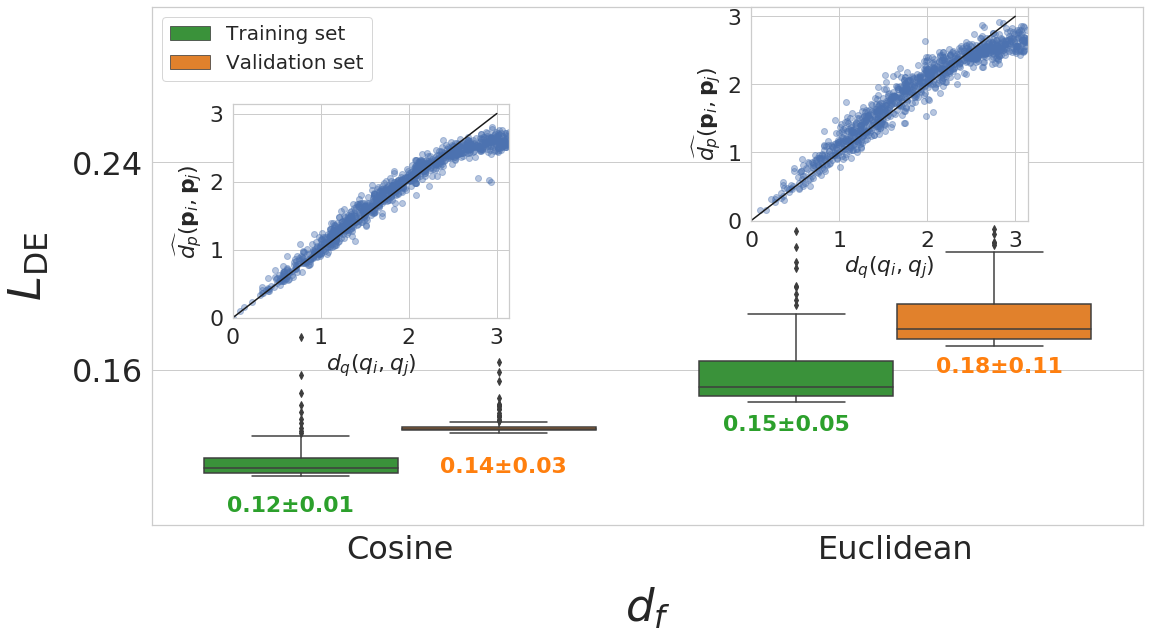

In [192]:
#fig, ax = plt.subplots(figsize=(16,10))
fig = plt.figure(figsize=(16, 9))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.13, 0.17, 0.86, 0.8])
ax2 = fig.add_axes([0.2, 0.49, 0.24, 0.33], facecolor="white")
ax3 = fig.add_axes([0.65, 0.64, 0.24, 0.33], facecolor="white")
axs_num = 2
df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

#mapping = {0:0, 1:5, 2:10, 3:15, 4:20}
mapping = {0:"Cosine", 1:"Euclidean"}  #, 2:"MLP"

color_map  = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}


box_plot = sns.boxplot(x="distance_metric", y="Value", hue="dataset_full", data=df, ax=ax1, palette=color_map)
box_plot.tick_params(labelsize=tick_size_bigger)
ax1.set_xlabel("$d_{f}$", fontsize=label_size_bigger, labelpad=labelpad);
ax1.set_ylabel("$L_\mathrm{DE}$", fontsize=label_size_bigger, labelpad=labelpad);
ax1.set_ylim(0.1, 0.3)
ax1.legend(loc=2, fontsize=legend_size_big)

medians_na = df[df.dataset=='train'].groupby(['distance_metric'])['Value'].median()#.sort_values(ascending=False)
stds_na = df[df.dataset=='train'].groupby(['distance_metric'])['Value'].std()
vertical_offset_na = df[df.dataset=='validation']['Value'].median() * 0.1 # offset from median for display
horizontal_offset_na = 0.21
ax1.yaxis.set_major_locator(plt.MaxNLocator(3))
medians = df[df.dataset=='validation'].groupby(['distance_metric'])['Value'].median()#.sort_values(ascending=False)
stds = df[df.dataset=='validation'].groupby(['distance_metric'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['Value'].median() * 0.1 # offset from median for display
horizontal_offset = 0.22
#print(medians)
for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)


for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)


for ax_num in range(2, axs_num+2):
    axn = eval(f"ax{ax_num}")
    dfn = eval(f"df{ax_num-1}")
    axn.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
    axn.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
    axn.set_xlim(0, np.pi)
    axn.set_ylim(0, np.pi)
    axn.scatter(dfn["d_Q"], dfn["d_P"], color="b", alpha=0.4, label="projection pair");  # "reg", "kde"
    #sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
    x = np.arange(0, np.pi);
    axn.plot(x, x, color="k")
    axn.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
    axn.set_ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
    axn.tick_params(axis='both', which='major', labelsize=tick_size)
    #axn.legend(loc=2, fontsize=legend_size)


plt.savefig("pdfs/dPdQ_feat_distances.pdf", pad_inches=1)

In [181]:
labelpad

20

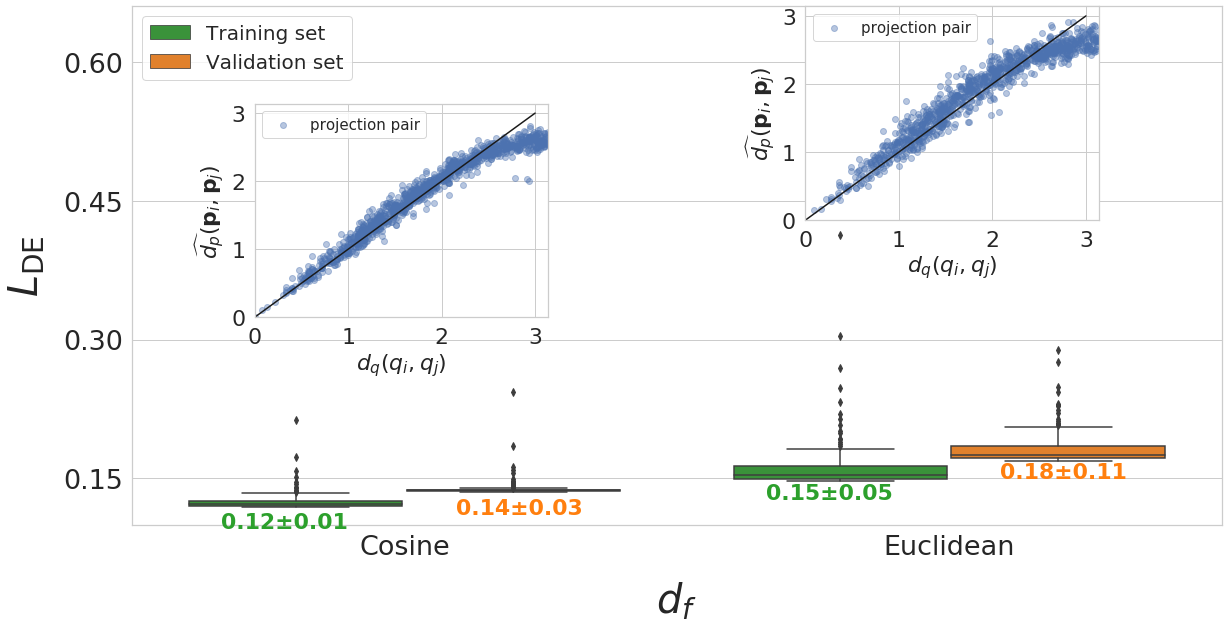

In [60]:
#fig, ax = plt.subplots(figsize=(16,10))
fig = plt.figure(figsize=(17, 9))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.1, 0.17, 0.89, 0.8])
ax2 = fig.add_axes([0.2, 0.49, 0.24, 0.33], facecolor="white")
ax3 = fig.add_axes([0.65, 0.64, 0.24, 0.33], facecolor="white")
axs_num = 2
df["dataset_full"] = df.dataset.apply(lambda x: "Training set" if x=="train" else "Validation set" if x=="validation" else x)

#mapping = {0:0, 1:5, 2:10, 3:15, 4:20}
mapping = {0:"Cosine", 1:"Euclidean"}  #, 2:"MLP"

color_map  = {"Training set": TRAIN_COLOR, "Validation set": VAL_COLOR, "": "k"}


box_plot = sns.boxplot(x="distance_metric", y="Value", hue="dataset_full", data=df, ax=ax1, palette=color_map)
box_plot.tick_params(labelsize=tick_size_bigger)
ax1.set_xlabel("$d_{f}$", fontsize=label_size_bigger, labelpad=labelpad);
ax1.set_ylabel("$L_\mathrm{DE}$", fontsize=label_size_bigger, labelpad=15);
ax1.set_ylim(0.1, 0.66)
ax1.legend(loc=2, fontsize=legend_size_big)

medians_na = df[df.dataset=='train'].groupby(['distance_metric'])['Value'].median()#.sort_values(ascending=False)
stds_na = df[df.dataset=='train'].groupby(['distance_metric'])['Value'].std()
vertical_offset_na = df[df.dataset=='validation']['Value'].median() * 0.15 # offset from median for display
horizontal_offset_na = 0.21
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
medians = df[df.dataset=='validation'].groupby(['distance_metric'])['Value'].median()#.sort_values(ascending=False)
stds = df[df.dataset=='validation'].groupby(['distance_metric'])['Value'].std()
vertical_offset = df[df.dataset=='validation']['Value'].median() * 0.15 # offset from median for display
horizontal_offset = 0.22
#print(medians)
for xtick in box_plot.get_xticks():
    box_plot.text(xtick+horizontal_offset_na, 
                  medians[mapping[xtick]] - vertical_offset, 
                  f"{medians[mapping[xtick]]:.2f}±{stds_na[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=VAL_COLOR)


for xtick in box_plot.get_xticks():
    box_plot.text(xtick-horizontal_offset, 
                  medians_na[mapping[xtick]] - vertical_offset_na, 
                  f"{medians_na[mapping[xtick]]:.2f}±{stds[mapping[xtick]]:.2f}", 
                  horizontalalignment='center', 
                  size='x-small', weight='semibold', fontsize=small_text, color=TRAIN_COLOR)


for ax_num in range(2, axs_num+2):
    axn = eval(f"ax{ax_num}")
    dfn = eval(f"df{ax_num-1}")
    axn.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
    axn.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
    axn.set_xlim(0, np.pi)
    axn.set_ylim(0, np.pi)
    axn.scatter(dfn["d_Q"], dfn["d_P"], color="b", alpha=0.4, label="projection pair");  # "reg", "kde"
    #sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
    x = np.arange(0, np.pi);
    axn.plot(x, x, color="k")
    axn.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
    axn.set_ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
    axn.tick_params(axis='both', which='major', labelsize=tick_size)
    axn.legend(loc=2, fontsize=legend_size)


plt.savefig("pdfs/dPdQ_feat_distances.pdf", pad_inches=1)

---

## $L_{OR}$ and $E_{OR}$ w.r.t. Variance of Noise in `5j0n`

In [353]:
labelpad = 6
label_size = 30
tick_size=20

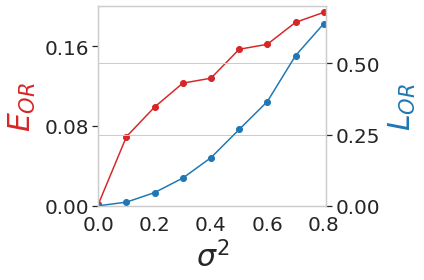

In [359]:
variances = [0.0, 
             0.1, 
             0.2, 
             0.3, 
             0.4, 
             0.5, 
             0.6, 
             0.7, 
             0.8
            ]
losses = np.array([9.26e-09, 
                   1.29e-02, 
                   4.65e-02, 
                   9.74e-02, 
                   1.69e-01, 
                   2.68e-01, 
                   3.66e-01, 
                   5.27e-01, 
                   6.39e-01
                  ])
# mean
#aa_losses = np.array([2.49e-03, 7.23e-02, 1.06e-01, 1.26e-01, 1.45e-01, 1.62e-01, 1.80e-01, 1.88e-01, 2.04e-1])
# median
aa_losses = np.array([1.47e-03, 
                      6.94e-02, 
                      9.91e-02, 
                      1.23e-01, 
                      1.28e-01, 
                      1.57e-01, 
                      1.62e-01, 
                      1.84e-01, 
                      1.94e-01
                     ])
#tick_size=15

#label_size = 20

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('$\sigma^2$', fontsize=label_size, labelpad=labelpad)
ax.plot(variances, aa_losses, marker="o", color=TEST_COLOR_EOR)
ax.set_ylabel('$E_{OR}$', color=TEST_COLOR_EOR, fontsize=label_size, labelpad=labelpad)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_ylim(0, 0.2)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid()
ax.set_xlim(0, 0.81)

ax2 = ax.twinx()
ax2.plot(variances, losses, marker="o", color=TEST_COLOR_LOR)
ax2.set_ylabel('$L_{OR}$', color=TEST_COLOR_LOR, fontsize=label_size, labelpad=labelpad)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.set_ylim(0, 0.7)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

plt.tight_layout()
plt.savefig("pdfs/5j0n_perfect_noisy_ar_aa.pdf")
plt.show()

## $L_{OR}$ and $E_{OR}$ w.r.t. Variance of Noise in `5a1a`

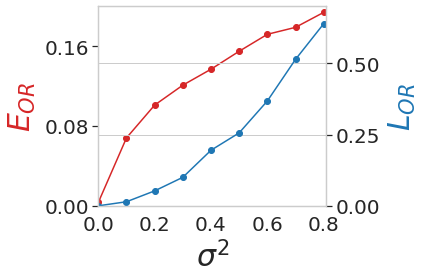

In [358]:

# losses
variances = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
losses = np.array([1.42e-08, 1.42e-02, 5.24e-02, 1.00e-01, 1.95e-01, 2.56e-01, 3.68e-01, 5.14e-01, 6.39e-01])
# mean
#aa_losses = np.array([2.49e-03, 7.23e-02, 1.06e-01, 1.26e-01, 1.45e-01, 1.62e-01, 1.80e-01, 1.88e-01, 2.04e-1])
# median
aa_losses = np.array([3.33e-03, 6.81e-02, 1.01e-01, 1.21e-01, 1.37e-01, 1.55e-01, 1.72e-01, 1.79e-01, 1.94e-01])

#tick_size=15
#labelpad = 20
#label_size = 20

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlabel('$\sigma^2$', fontsize=label_size, labelpad=labelpad)
ax.plot(variances, aa_losses, marker="o", color=TEST_COLOR_EOR)
ax.set_ylabel('$E_{OR}$', color=TEST_COLOR_EOR, fontsize=label_size, labelpad=labelpad)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_ylim(0, 0.2)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
ax.grid()
ax.set_xlim(0, 0.81)

ax2 = ax.twinx()
ax2.plot(variances, losses, marker="o", color=TEST_COLOR_LOR)
ax2.set_ylabel('$L_{OR}$', color=TEST_COLOR_LOR, fontsize=label_size, labelpad=labelpad)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.set_ylim(0, 0.7)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

plt.tight_layout()
plt.savefig("pdfs/5a1a_perfect_noisy_ar_aa.pdf")
plt.show()

---

## $\frac{d_p}{d_q}$ plot for the `5j0n`

In [22]:
# PROTEIN="5j0n"
# ROOT_DIR = "../.."
# NUM_PROJECTIONS = 5000

# # location of *.h5 files
# #data_dir = "/mnt/scratch/students/"

# # half coverage (AngCoverage=0.5)
# projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# # load structures
# data = h5py.File(os.path.join(DATA_DIR, projections_filename), 'r')

# print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
# print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

# projections = data['Projections']
# projections.shape

# angles_true = np.array(data['Angles'])
# angles_true.shape

In [23]:
# from skimage.transform import resize

# def rescale_image(image):
#     c = image.shape[-1]/117
#     image_resized = resize(image, (image.shape[0] // c, image.shape[1] // c), anti_aliasing=True)
#     return image_resized

In [24]:
# projections_new = []
# for p in projections:
#     projections_new.append(rescale_image(p))
# projections_new = np.array(projections_new)
# projections_new.shape

In [25]:
# def global_standardization(X):
#     """Does not have all the positive piels
#     Ref: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/""" 
#     print(f'Image shape: {X[0].shape}')
#     print(f'Data Type: {X[0].dtype}')
#     X = X.astype('float32')

#     print("***")
#     ## GLOBAL STANDARDIZATION
#     # calculate global mean and standard deviation
#     mean, std = X.mean(), X.std()
#     print(f'Mean: {mean:.3f} | Std: {std:.3f}')
#     print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
#     # global standardization of pixels
#     X = (X - mean) / std
#     # confirm it had the desired effect
#     mean, std = X.mean(), X.std()
#     print(f'Mean: {mean:.3f} | Std: {std:.3f}')
#     print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
    
#     return X


In [26]:
# X, y = np.array(projections_new, dtype=np.float32), np.array(angles_true, dtype=np.float32)

# X = global_standardization(X)

# channels = "gray"
# if channels == "rgb":
#     X = np.stack((X,)*3, axis=-1)
# elif channels == "gray":
#     X = X[:,:,:,np.newaxis]

In [27]:
# model_filename = f"{DATA_DIR}/noisy_var0.h5"

# # Recreate the exact same model, including its weights and the optimizer
# model = tf.keras.models.load_model(model_filename)

# # Show the model architecture
# model.summary()

In [28]:
# from cryoem.conversions import d_q, euler2quaternion


In [29]:
# def d_p(p1, p2):
#     p1 = tf.cast(p1, dtype=tf.float32)
#     p2 = tf.cast(p2, dtype=tf.float32)
#     return model.predict([p1, p2], batch_size=512)

In [30]:
# batch_size = 1024
# idx1 = list(np.random.choice(test_idx, size=batch_size))
# idx2 = list(np.random.choice(test_idx, size=batch_size))

# q1_true = euler2quaternion([angles_true[i] for i in idx1])
# q2_true = euler2quaternion([angles_true[i] for i in idx2])

# p1 = [X[i] for i in idx1]
# p2 = [X[i] for i in idx2]

# dP_values = d_p(p1, p2).T[0]
# dQ_values = d_q(q1_true, q2_true).numpy()

In [31]:
# dP_values

In [32]:
# dQ_values

In [33]:
# #plt.clf()
# # Creating the dataframe for SNS plot
# data = {"d_Q" : dQ_values, #tr_y.numpy(),
#         "d_P" : dP_values } #y_tr_pred.T[0]}
# df1 = pd.DataFrame(data=data)

In [34]:
# df1.head()

In [35]:
# df1.to_csv(f"{DATA_DIR}/dP_dQ_5j0n.csv", index=False)

In [274]:
tick_size = 18
label_size = 22
textbox_size=22

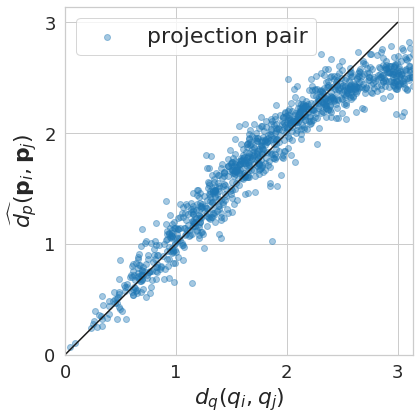

In [275]:
df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5j0n.csv")

# Creating the dataframe for SNS plot
# data = {"d_Q" : val_y.numpy(),
#         "d_P" : y_val_pred.T[0]}
# df2 = pd.DataFrame(data=data)

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(df1["d_Q"], df1["d_P"], color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5j0n.pdf", pad_inches=1)
plt.show();

---

In [151]:
tick_size = 18
label_size = 22
textbox_size=22

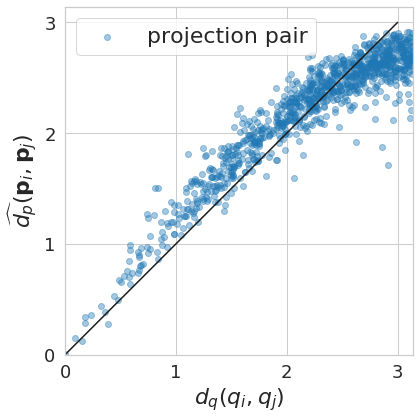

In [154]:
data = np.load(f"{DATA_DIR}/dPdQ_data_fullcoverage_5j0n.npz")
dP, dQ = data['arr_0'], data['arr_1']

# Creating the dataframe for SNS plot
data = {"d_Q" : dQ,
        "d_P" : dP}
df1 = pd.DataFrame(data=data)

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(df1["d_Q"], df1["d_P"], color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5j0n_fullcov.pdf", pad_inches=1)
plt.show();

---

## $\frac{d_p}{d_q}$ plot for the `5a1a`

In [37]:
# PROTEIN="5a1a"
# NUM_PROJECTIONS = 5000


# # half coverage (AngCoverage=0.5)
# projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.5_AngShift0.0,0.0,0.0.h5"

# # load structures
# data = h5py.File(os.path.join(DATA_DIR, projections_filename), 'r')

# print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
# print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

# projections = data['Projections']
# projections.shape

# angles_true = np.array(data['Angles'])
# angles_true.shape

# from skimage.transform import resize

# def rescale_image(image):
#     c = image.shape[-1]/117
#     image_resized = resize(image, (image.shape[0] // c, image.shape[1] // c), anti_aliasing=True)
#     return image_resized

# projections_new = []
# for p in projections:
#     projections_new.append(rescale_image(p))
# projections_new = np.array(projections_new)
# projections_new.shape

In [38]:
# def global_standardization(X):
#     """Does not have all the positive piels
#     Ref: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/""" 
#     print(f'Image shape: {X[0].shape}')
#     print(f'Data Type: {X[0].dtype}')
#     X = X.astype('float32')

#     print("***")
#     ## GLOBAL STANDARDIZATION
#     # calculate global mean and standard deviation
#     mean, std = X.mean(), X.std()
#     print(f'Mean: {mean:.3f} | Std: {std:.3f}')
#     print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
#     # global standardization of pixels
#     X = (X - mean) / std
#     # confirm it had the desired effect
#     mean, std = X.mean(), X.std()
#     print(f'Mean: {mean:.3f} | Std: {std:.3f}')
#     print(f'Min:  {X.min():.3f} | Max: {X.max():.3f}')
    
#     return X
# X, y = np.array(projections_new, dtype=np.float32), np.array(angles_true, dtype=np.float32)
# X = global_standardization(X)

# channels = "gray"
# if channels == "rgb":
#     X = np.stack((X,)*3, axis=-1)
# elif channels == "gray":
#     X = X[:,:,:,np.newaxis]
    
# model_filename = f"{DATA_DIR}/noisy_var0_5a1a.h5"

# # Recreate the exact same model, including its weights and the optimizer
# model = tf.keras.models.load_model(model_filename)

# # Show the model architecture
# model.summary()

In [39]:
# from cryoem.conversions import d_q, euler2quaternion
# from cryoem.plots import plot_dP_dQ

In [40]:
# def d_p(p1, p2):
#     p1 = tf.cast(p1, dtype=tf.float32)
#     p2 = tf.cast(p2, dtype=tf.float32)
#     return model.predict([p1, p2], batch_size=512)

In [41]:
# # 5:41 with 1024
# # 5:43     with 256
# batch_size = 1024
# idx1 = list(np.random.choice(test_idx, size=batch_size))
# idx2 = list(np.random.choice(test_idx, size=batch_size))

# q1_true = euler2quaternion([angles_true[i] for i in idx1])
# q2_true = euler2quaternion([angles_true[i] for i in idx2])

# p1 = [X[i] for i in idx1]
# p2 = [X[i] for i in idx2]

# dP_values = d_p(p1, p2).T[0]
# dQ_values = d_q(q1_true, q2_true).numpy()

# import pandas as pd

In [42]:
# #plt.clf()
# # Creating the dataframe for SNS plot
# data = {"d_Q" : dQ_values, #tr_y.numpy(),
#         "d_P" : dP_values } #y_tr_pred.T[0]}
# df1 = pd.DataFrame(data=data)

In [43]:
# df1.to_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv", index=False)

In [151]:
tick_size = 18
label_size = 22
textbox_size=22

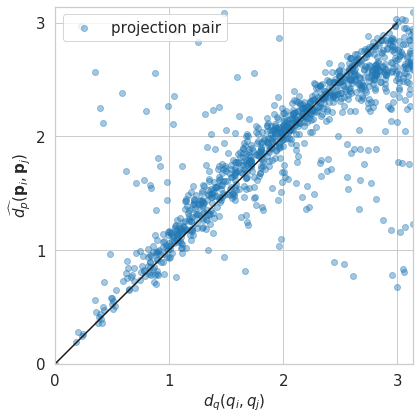

In [322]:
df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(df1["d_Q"], df1["d_P"], color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5a1a.pdf", pad_inches=1)
plt.show();

In [155]:
tick_size = 18
label_size = 22
textbox_size=22

In [156]:
data = np.load(f'{DATA_DIR}/dPdQ_data_4d_5j0n.npz')
dP  = data['arr_0']
dQ  = data['arr_1']
#df1 = pd.DataFrame(data="")

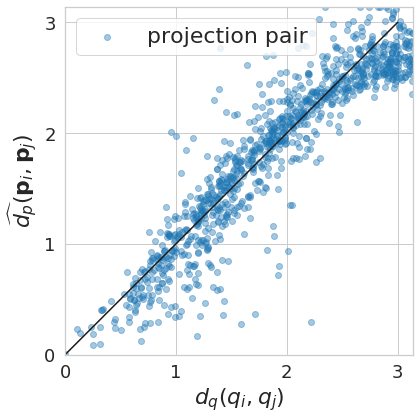

In [157]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5j0n_4d.pdf", pad_inches=1)
plt.show();

In [158]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.29980460143773435

In [159]:
data = np.load(f'{DATA_DIR}/dPdQ_data_256d_5j0n.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

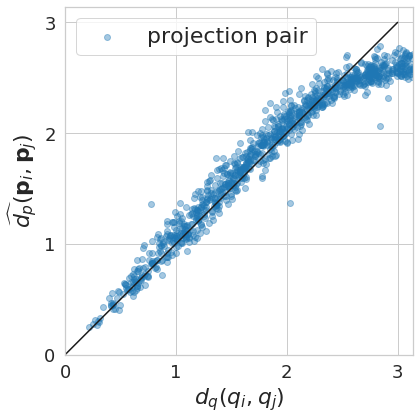

In [160]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5j0n_256.pdf", pad_inches=1)
plt.show();

In [161]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.1913641873528399

In [162]:
tick_size = 18
label_size = 22
textbox_size=22

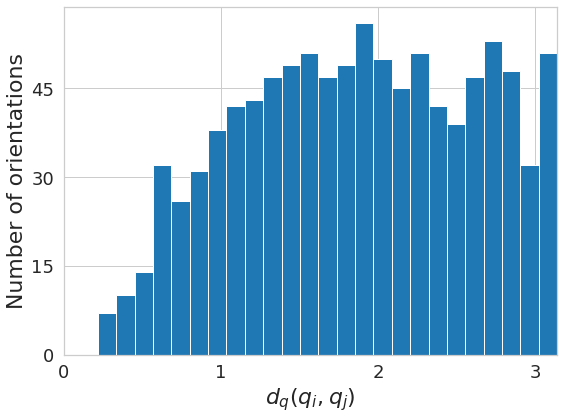

In [163]:
fig, ax = plt.subplots(figsize=(8,6));
ax.hist(dQ,bins=25, color=TEST_COLOR_LOR);
ax.set_xlim(0, np.pi)
#ax.set_ylim(0, np.pi)
ax.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax.set_ylabel("Number of orientations", fontsize=label_size)
#ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.tight_layout()
plt.savefig("pdfs/dQ_5j0n_histogram.pdf", pad_inches=1)
plt.show();

In [164]:
tick_size = 18
label_size = 22
textbox_size=22

In [165]:
data = np.load(f'{DATA_DIR}/dPdQ_data_fullcoverage_5j0n.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

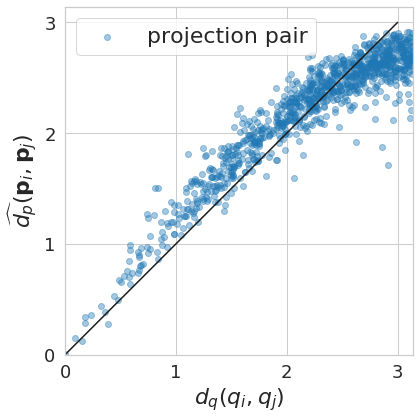

In [166]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5j0n_full.pdf", pad_inches=1)
plt.show();

In [167]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.2619094676050968

## Robustness to Unseen

In [252]:
data = np.load(f'{DATA_DIR}/dPdQ_data_robustness_to_unseen.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

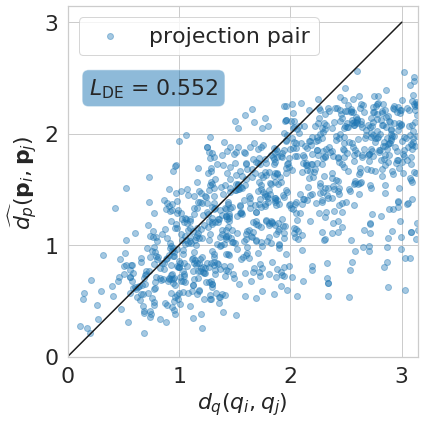

In [256]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)

props1 = dict(boxstyle='round', facecolor='#1f77b4', alpha=0.5)
ax.text(0.06, 0.8, "$L_\mathrm{DE}$ = "+f"{0.5518863:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5j0n_robustness_to_unseen.pdf", pad_inches=1)
plt.show();

In [254]:
from tensorflow.keras.losses import KLD, MAE, MSE
MAE(dQ, dP)

<tf.Tensor: id=948, shape=(), dtype=float32, numpy=0.5518863>

In [170]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.7065788519080951

---

## `5j0n` Full-coverage UniformS2 sampling and Noise 0

In [426]:
tick_size = 25
label_size = 35
textbox_size=27
legend_size = 20

In [427]:
# tick_size = 18
# label_size = 22
# textbox_size=22

In [428]:
data = np.load(f'{DATA_DIR}/dPdQ_d5j0n_fullcvg_uniformS2_noisy0.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

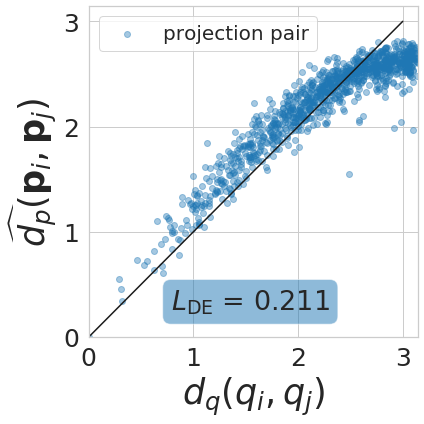

In [429]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)

from tensorflow.keras.losses import KLD, MAE, MSE
MAE(dQ, dP)
props1 = dict(boxstyle='round', facecolor='#1f77b4', alpha=0.5)
ax.text(0.25, 0.15, "$L_\mathrm{DE}$ = "+f"{MAE(dQ, dP):.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=legend_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5j0n_fullcvg_uniformS2_noise0.pdf", pad_inches=1)
plt.show();

In [81]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.2615634120003712

---

## `5j0n` Full-coverage UniformS2 sampling and Noise 16

In [80]:
tick_size = 18
label_size = 22
textbox_size=22

In [81]:
data = np.load(f'{DATA_DIR}/dPdQ_d5j0n_fullcvg_uniformS2_noisy16.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

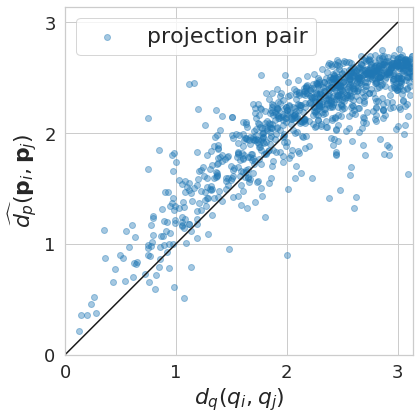

In [82]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5j0n_fullcvg_uniformS2_noise16.pdf", pad_inches=1)
plt.show();

In [83]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.35805289936047796

---

## `5a1a` quarter-coverage UniformS2 sampling and Noise 0

In [84]:
tick_size = 18
label_size = 22
textbox_size=22

In [85]:
data = np.load(f'{DATA_DIR}/dPdQ_data_5a1a_quartercvg_uniformS2_noise0_halfInplane.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

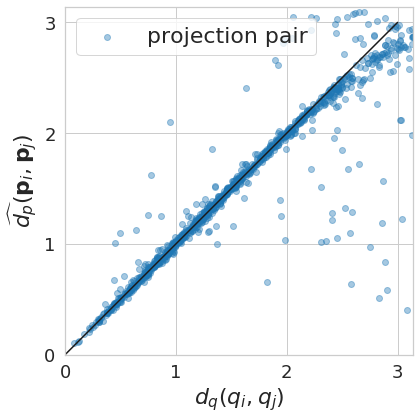

In [86]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5a1a_quartercvg_uniformS2_noise0_halfInplane.pdf", pad_inches=1)
plt.show();

In [87]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.2789694589615838

---

## `5a1a` quarter-coverage UniformS2 sampling and Noise 0

In [430]:
tick_size = 25
label_size = 35
textbox_size=27
legend_size = 20

In [431]:
data = np.load(f'{DATA_DIR}/dPdQ_data_5a1a_quartercvg_uniformS2_noise0.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

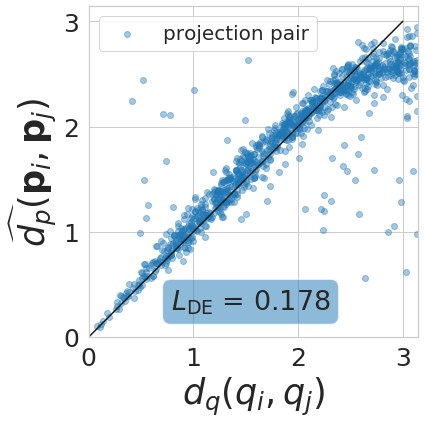

In [432]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)

from tensorflow.keras.losses import KLD, MAE, MSE
MAE(dQ, dP)
props1 = dict(boxstyle='round', facecolor='#1f77b4', alpha=0.5)
ax.text(0.25, 0.15, "$L_\mathrm{DE}$ = "+f"{MAE(dQ, dP):.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=legend_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5a1a_quartercvg_uniformS2_noise0.pdf", pad_inches=1)
plt.show();

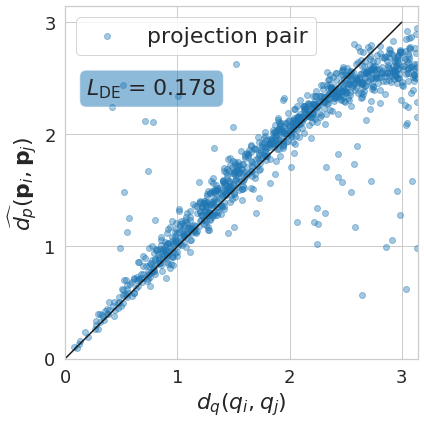

In [12]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)

from tensorflow.keras.losses import KLD, MAE, MSE
MAE(dQ, dP)
props1 = dict(boxstyle='round', facecolor='#1f77b4', alpha=0.5)
ax.text(0.06, 0.8, "$L_\mathrm{DE}$ = "+f"{MAE(dQ, dP):.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5a1a_quartercvg_uniformS2_noise0.pdf", pad_inches=1)
plt.show();

In [250]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.3131353700352579

---

In [62]:
data = np.load(f'{DATA_DIR}/dPdQ_data_fullcvg.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

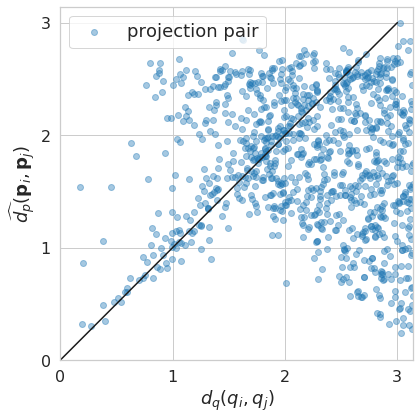

In [63]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5a1a_quartercvg_uniformS2_noise0_1.pdf", pad_inches=1)
plt.show();

In [64]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.9930251425487079

---

In [65]:
data = np.load(f'{DATA_DIR}/dPdQ_data_fullcvg2.npz')
dP  = data['arr_0']
dQ  = data['arr_1']

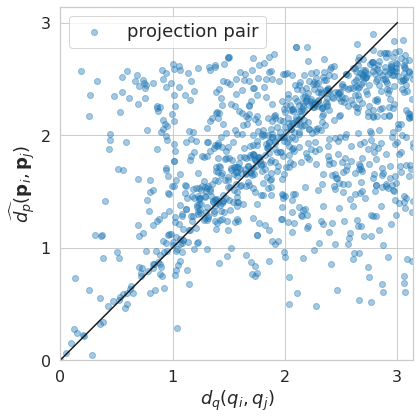

In [66]:
#df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")

#plt.clf();
fig, ax = plt.subplots(figsize=(6,6));
plt.scatter(dQ, dP, color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
plt.plot(x, x, color="k")
ax.set_xlim(0, np.pi)
ax.set_ylim(0, np.pi)
plt.xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
plt.ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
plt.legend(loc=2, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax.yaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
plt.tight_layout()
plt.savefig("pdfs/dPdQ_5a1a_quartercvg_uniformS2_noise0_2.pdf", pad_inches=1)
plt.show();

In [253]:
variance = np.sqrt(1/(len(dQ)-1)*np.sum(np.power(dP-dQ, 2)))
variance

0.98561770326284

## `5j0n` Distance Estimation Loss

In [9]:
tick_size = 26
label_size = 30
textbox_size=30

In [184]:
df0_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

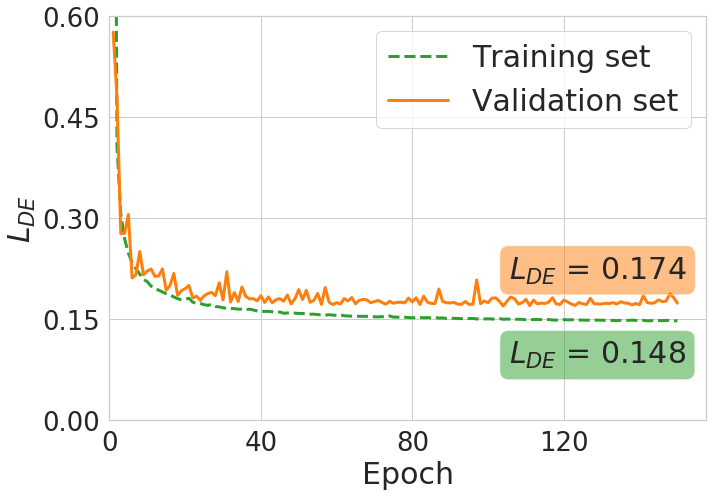

In [185]:
# Get training and test loss histories
training_loss = df0_train['Value'].values
val_loss = df0_val['Value'].values

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.67, 0.41, "$L_{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.67, 0.20, "$L_{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.legend(loc=1, fontsize=label_size)
ax.set_ylim(0, 0.6)
ax.set_xlim(0)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig("pdfs/de_5j0n.pdf")

plt.show();

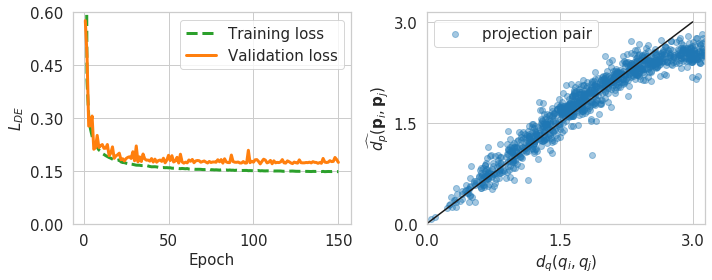

In [48]:
#fig = plt.figure(figsize=(8, 7))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
#ax1 = fig.add_axes([0, 0, 1.2, 0.8])
#ax2 = fig.add_axes([1.35, 0, 0.8, 0.8], facecolor="white")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training loss')
ax1.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation loss')
ax1.set_xlabel('Epoch', fontsize=label_size)
ax1.set_ylabel('$L_{DE}$', fontsize=label_size)
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc=1, fontsize=label_size)
ax1.set_ylim(0, 0.6)
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

####
df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5j0n.csv")
ax2.scatter(df1["d_Q"], df1["d_P"], color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
ax2.plot(x, x, color="k")
ax2.set_xlim(0, np.pi)
ax2.set_ylim(0, np.pi)
ax2.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax2.set_ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
ax2.tick_params(axis='both', which='major', labelsize=label_size)
ax2.legend(loc=2, fontsize=label_size)
ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))

plt.tight_layout()
plt.savefig("pdfs/de_loss_dPdQ_5j0n.pdf", pad_inches=1)
plt.show();

---

In [26]:
tick_size = 26
label_size = 30
textbox_size=30

In [27]:
df0_train = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_5a1a_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{DATA_DIR}/run-noisy_var0_5a1a_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

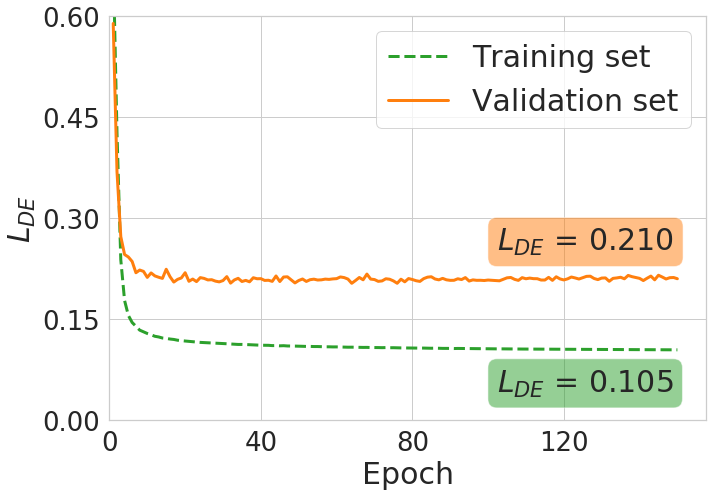

In [28]:
# Get training and test loss histories
training_loss = df0_train['Value'].values[78:228]
val_loss = df0_val['Value'].values[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.65, 0.48, "$L_{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.65, 0.13, "$L_{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.6)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig("pdfs/de_5a1a.pdf")
plt.show();

In [29]:
tick_size = 15
label_size = 15
textbox_size=20

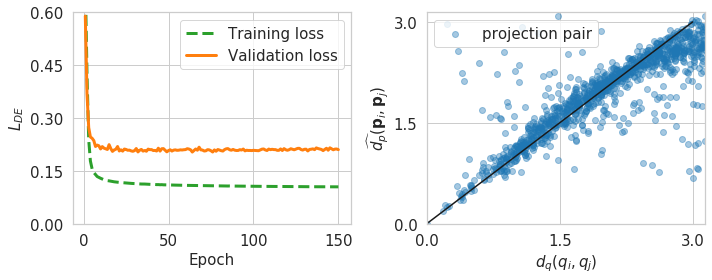

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training loss')
ax1.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation loss')
ax1.set_xlabel('Epoch', fontsize=label_size)
ax1.set_ylabel('$L_{DE}$', fontsize=label_size)
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc=1, fontsize=label_size)
ax1.set_ylim(0, 0.6)
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

####
df1 = pd.read_csv(f"{DATA_DIR}/dP_dQ_5a1a.csv")
ax2.scatter(df1["d_Q"], df1["d_P"], color=TEST_COLOR_LOR, alpha=0.4, label="projection pair");  # "reg", "kde"
#sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde", ax=ax[1]);  # "reg", "kde"
x = np.arange(0, np.pi);
ax2.plot(x, x, color="k")
ax2.set_xlim(0, np.pi)
ax2.set_ylim(0, np.pi)
ax2.set_xlabel("$d_q(q_i, q_j)$", fontsize=label_size)
ax2.set_ylabel("$\widehat{d_p}(\mathbf{p}_i, \mathbf{p}_j)$", fontsize=label_size)
ax2.tick_params(axis='both', which='major', labelsize=label_size)
ax2.legend(loc=2, fontsize=label_size)
ax2.xaxis.set_major_locator(plt.MaxNLocator(3))
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))

plt.tight_layout()
plt.savefig("pdfs/de_loss_dPdQ_5a1a.pdf", pad_inches=1)
plt.show();

---

## `5j0n` Full-coverage Uniform Euler Angles

In [122]:
tick_size = 26
label_size = 30
textbox_size=30

In [123]:
df0_train = pd.read_csv(f"{DATA_DIR}/run_train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{DATA_DIR}/run_validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

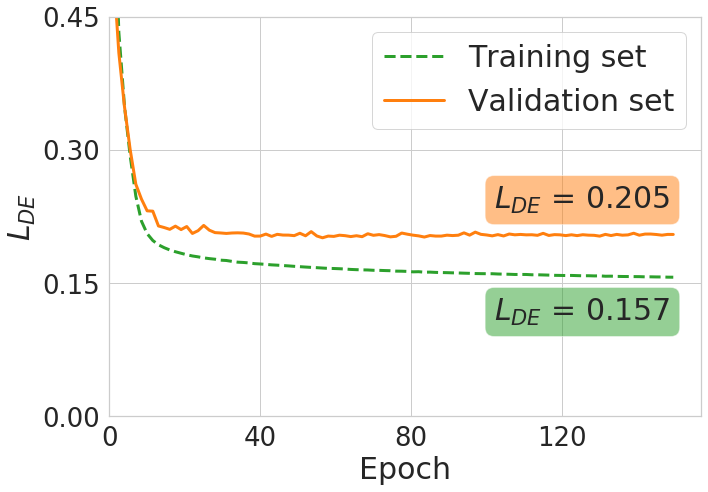

In [124]:
# Get training and test loss histories
training_loss = df0_train['Value'].values#[78:228]
val_loss = df0_val['Value'].values#[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = np.arange(1, 150, 1.5)#len(training_loss) + 1)

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.65, 0.58, "$L_{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.65, 0.3, "$L_{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.45)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig("pdfs/de_5j0n_fullcov.pdf")
plt.show();

---

## `5j0n` Full-coverage Uniform S2 Noise 0

In [380]:
tick_size = 30
label_size = 45
textbox_size=35
legend_size = 30

In [381]:
df0_train = pd.read_csv(f"{DATA_DIR}/run_train_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{DATA_DIR}/run_validation_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

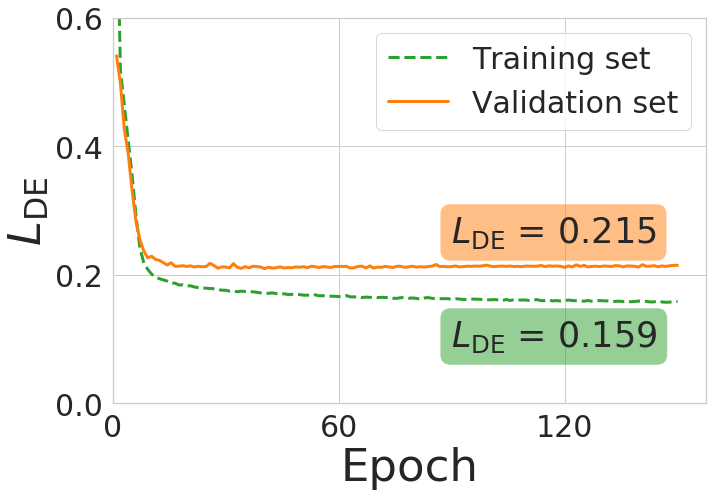

In [382]:
# Get training and test loss histories
training_loss = df0_train['Value'].values#[78:228]
val_loss = df0_val['Value'].values#[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = np.linspace(1, 150, 145)#len(training_loss) + 1)

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.57, 0.49, "$L_\mathrm{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.57, 0.22, "$L_\mathrm{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_\mathrm{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.6)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=legend_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.tight_layout()
plt.savefig("pdfs/de_5j0n_fullcov_uniformS2.pdf")
plt.show();

---

## `5a1a` Quarter-coverage Uniform S2 Noise 0

In [383]:
tick_size = 30
label_size = 45
textbox_size=35
legend_size = 30

In [386]:
df0_train = pd.read_csv(f"{DATA_DIR}/5a1a_quartercvg_uniformS2_noise0_halfInplane-run-train-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{DATA_DIR}/5a1a_quartercvg_uniformS2_noise0_halfInplane-run-validation-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

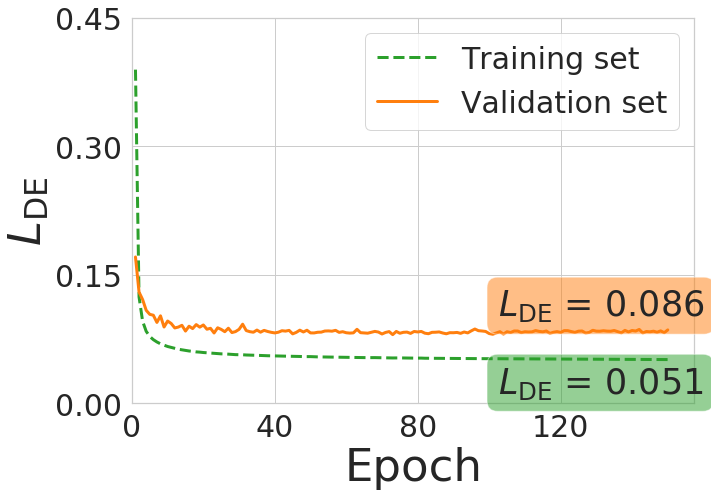

In [387]:
# Get training and test loss histories
training_loss = df0_train['Value'].values#[78:228]
val_loss = df0_val['Value'].values#[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = np.linspace(1, 150, 150)#len(training_loss) + 1)

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.65, 0.3, "$L_\mathrm{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.65, 0.1, "$L_\mathrm{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_\mathrm{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.45)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=legend_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig("pdfs/de_5a1a_quartercov_uniformS2.pdf")
plt.show();

---

## `5a1a` Full-coverage Uniform S2 Noise 0 trained on quartercov

In [388]:
import re

with open(f"{DATA_DIR}/de_losses.txt") as f:
    data = f.readlines()

trains = []
vals = []
for line in data:
    m = re.search("loss: ([0-9]+.[0-9]+) - mse: ([0-9]+.[0-9]+) - val_loss: ([0-9]+.[0-9]+)", line)
    if m is not None:
        trains.append(m.group(1))
        vals.append(m.group(3))

In [389]:
df0_train = pd.DataFrame(data={"Value":trains})
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.DataFrame(data={"Value":vals})
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

In [391]:
tick_size = 30
label_size = 45
textbox_size=35
legend_size = 30

In [392]:
# df0_train = pd.read_csv(f"{DATA_DIR}/run_train_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
# df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
# df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

# df0_val = pd.read_csv(f"{DATA_DIR}/run_validation_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
# df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
# df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

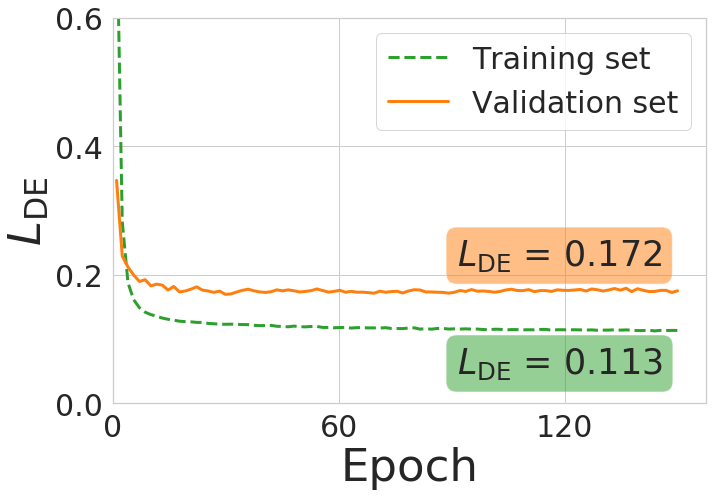

In [400]:
# Get training and test loss histories
training_loss = np.array(trains, dtype=np.float32)  #df0_train['Value'].values#[78:228]
val_loss = np.array(vals, dtype=np.float32) # df0_val['Value'].values#[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = np.linspace(1, 150, 99)#len(training_loss) + 1)


props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.58, 0.43, "$L_\mathrm{DE}$ = "+f"{val_loss[-2]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.58, 0.15, "$L_\mathrm{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_\mathrm{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.6)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=legend_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
plt.tight_layout()
plt.savefig("pdfs/de_5a1a_last.pdf")
plt.show();

---

In [88]:
import re

with open(f"{DATA_DIR}/de_5j0n_unseen.txt") as f:
    data = f.readlines()

trains = []
vals = []
for line in data:
    m = re.search("loss: ([0-9]+.[0-9]+) - mse: ([0-9]+.[0-9]+) - val_loss: ([0-9]+.[0-9]+)", line)
    if m is not None:
        trains.append(m.group(1))
        vals.append(m.group(3))

In [89]:
df0_train = pd.DataFrame(data={"Value":trains})
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.DataFrame(data={"Value":vals})
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

In [90]:
tick_size = 26
label_size = 30
textbox_size=30

In [91]:
# df0_train = pd.read_csv(f"{DATA_DIR}/run_train_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
# df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
# df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

# df0_val = pd.read_csv(f"{DATA_DIR}/run_validation_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
# df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
# df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

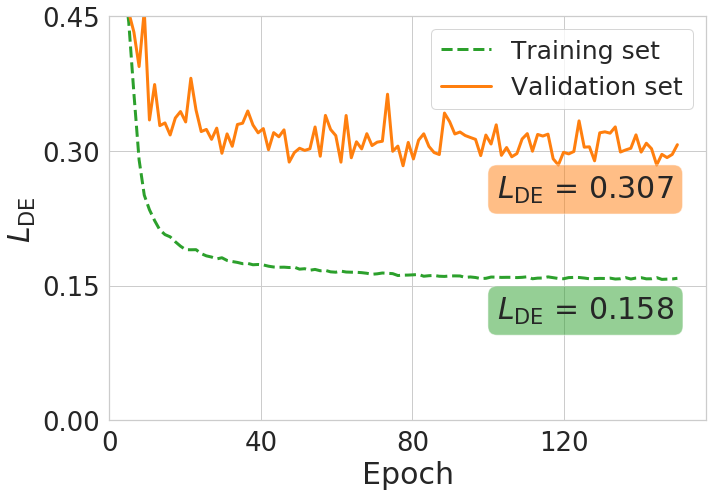

In [100]:
# Get training and test loss histories
training_loss = np.array(trains, dtype=np.float32)  #df0_train['Value'].values#[78:228]
val_loss = np.array(vals, dtype=np.float32) # df0_val['Value'].values#[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = np.linspace(1, 150, 110)#len(training_loss) + 1)


props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.65, 0.61, "$L_\mathrm{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.65, 0.31, "$L_\mathrm{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_\mathrm{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.45)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=label_size-5)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig("pdfs/de_5j0n_unseen.pdf")
plt.show();

---

In [265]:
import re

with open(f"{DATA_DIR}/de_losses.txt") as f:
    data = f.readlines()

trains = []
vals = []
for line in data:
    m = re.search("loss: ([0-9]+.[0-9]+) - mse: ([0-9]+.[0-9]+) - val_loss: ([0-9]+.[0-9]+)", line)
    if m is not None:
        trains.append(m.group(1))
        vals.append(m.group(3))

In [269]:
df0_train = pd.DataFrame(data={"Value":trains})
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.DataFrame(data={"Value":vals})
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

In [270]:
tick_size = 26
label_size = 30
textbox_size=30

In [271]:
# df0_train = pd.read_csv(f"{DATA_DIR}/run_train_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
# df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
# df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

# df0_val = pd.read_csv(f"{DATA_DIR}/run_validation_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
# df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
# df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

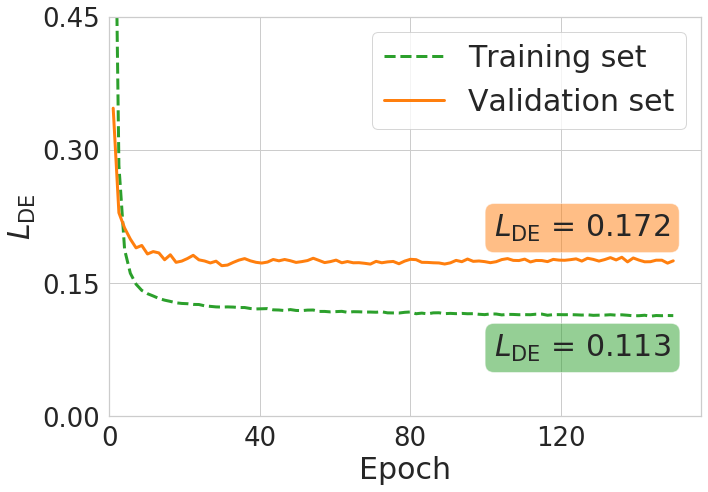

In [279]:
# Get training and test loss histories
training_loss = np.array(trains, dtype=np.float32)  #df0_train['Value'].values#[78:228]
val_loss = np.array(vals, dtype=np.float32) # df0_val['Value'].values#[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = np.linspace(1, 150, 99)#len(training_loss) + 1)


props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.65, 0.51, "$L_\mathrm{DE}$ = "+f"{val_loss[-2]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.65, 0.21, "$L_\mathrm{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_\mathrm{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.45)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig("pdfs/de_5a1a_last.pdf")
plt.show();

---

In [ ]:
## `5j0n` Full-coverage Uniform S2 Noise 0

tick_size = 26
label_size = 30
textbox_size=30

df0_train = pd.read_csv(f"{DATA_DIR}/run_train_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
df0_train["noise_variance"] = df0_train.apply(lambda x: 0, axis=1)
df0_train["dataset"] = df0_train.apply(lambda x: "train", axis=1)

df0_val = pd.read_csv(f"{DATA_DIR}/run_validation_5j0n_fullcvg_uniformS2-tag-epoch_loss.csv")
df0_val["noise_variance"] = df0_val.apply(lambda x: 0, axis=1)
df0_val["dataset"] = df0_val.apply(lambda x: "validation", axis=1)

# Get training and test loss histories
training_loss = df0_train['Value'].values#[78:228]
val_loss = df0_val['Value'].values#[78:228]

fig, ax = plt.subplots(figsize=(10,7))

# Create count of the number of epochs
epoch_count = np.linspace(1, 150, 145)#len(training_loss) + 1)

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

# Visualize loss history
ax.plot(epoch_count, training_loss, c=TRAIN_COLOR, ls='--', lw=3, label='Training set')
ax.text(0.65, 0.6, "$L_\mathrm{DE}$ = "+f"{val_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax.plot(epoch_count, val_loss, c=VAL_COLOR, ls='-', lw=3, label='Validation set')
ax.text(0.65, 0.3, "$L_\mathrm{DE}$ = "+f"{training_loss[-1]:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)
ax.set_xlabel('Epoch', fontsize=label_size)
ax.set_ylabel('$L_\mathrm{DE}$', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.set_ylim(0, 0.45)
ax.set_xlim(0)
ax.legend(loc=1, fontsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()
plt.savefig("pdfs/de_5j0n_fullcov_uniformS2.pdf")
plt.show();

---

In [31]:
losses_plot = np.loadtxt('5j0n_LOR_noise0.csv')
d2 = np.loadtxt('5j0n_EOR_noise0.csv')
loss_last= 0.16293360728335787

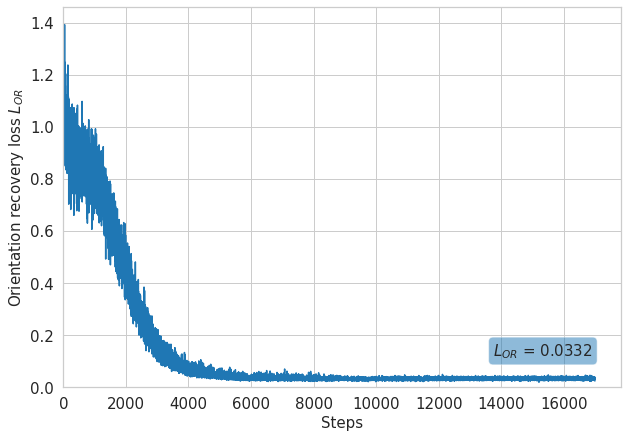

In [32]:

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) 
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.77, 0.12, "$L_{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig('pdfs/5j0n_noise0_angle_recovery.pdf')  
plt.show()

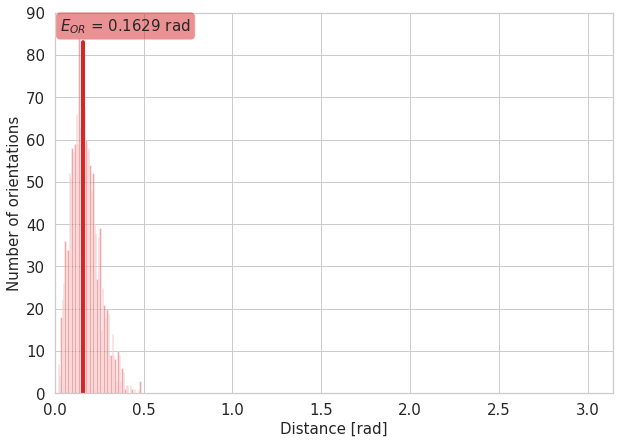

In [33]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlim(0, np.pi);ax.set_ylim(0, 90)
# plot histogram
s = sns.distplot(d2, kde=False, bins=60, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, "$E_{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig('pdfs/5j0n_noise0_angle_alignment_after.pdf')   
plt.show()

In [34]:
tick_size = 18
label_size = 20
textbox_size=20

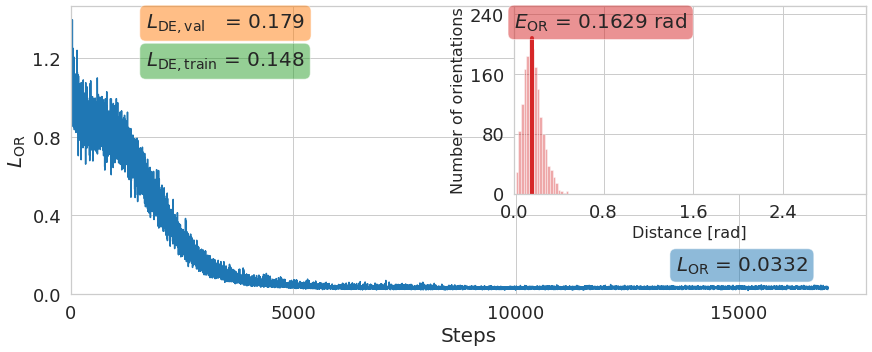

In [35]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.072, 0.17, 0.92, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(1.05, 0.09, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 250)
# plot histogram
s = sns.distplot(d2, kde=False, bins=20, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.76, 0.73, "$E_\mathrm{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+ str(0.179), transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.148:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


#plt.tight_layout()
#plt.gcf().subplots_adjust(bottom=-10)
plt.savefig("pdfs/5j0n_noise0_ar_aa.pdf")
plt.show();

---

In [38]:
tick_size = 18
label_size = 20
textbox_size=20

In [71]:
losses_plot = np.loadtxt('5j0n_LOR_noise16.csv')
d2 = np.loadtxt('5j0n_EOR_noise16.csv')
loss_last= 0.4039684191404425

In [72]:
# data = np.load(f"{DATA_DIR}/angle_recovery_noisy16_limited3.14_estimated_50k.npz")
# q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

# angles_predicted = quaternion2euler(q_predicted)
# angles_predicted.shape

In [73]:
# losses_plot = losses[losses>1e-5]

# fig, ax = plt.subplots(figsize=(10,7))
# plt.plot(losses_plot) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
# plt.xlabel("Steps", fontsize=tick_size)
# plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
# ax.tick_params(axis='both', which='major', labelsize=label_size)
# ax.set_xlim(0)
# ax.set_ylim(0)

# props = dict(boxstyle='round', facecolor='b', alpha=0.5)
# # place a text box in upper left in axes coords
# ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
#         verticalalignment='top', bbox=props)
# #plt.savefig("pdfs/5j0n_noise16_angle_recovery.pdf")
# plt.show()

In [74]:
# np.savetxt('5j0n_LOR_noise16.csv', losses_plot)

In [75]:
# from cryoem.angle_alignment import training_angle_alignment, update_quaternion
# from tensorflow.keras.optimizers import Adagrad, Ftrl

In [76]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=np.array(angles_true)[test_idx], 
#                                                         angles_predicted=angles_predicted.numpy()[test_idx])

In [77]:
# m= [1.0, 1.0, 1.0, -1.0] 
# trajectory_first= [1.85851292, 1.43618651, 5.88178408, 3.27440446, 3.45451402, 2.50669375] 
# loss_first= 2.1299795108043504 
# trajectory_last= [  5.26063957,   7.67897047,   6.57416071,  17.74291902, -24.87016973,31.71659896] 
# loss_last= 0.4039684191404425


In [78]:
# fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted[test_idx], dtype=tf.float64)
# d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
# ax.set_xlim(0, np.pi)
# ax.set_ylim(0, 115)
# #ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
# s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
# max_count = int(max([h.get_height() for h in s.patches]))
# ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
# plt.xlabel("Distance [rad]", fontsize=tick_size)
# plt.ylabel("Number of orientations", fontsize=tick_size)
# # We change the fontsize of minor ticks label 
# ax.tick_params(axis='both', which='major', labelsize=label_size)


# props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# # place a text box in upper left in axes coords
# ax.text(0.77, 0.72, f"$E$ = {loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
#         verticalalignment='top', bbox=props)

In [79]:
# save just the data for the plot, not the whole pipeline
# np.savetxt('5j0n_EOR_noise16.csv', d2)

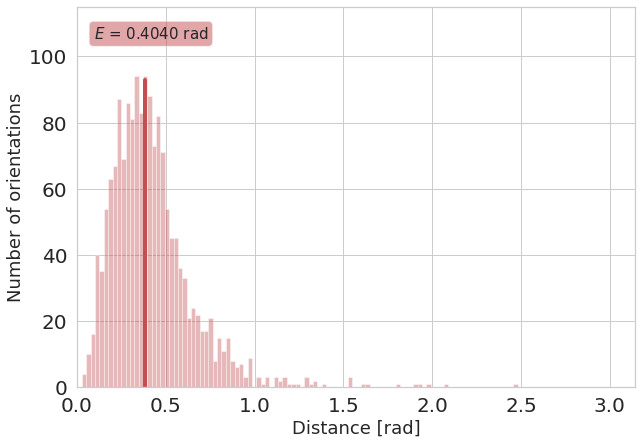

In [80]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
#q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64)
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 115)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5j0n_noise16_angle_alignment_after.pdf")
plt.show()

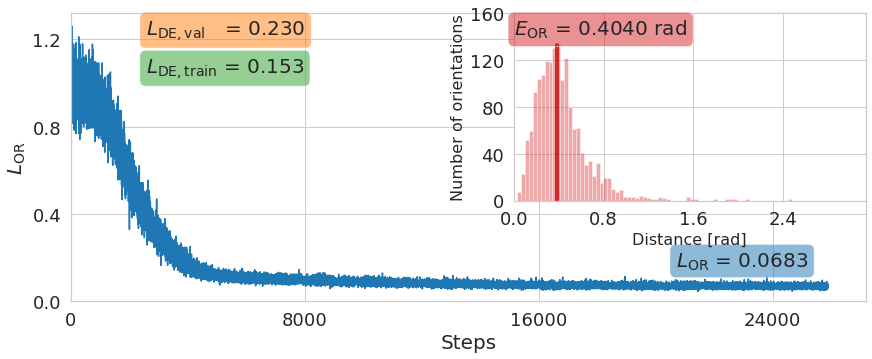

In [81]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.072, 0.17, 0.92, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(1.05, 0.12, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 160)
# plot histogram
s = sns.distplot(d2, kde=False, bins=70, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.76, 0.73, "$E_\mathrm{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2296:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.1530:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
#plt.tight_layout()
plt.savefig("pdfs/5j0n_noise16_ar_aa.pdf")
plt.show();

---

## `5a1a` Orientation Recovery Loss $L_{OR}$

In [24]:
losses_plot = np.loadtxt('5a1a_LOR_noise0.csv')
d2 = np.loadtxt('5a1a_EOR_noise0.csv')
loss_last = 0.18706397562242297

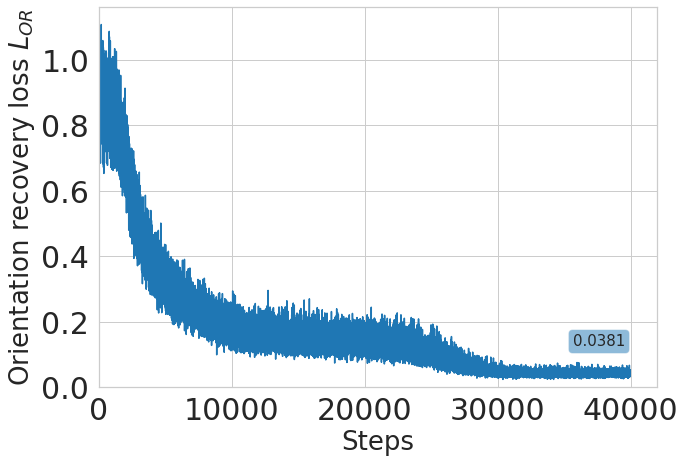

In [25]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.14, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 0.1871 rad')

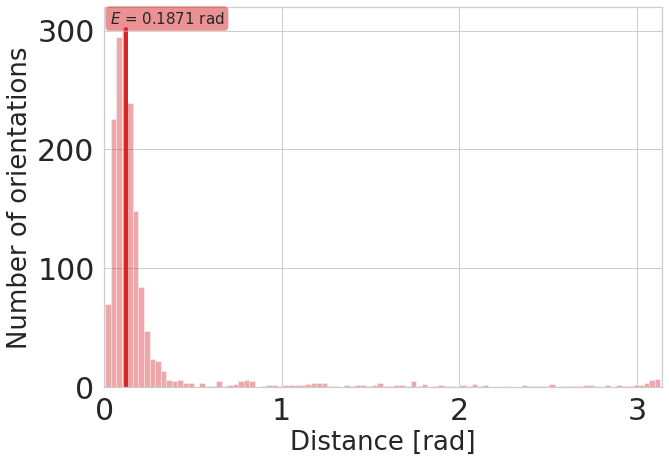

In [26]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 320)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

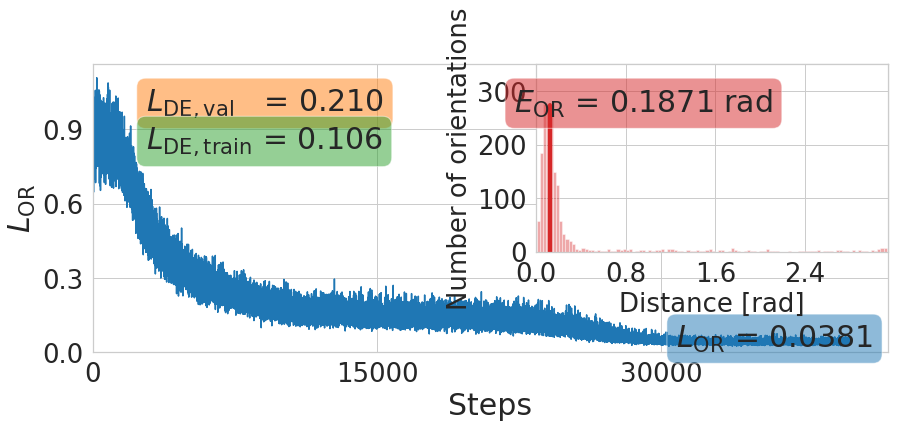

In [27]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.072, 0.17, 0.92, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(1.05, 0.11, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 350)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.76, 0.73, "$E_\mathrm{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2104:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.106:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_noise0_ar_aa.pdf")
plt.show();

In [28]:
d2

array([0.28376   , 0.13396735, 0.11737246, ..., 0.1160245 , 0.13513434,
       0.1074196 ])

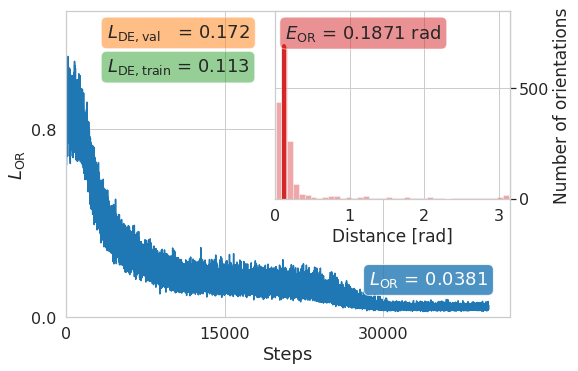

In [29]:
tick_size = 16
label_size = 18
textbox_size=18
label_size_small = 17

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.12, 0.13, 0.77, 0.85])
ax2 = fig.add_axes([0.483, 0.46, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(2))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(0.5, 0.1, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", color="white", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.35, 0.75, "$E_\mathrm{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.03, 0.75, "$L_\mathrm{DE, val}$   = "+f"{0.172:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.03, 0.66, "$L_\mathrm{DE, train}$ = "+f"{0.113:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_noise0_ar_aa.pdf")
plt.show();

---

## `5j0n` Orientation Recovery Loss $L_{OR}$ Full Coverage - Uniform Angles

In [537]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5j0n_LOR_fullcvg_uniformEuler.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5j0n_EOR_fullcvg_uniformEuler.csv')
loss_last= 0.22973200165467145

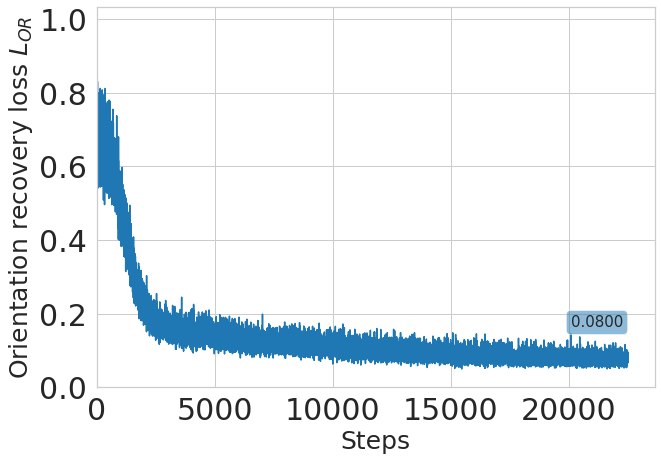

In [538]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.19, f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 0.2297 rad')

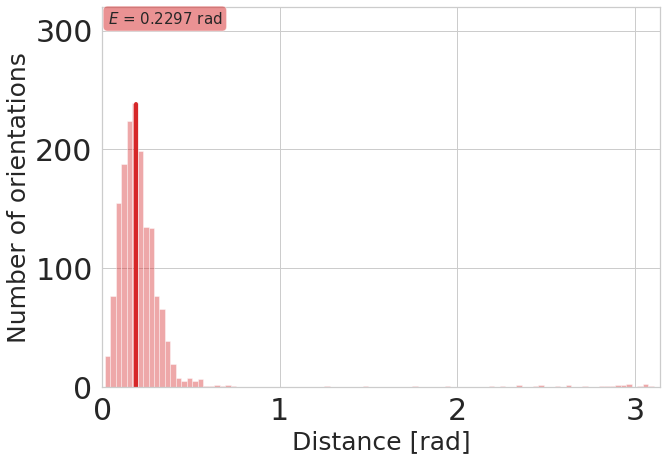

In [539]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 320)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

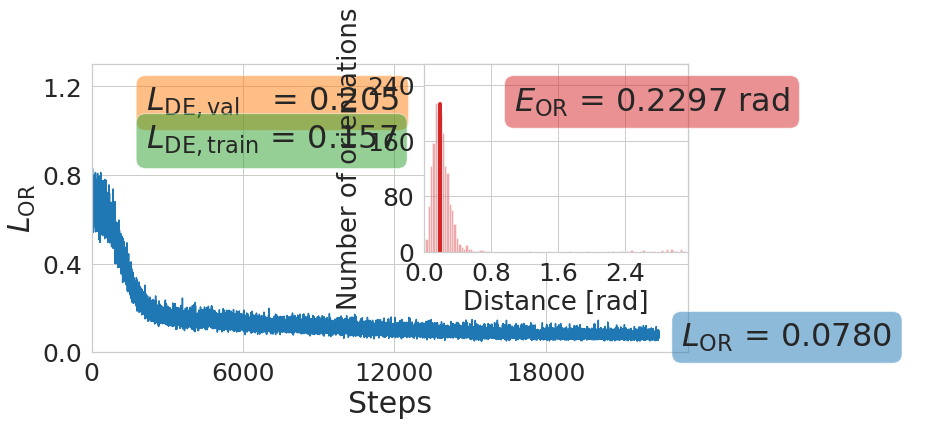

In [541]:
fig = plt.figure(figsize=(9, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.072, 0.17, 0.92, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(1.06, 0.11, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-5:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 270)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.76, 0.73, "$E_\mathrm{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2047:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.1568:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5j0n_ar_aa_fullcvg.pdf")
plt.show();

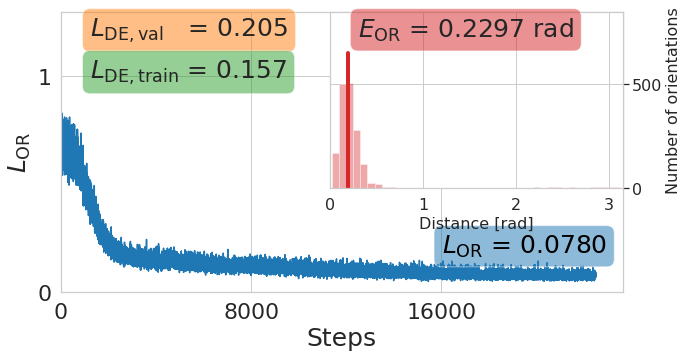

In [556]:
tick_size = 22
tick_size_small = 16
label_size = 25
textbox_size=25
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(10, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.11, 0.2, 0.78, 0.78])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.63, 0.16, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-5:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 650,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.48, 0.73, "$E_\mathrm{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(0, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2047:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0, 0.62, "$L_\mathrm{DE, train}$ = "+f"{0.1568:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5j0n_ar_aa_fullcvg_smaller.pdf")
plt.show();

---

## `5j0n` Orientation Recovery Loss $L_{OR}$ - Robustness to Unseen

In [101]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5j0n_LOR_robustness_to_unseen.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5j0n_EOR_robustness_to_unseen.csv')
loss_last= 1.3159446420492922

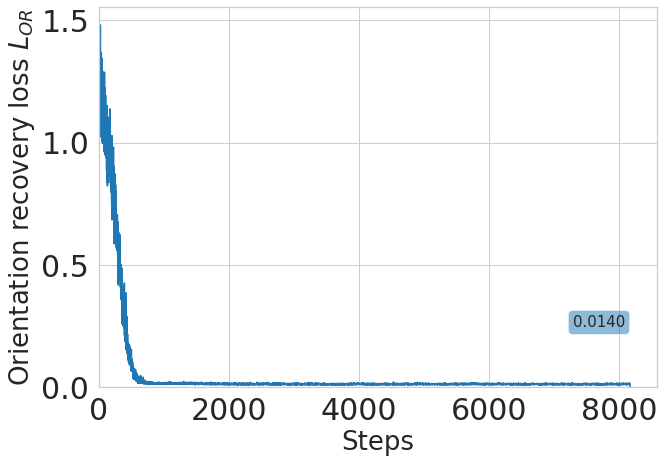

In [102]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.19, f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 1.3159 rad')

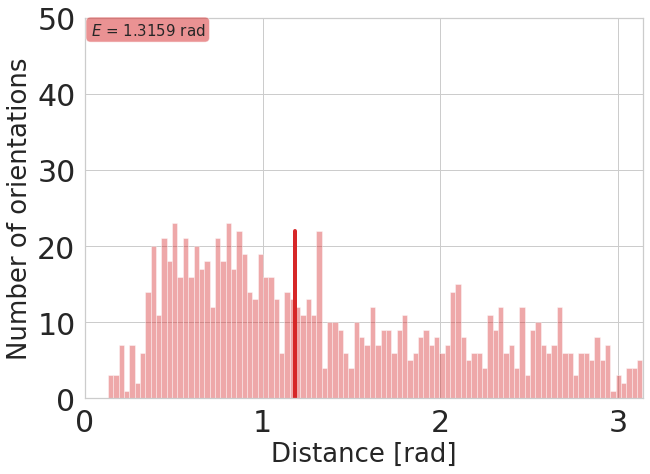

In [103]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 50)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

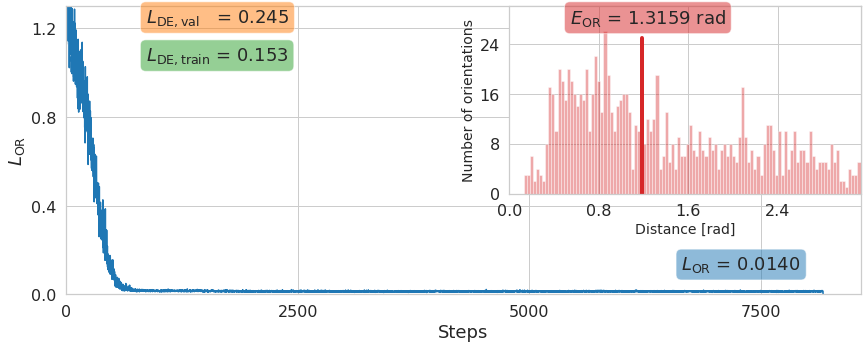

In [106]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.072, 0.17, 0.92, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(1.06, 0.08, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 30)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.86, 0.73, "$E_\mathrm{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2446:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.1529:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5j0n_ar_aa_robustness_to_unseen.pdf")
plt.show();

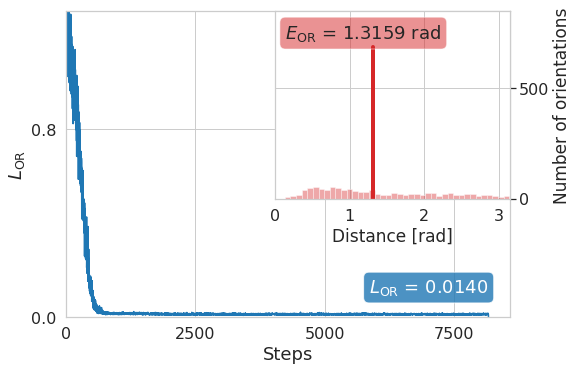

In [111]:
tick_size = 16
label_size = 18
textbox_size=18
label_size_small = 17

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.12, 0.13, 0.77, 0.85])
ax2 = fig.add_axes([0.483, 0.46, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(2))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(0.5, 0.08, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-20:-10]):.4f}", color="white", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
last_loss = 1.3159
ax2.plot([last_loss]*max_count, np.linspace(0, 690,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.35, 0.75, "$E_\mathrm{OR}$ = "+f"{last_loss:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

#ax1.text(0.03, 0.75, "$L_\mathrm{DE, val}$   = "+f"{0.215:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
#ax1.text(0.03, 0.66, "$L_\mathrm{DE, train}$ = "+f"{0.159:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5j0n_ar_aa_robustness_to_unseen.pdf")
plt.show();

---

## `5j0n` Orientation Recovery Loss $L_{OR}$ Full Coverage with Uniform S^2

In [38]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5j0n_LOR_uniformS2.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5j0n_EOR_uniformS2.csv')
loss_last= 0.19820391249042255

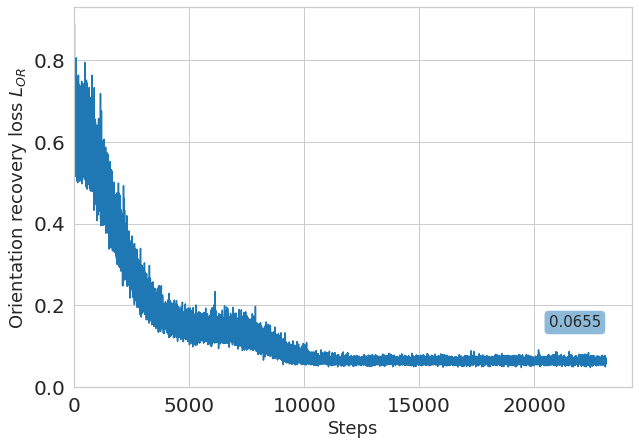

In [39]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.19, f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 0.1982 rad')

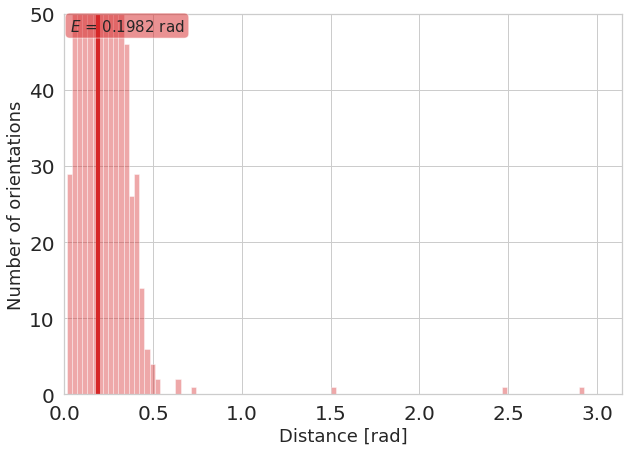

In [40]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 50)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

In [53]:
props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

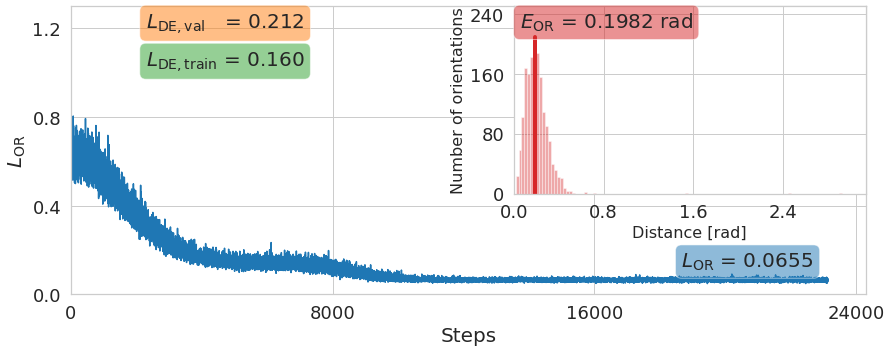

In [55]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.072, 0.17, 0.92, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(1.06, 0.1, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 250)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.77, 0.73, "$E_\mathrm{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2118:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.1601:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5j0n_ar_aa_fullcvg_uniform2.pdf")
plt.show();

---

## `5j0n` Orientation Recovery Loss $L_{OR}$ Full Coverage with Noisy 16

In [115]:
# import h5py
# PROTEIN="5j0n"

# projections_filename = f"../data/results_pipeline_5j0n_noise16_fullcvg/5j0n_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# data = h5py.File(projections_filename, 'r')

# angles_true = data['Angles']

In [116]:
# data = np.load(f"../data/results_pipeline_5j0n_noise16_fullcvg/5j0n_siamese_idx.npz")
# train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [117]:
# data = np.load(f"../data/results_pipeline_5j0n_noise16_fullcvg/angle_recovery.npz")
# q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

# angles_predicted = quaternion2euler(q_predicted)
# angles_predicted.shape

In [118]:
# losses_plot = losses[:23420]
# np.savetxt(f'{DATA_DIR}/5j0n_LOR_fullcov_noisy16.csv', losses_plot)

In [119]:
# plt.plot(losses_plot)

In [120]:
# from cryoem.angle_alignment import training_angle_alignment, update_quaternion
# from tensorflow.keras.optimizers import Adagrad, Ftrl

In [121]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=np.array(angles_true)[test_idx], 
#                                                         angles_predicted=angles_predicted.numpy())

In [122]:
# m= [1.0, 1.0, 1.0, 1.0] 
# trajectory_first= [5.47504361, 1.11776126 ,3.08424948, 4.09392916, 5.34986718, 4.18228422] 
# loss_first= 2.003425131890802 
# trajectory_last= [ 18.57972316 ,  5.16744374 , 12.27898479 , 10.98888536,  34.13920644,-14.08162527] 
# loss_last= 0.5081215700205459


In [123]:
# np.median(d2)

In [124]:
# fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64)

# d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
# ax.set_xlim(0, np.pi)
# ax.set_ylim(0, 40)
# #ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
# s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
# max_count = int(max([h.get_height() for h in s.patches]))
# ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
# plt.xlabel("Distance [rad]", fontsize=tick_size)
# plt.ylabel("Number of orientations", fontsize=tick_size)
# # We change the fontsize of minor ticks label 
# ax.tick_params(axis='both', which='major', labelsize=label_size)


# props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# # place a text box in upper left in axes coords
# ax.text(0.02, 0.97, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15,
#         verticalalignment='top', bbox=props)

In [125]:
# #save just the data for the plot, not the whole pipeline
# np.savetxt(f'{DATA_DIR}/5j0n_EOR_fullcov_noisy16.csv', d2)

In [103]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5j0n_LOR_fullcov_noisy16.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5j0n_EOR_fullcov_noisy16.csv')
loss_last= 0.2821325062436

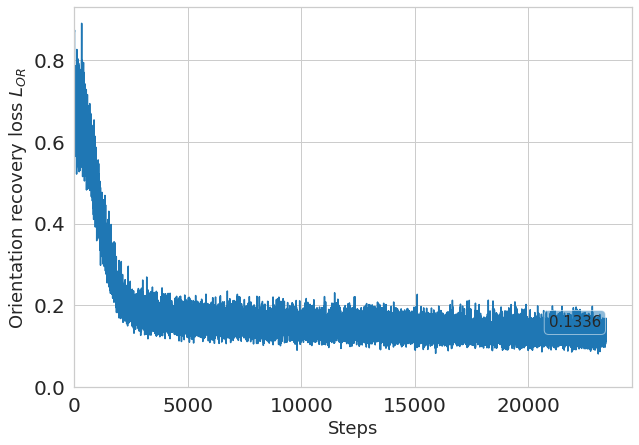

In [104]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.19, f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 0.2821 rad')

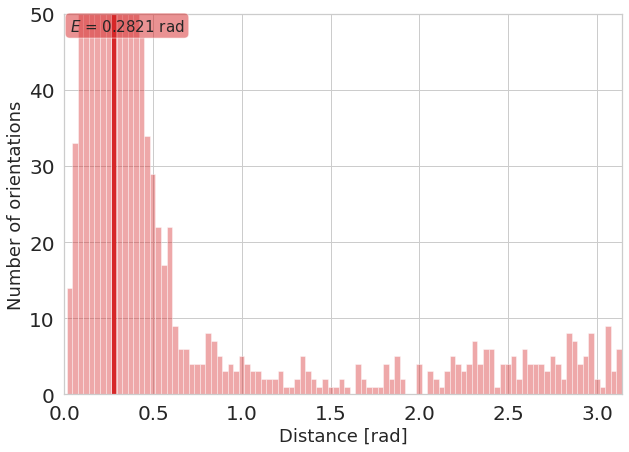

In [105]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 50)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

In [106]:
props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

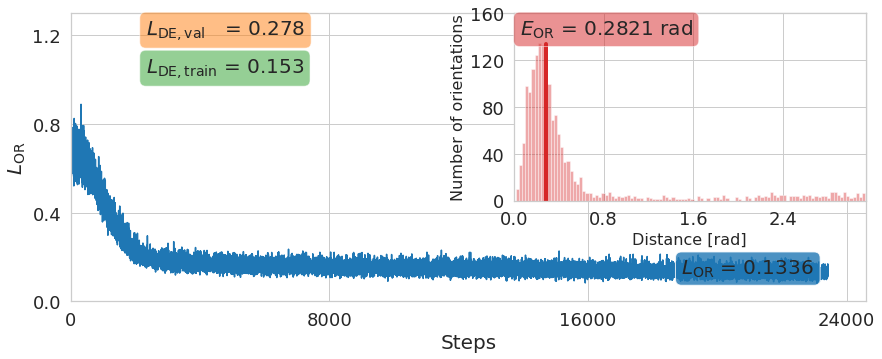

In [114]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.072, 0.17, 0.92, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(1.06, 0.1, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 160)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.77, 0.73, "$E_\mathrm{OR}$ = "+f"{loss_last:.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2780:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.1535:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5j0n_fullcov_noise16_ar_aa.pdf")
plt.show();

---

## `5j0n` Full Coverage Uniform S2 sampling with Noise 0

In [7]:
import h5py
PROTEIN="5j0n"

projections_filename = f"../data/results_pipeline_5j0n_fullcvg_uniformS2_noise0/5j0n_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

data = h5py.File(projections_filename, 'r')

angles_true = data['Angles']

In [8]:
data = np.load(f"../data/results_pipeline_5j0n_fullcvg_uniformS2_noise0/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [9]:
data = np.load(f"../data/results_pipeline_5j0n_fullcvg_uniformS2_noise0/angle_recovery.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)
angles_predicted.shape

TensorShape([1650, 3])

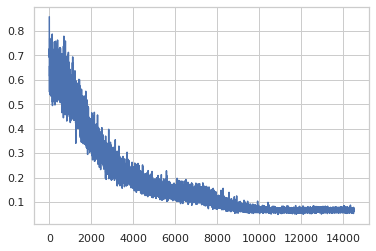

In [13]:
plt.plot(losses[:14490])

In [14]:
losses_plot = losses[:14490]
np.savetxt(f'{DATA_DIR}/5j0n_LOR_fullcvg_uniformS2_noise0.csv', losses_plot)

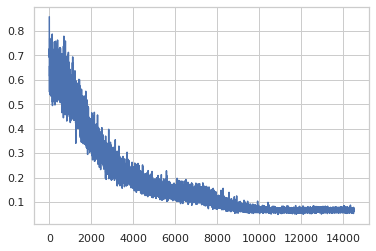

In [15]:
plt.plot(losses_plot)

In [16]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

m= [1.0, 1.0, 1.0, 1.0] 
trajectory_first= [4.46876821 5.19836847 1.77256393 4.79171568 0.59308777 3.54493704] 
loss_first= 2.123662027780452 
trajectory_last= [ 45.57891446  22.93904469 -15.69086015   7.4149353  -12.91150917
   7.22542069] 
loss_last= 0.21779469250103844


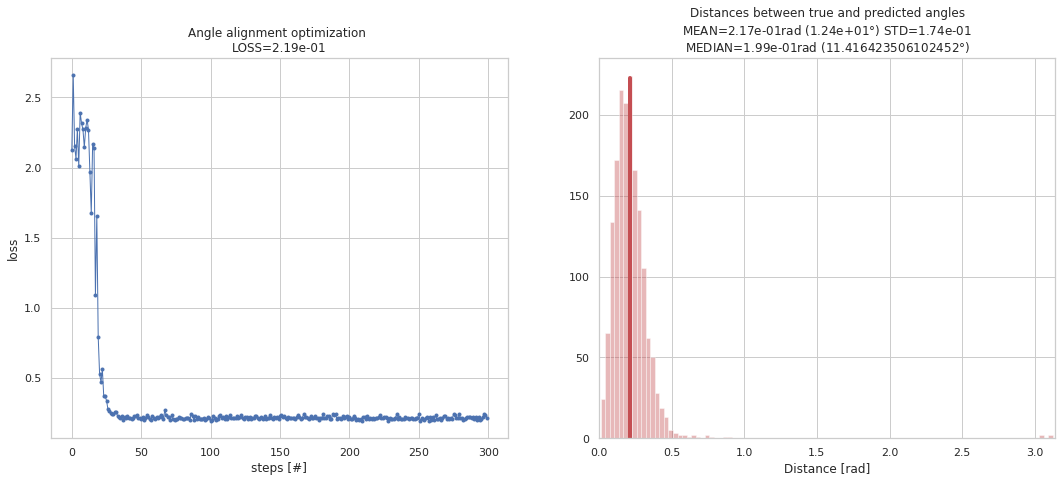

In [17]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=np.array(angles_true)[test_idx], 
                                                        angles_predicted=angles_predicted.numpy())

In [23]:
m= [1.0, 1.0, 1.0, 1.0] 
trajectory_first= [4.46876821, 5.19836847 ,1.77256393, 4.79171568, 0.59308777, 3.54493704] 
loss_first= 2.123662027780452 
trajectory_last= [ 45.57891446 , 22.93904469, -15.69086015  , 7.4149353 , -12.91150917, 7.22542069] 
loss_last= 0.19925397433019346


In [20]:
np.median(d2)

0.19925397433019346

Text(0.02, 0.97, '$E$ = 0.1993 rad')

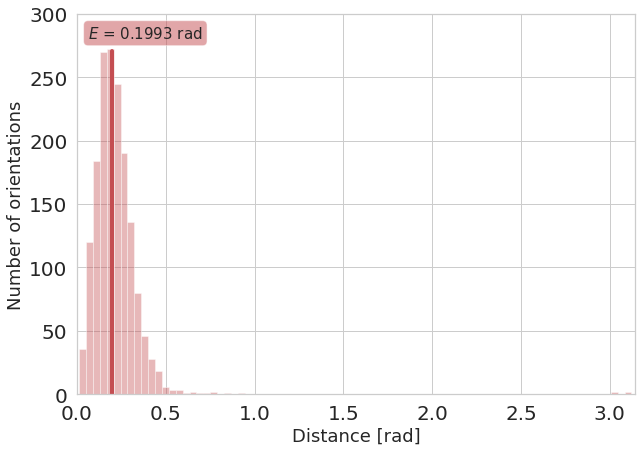

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64)

d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 300)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.02, 0.97, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

In [30]:
#save just the data for the plot, not the whole pipeline
np.savetxt(f'{DATA_DIR}/5j0n_EOR_fullcvg_uniformS2_noise0.csv', d2)

In [268]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5j0n_LOR_fullcvg_uniformS2_noise0.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5j0n_EOR_fullcvg_uniformS2_noise0.csv')
#loss_last= 0.19925397433019346

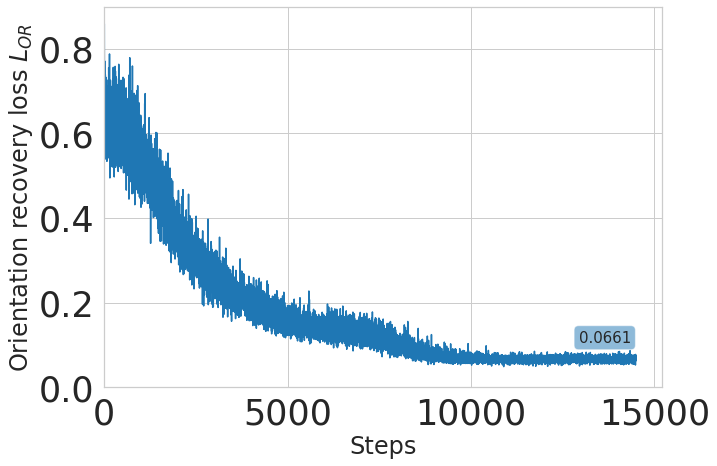

In [269]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.15, f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 0.1993 rad')

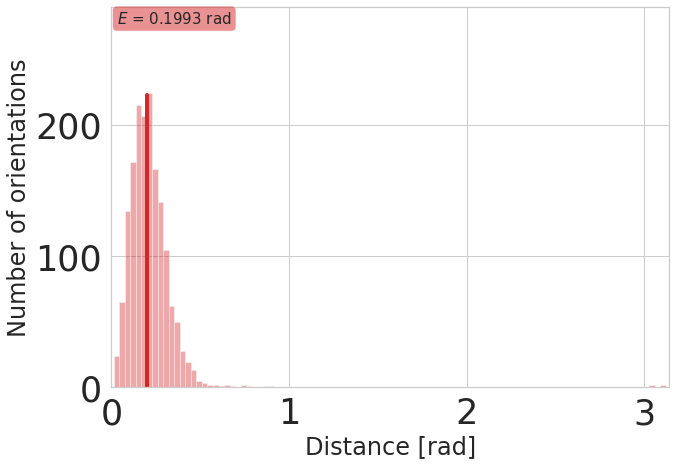

In [270]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 290)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

In [271]:
tick_size = 15
label_size = 15
textbox_size=20

In [272]:
props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

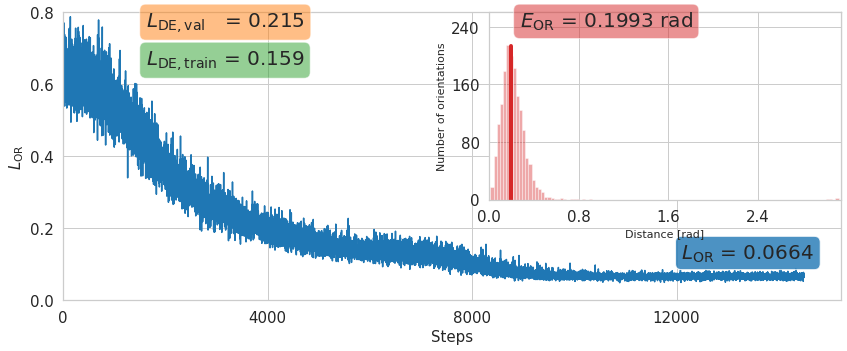

In [273]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.092, 0.17, 0.9, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,0.8)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(1.06, 0.12, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 260)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.77, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.215:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.159:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5j0n_fullcvg_uniformS2_noise0_ar_aa.pdf")
plt.show();

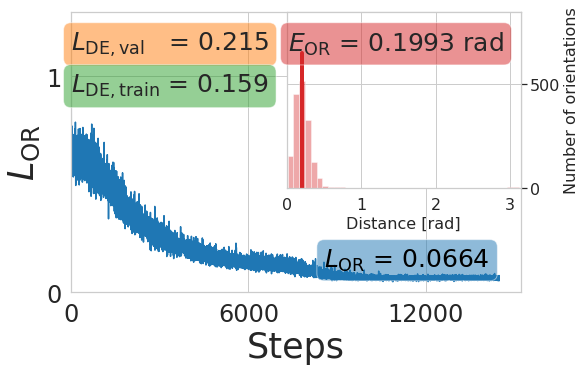

In [274]:
tick_size = 24
tick_size_small = 16
label_size = 35
textbox_size=25
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.11, 0.2, 0.78, 0.78])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.42, 0.16, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 650,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.355, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(-0.034, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.215:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(-0.034, 0.62, "$L_\mathrm{DE, train}$ = "+f"{0.159:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5j0n_fullcvg_uniformS2_noise0_ar_aa.pdf")
plt.show();

---

---

## `5j0n` Full Coverage Uniform S2 sampling with Noise 16

In [164]:
import h5py
PROTEIN="5j0n"

projections_filename = f"../data/results_pipeline_5j0n_fullcvg_uniformS2_noise16/5j0n_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

data = h5py.File(projections_filename, 'r')

angles_true = data['Angles']

In [165]:
data = np.load(f"../data/results_pipeline_5j0n_fullcvg_uniformS2_noise16/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [166]:
data = np.load(f"../data/results_pipeline_5j0n_fullcvg_uniformS2_noise16/angle_recovery.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)
angles_predicted.shape

TensorShape([1650, 3])

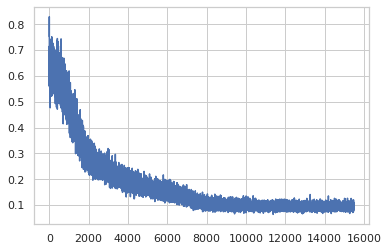

In [13]:
plt.plot(losses[:15480])

In [14]:
losses_plot = losses[:15480]
np.savetxt(f'{DATA_DIR}/5j0n_LOR_fullcvg_uniformS2_noise16.csv', losses_plot)

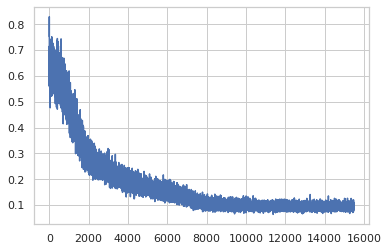

In [15]:
plt.plot(losses_plot)

In [16]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [5.35816095 0.43720051 5.15851773 2.73188982 0.42859129 1.49230368] 
loss_first= 1.8826677225422614 
trajectory_last= [ -6.48271167   8.97726631  18.29531352  -8.41445114 -12.41082295
 -36.04925105] 
loss_last= 0.34314423396857513


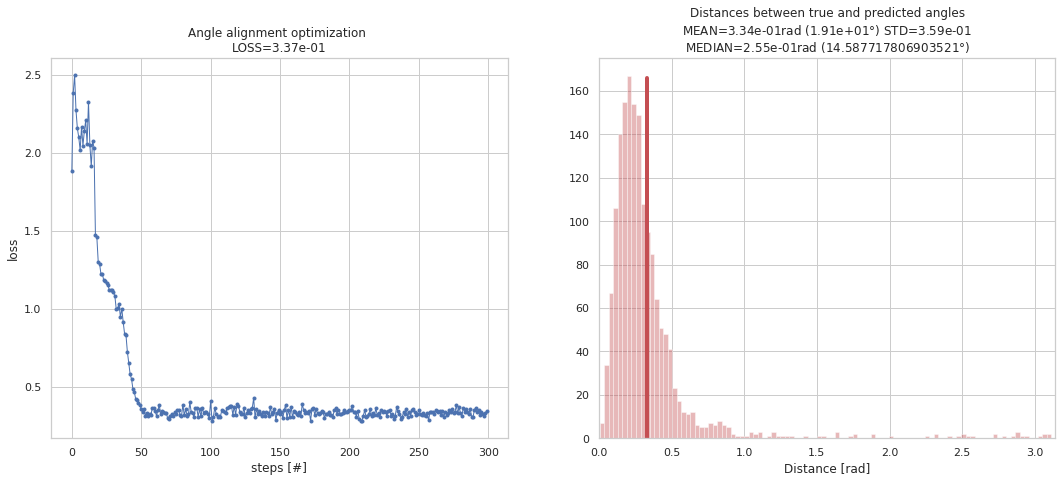

In [19]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=np.array(angles_true)[test_idx], 
                                                        angles_predicted=angles_predicted.numpy())

In [20]:
m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [5.35816095 ,0.43720051 ,5.15851773 ,2.73188982 ,0.42859129 ,1.49230368] 
loss_first= 1.8826677225422614 
trajectory_last= [ -6.48271167  , 8.97726631 , 18.29531352  ,-8.41445114 ,-12.41082295, -36.04925105] 
loss_last= 0.34314423396857513

In [21]:
#np.median(d2)

Text(0.02, 0.97, '$E$ = 0.2546 rad')

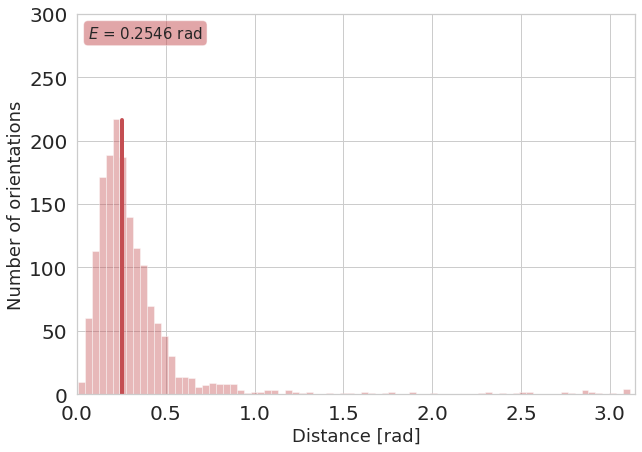

In [25]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64)

d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 300)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.02, 0.97, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

In [26]:
#save just the data for the plot, not the whole pipeline
np.savetxt(f'{DATA_DIR}/5j0n_EOR_fullcvg_uniformS2_noise16.csv', d2)

In [276]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5j0n_LOR_fullcvg_uniformS2_noise16.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5j0n_EOR_fullcvg_uniformS2_noise16.csv')
#loss_last= 0.19925397433019346

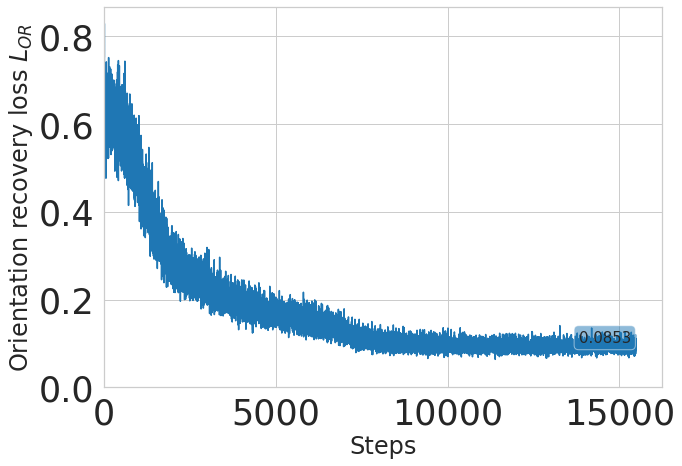

In [277]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.15, f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 0.2546 rad')

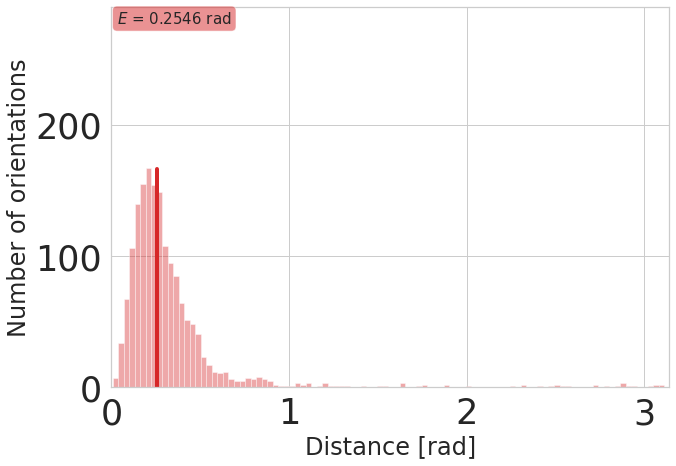

In [278]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 290)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

In [279]:
props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

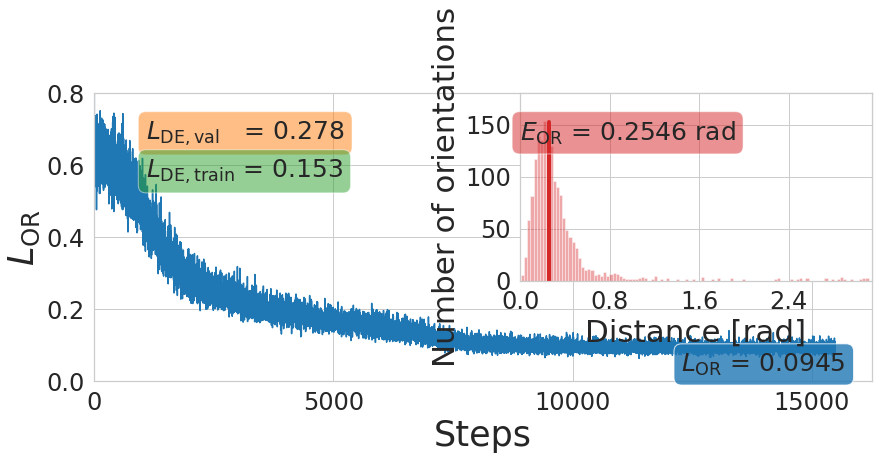

In [280]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.092, 0.17, 0.9, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,0.8)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(1.06, 0.12, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 180)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.77, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2780:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.1535:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5j0n_fullcvg_uniformS2_noise16_ar_aa.pdf")
plt.show();

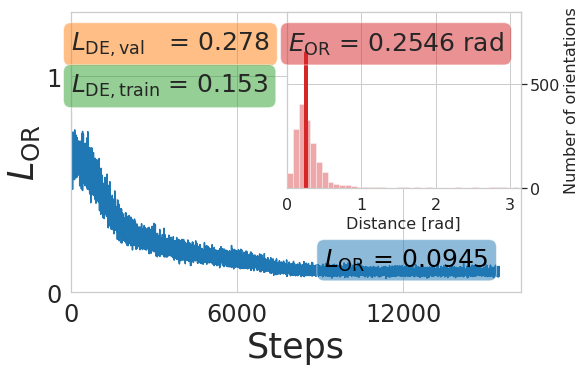

In [282]:
tick_size = 24
tick_size_small = 16
label_size = 35
textbox_size=25
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.11, 0.2, 0.78, 0.78])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.42, 0.16, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 650,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.355, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(-0.034, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2780:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(-0.034, 0.62, "$L_\mathrm{DE, train}$ = "+f"{0.1535:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5j0n_fullcvg_uniformS2_noise16_ar_aa.pdf")
plt.show();

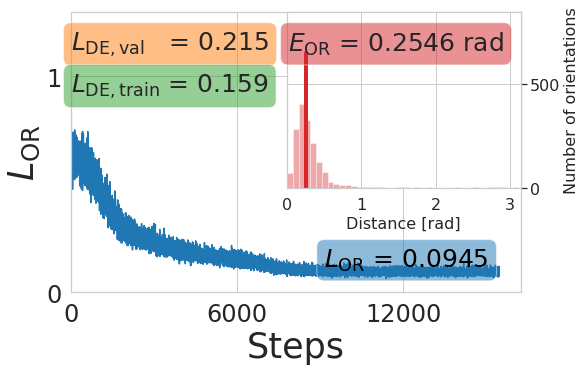

In [267]:
tick_size = 20
tick_size_small = 16
label_size = 26
textbox_size=22
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.13, 0.16, 0.76, 0.82])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(2))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(0.45, 0.13, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
#print(np.arange(0, max_count,1))
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 690,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.36, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(0.0, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.2780:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.0, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.1535:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5j0n_fullcvg_uniformS2_noise16_ar_aa.pdf")
plt.show();

---

## `5a1a` Quarter Coverage Uniform S2 sampling with Noise 0

In [44]:
import h5py
PROTEIN="5a1a"

projections_filename = f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0_halfInplane/5a1a_uniform_ProjectionsAngles_ProjNber5000_AngCoverage1.0,0.4,1.0_AngShift0.0,0.0,0.0.h5"

data = h5py.File(projections_filename, 'r')

angles_true = data['Angles']

In [45]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0_halfInplane/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [47]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0_halfInplane/angle_recovery_5a1a_quartercov_uniformS2_noise0_halfInplane.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)
angles_predicted.shape

TensorShape([1650, 3])

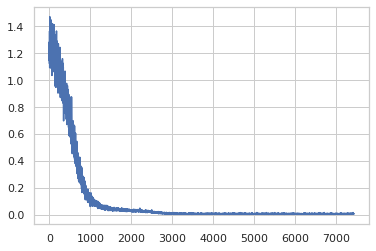

In [49]:
plt.plot(losses[:7420])

In [50]:
losses_plot = losses[:7420]
np.savetxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_noise0_halfInplane.csv', losses_plot)

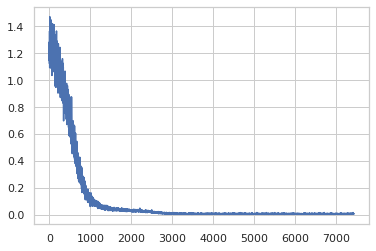

In [51]:
plt.plot(losses_plot)

In [52]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [3.34890285 3.69016587 2.7271652  0.72438695 2.60823194 5.92122635] 
loss_first= 2.2660283413308764 
trajectory_last= [ 37.23049454  -6.06286519 -19.53063564  -3.5650095   24.37399279
  -3.44652928] 
loss_last= 0.18156220496546172


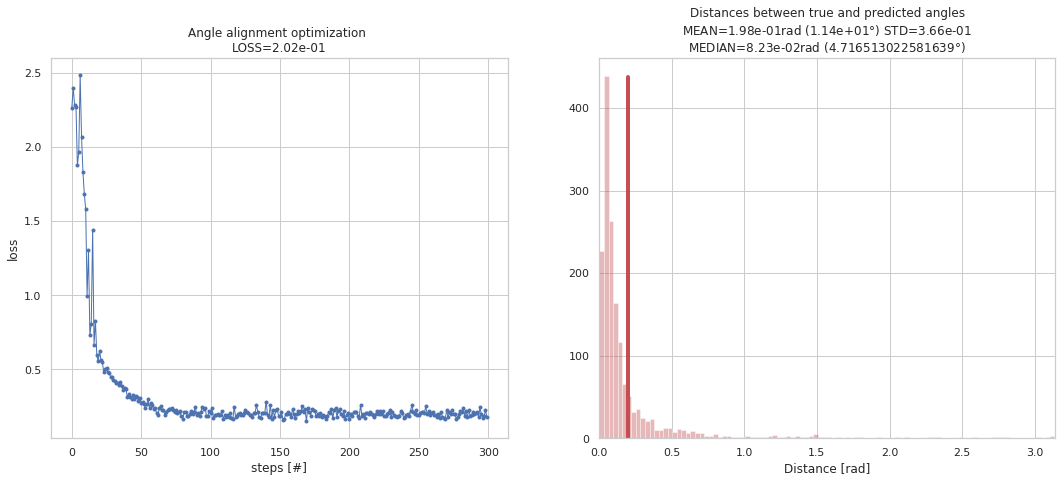

In [53]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=np.array(angles_true)[test_idx], 
                                                        angles_predicted=angles_predicted.numpy())

In [54]:
m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [3.34890285, 3.69016587, 2.7271652 , 0.72438695, 2.60823194, 5.92122635] 
loss_first= 2.2660283413308764 
trajectory_last= [ 37.23049454 , -6.06286519 ,-19.53063564 , -3.5650095  , 24.37399279,  -3.44652928] 
loss_last= 0.18156220496546172


In [55]:
#np.median(d2)

Text(0.02, 0.97, '$E$ = 0.0823 rad')

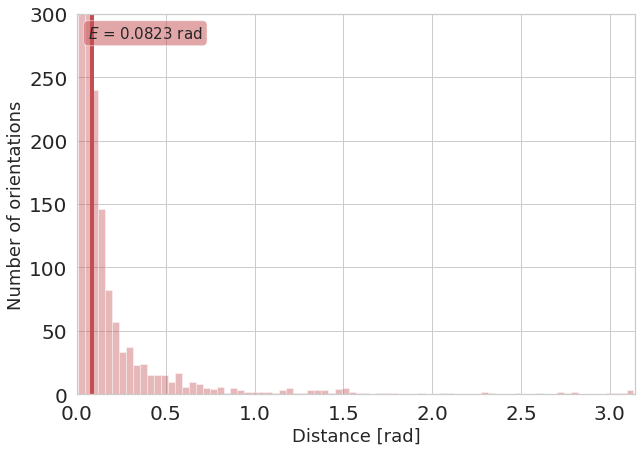

In [56]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64)

d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 300)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.02, 0.97, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

In [57]:
#save just the data for the plot, not the whole pipeline
np.savetxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_noise0_halfInplane.csv', d2)

In [255]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_noise0_halfInplane.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_noise0_halfInplane.csv')
#loss_last= 0.19925397433019346

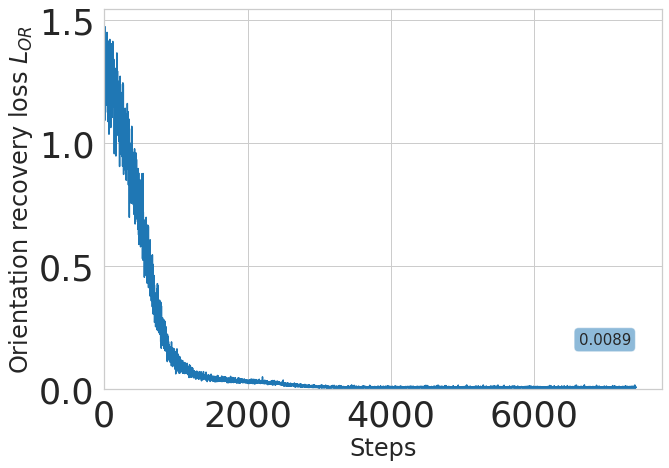

In [256]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.15, f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 3.0249 rad')

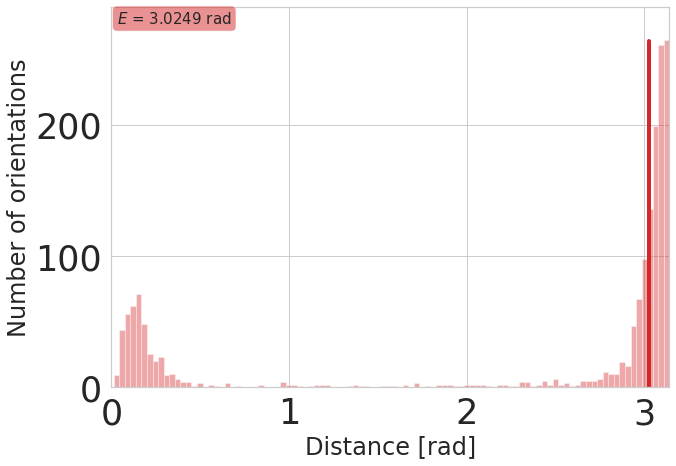

In [257]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 290)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

In [258]:
props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

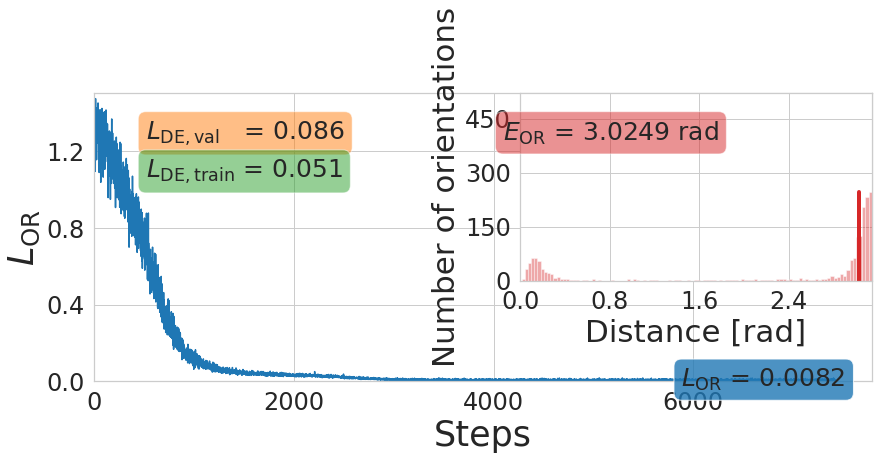

In [259]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.092, 0.17, 0.9, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.5)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(1.06, 0.08, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 520)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.74, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.086:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.051:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_quartercov_uniformS2_noise0_halfInplane_ar_aa.pdf")
plt.show();

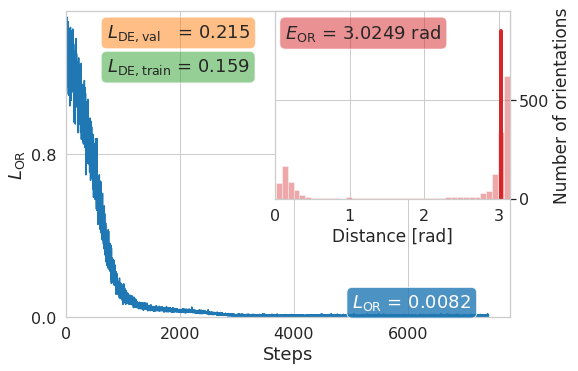

In [260]:
tick_size = 16
label_size = 18
textbox_size=18
label_size_small = 17

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.12, 0.13, 0.77, 0.85])
ax2 = fig.add_axes([0.483, 0.46, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.5)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(2))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(0.47, 0.04, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", color="white", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 950)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
#print(np.arange(0, max_count,1))
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 850,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.35, 0.75, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.03, 0.75, "$L_\mathrm{DE, val}$   = "+f"{0.215:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.03, 0.66, "$L_\mathrm{DE, train}$ = "+f"{0.159:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_quartercov_uniformS2_noise0_halfInplane_ar_aa.pdf")
plt.show();

---

---

## `5a1a` DE - Quarter Coverage Uniform S2 sampling with Noise 0 and Full-cvg OR

In [28]:
import h5py
PROTEIN="5a1a"

projections_filename = f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0/5a1a_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

data = h5py.File(projections_filename, 'r')

angles_true = np.array(data['Angles'])

In [29]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [30]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0/angle_recovery.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)
angles_predicted.shape

TensorShape([1650, 3])

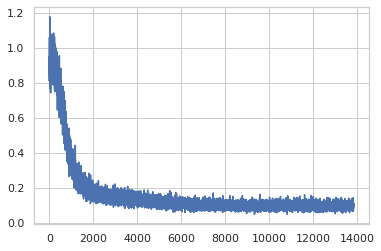

In [36]:
plt.plot(losses[:13850])

In [37]:
losses_plot = losses[:13850]
np.savetxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_noise0.csv', losses_plot)

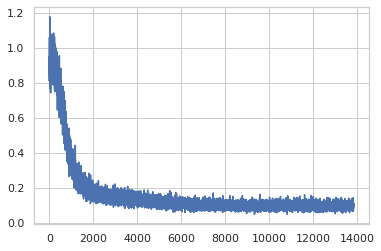

In [38]:
plt.plot(losses_plot)

In [39]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

In [40]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=np.array(angles_true)[test_idx], 
#                                                         angles_predicted=angles_predicted.numpy())

In [43]:
from scipy.spatial.transform import Rotation as R

def d2_symmetry(angles_true):
    for i, a in enumerate(angles_true):
        angles_true[i] = [a[0]%(2*np.pi), a[1]%np.pi, a[2]%(2*np.pi)]
    
    angles_true_transformed = np.zeros(angles_true.shape)
    for i, a in enumerate(angles_true):
        new_a2 = a[2]
        # 1st quarter
        if 0 <= new_a2 <= np.pi/2:
            angles_true_transformed[i] = [a[0], a[1], a[2]]

        # 2nd quarter
        if np.pi/2 <= new_a2 <= np.pi:
            true = R.from_euler('zyz', a)
            rot = R.from_euler('xyz', [np.pi, 0, 0])
            q = true  * rot
            angles_true_transformed[i] = q.as_euler('zyz')
            angles_true_transformed[i] = [angles_true_transformed[i][0]%(2*np.pi), 
                                          angles_true_transformed[i][1]%(np.pi), 
                                          -angles_true_transformed[i][2]%(2*np.pi)]

        # 3rd quarter
        if np.pi < new_a2 <= 3/2*np.pi:  # opposite is the same
            angles_true_transformed[i] = [a[0], a[1], a[2]-np.pi]

        if 3/2*np.pi <= new_a2 <= 2*np.pi:
            true = R.from_euler('zyz', a)
            rot = R.from_euler('xyz', [np.pi, 0, 0])
            q = true  * rot
            angles_true_transformed[i] = q.as_euler('zyz')
            angles_true_transformed[i] = [angles_true_transformed[i][0]%(2*np.pi), 
                                          angles_true_transformed[i][1]%(np.pi), 
                                          np.pi-angles_true_transformed[i][2]%(2*np.pi)]

        #angles_true_transformed[i] = [a[0], a[1], a[2]]
    return angles_true_transformed

In [44]:
angles_true_transformed = d2_symmetry(angles_true)
angles_predicted_transformed = d2_symmetry(angles_predicted.numpy())

In [45]:
m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [4.44576514 ,3.95820701 ,4.80350018 ,0.20936108 ,4.07388142 ,2.00269662] 
loss_first= 1.6603766653167846 
trajectory_last= [26.23408551 ,38.53392209 ,21.37032873, 35.56914994, 16.26206835 ,44.40996013] 
loss_last= 0.9390032044119274

In [46]:
#np.median(d2)

Text(0.02, 0.97, '$E$ = 0.4042 rad')

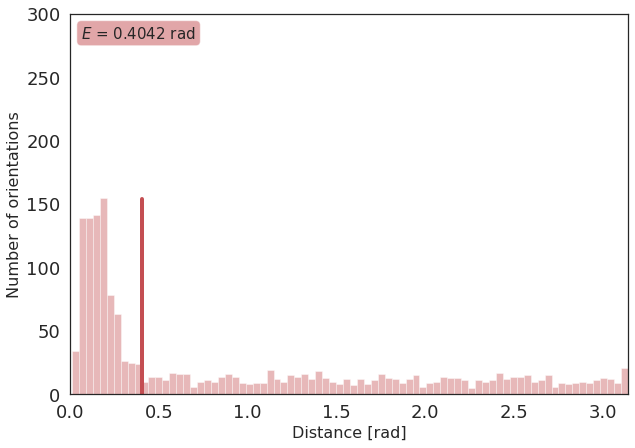

In [47]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64)

d2 = d_q(q_predicted_rot, euler2quaternion(angles_true_transformed[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 300)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.02, 0.97, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

In [48]:
#save just the data for the plot, not the whole pipeline
np.savetxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_noise0.csv', d2)

In [49]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_noise0.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_noise0.csv')
#loss_last= 0.19925397433019346

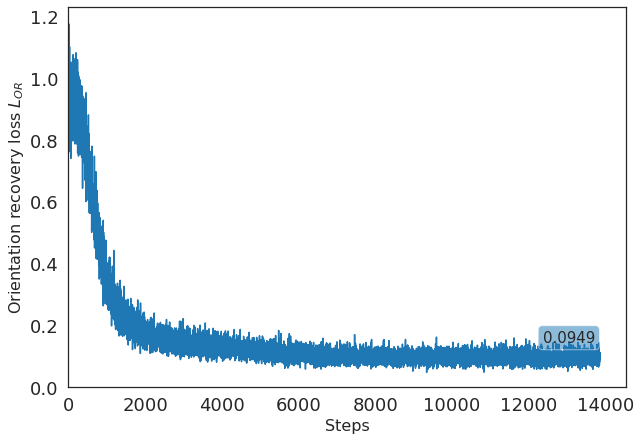

In [50]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.15, f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 0.4042 rad')

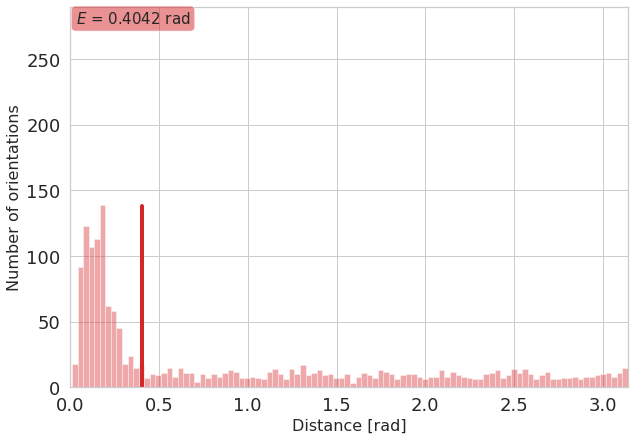

In [52]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 290)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

In [53]:
props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

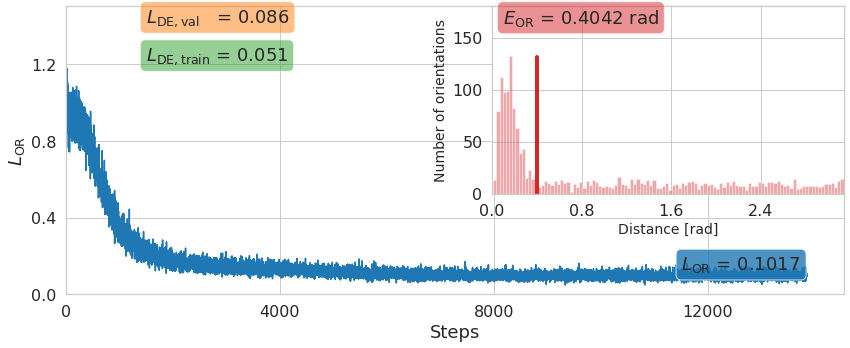

In [54]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.092, 0.17, 0.9, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.5)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(1.06, 0.08, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 180)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.74, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.086:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.051:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_quartercov_uniformS2_noise0_ar_aa.pdf")
plt.show();

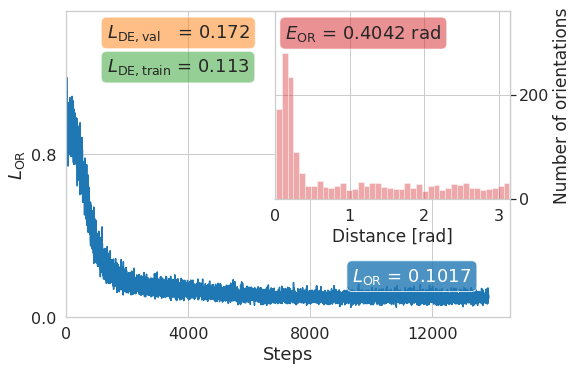

In [59]:
tick_size = 16
label_size = 18
textbox_size=18
label_size_small = 17

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.12, 0.13, 0.77, 0.85])
ax2 = fig.add_axes([0.483, 0.46, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.5)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(2))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(0.47, 0.11, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", color="white", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 360)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = 10#int(max([h.get_height() for h in s.patches]))
# plot median line
#print(np.arange(0, max_count,1))
#ax2.plot([np.median(d2)-0.2]*max_count, np.linspace(0, 350,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.35, 0.75, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.03, 0.75, "$L_\mathrm{DE, val}$   = "+f"{0.1725:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.03, 0.66, "$L_\mathrm{DE, train}$ = "+f"{0.1134:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_quartercov_uniformS2_noise0_ar_aa.pdf")
plt.show();

---

## `5a1a` Quarter Coverage Uniform S2 sampling with Perfect distances

In [281]:
import h5py
PROTEIN="5a1a"

projections_filename = f"../data/results_pipeline_5a1a_quartercov_uniformS2_halfInplane/5a1a_uniform_ProjectionsAngles_ProjNber5000_AngCoverage1.0,0.4,1.0_AngShift0.0,0.0,0.0.h5"

data = h5py.File(projections_filename, 'r')

angles_true = data['Angles']

In [282]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_halfInplane/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [283]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_halfInplane/angle_recovery.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)
angles_predicted.shape

TensorShape([1650, 3])

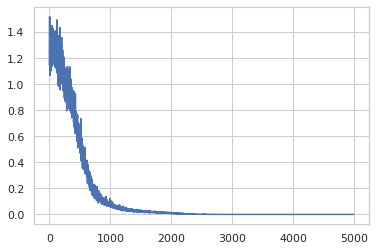

In [284]:
plt.plot(losses[:4990])

In [285]:
losses_plot = losses[:4990]
np.savetxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_halfInplane.csv', losses_plot)

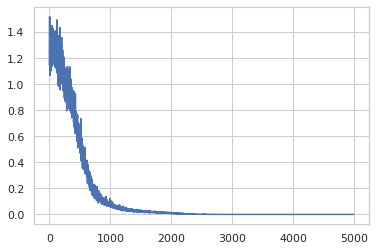

In [286]:
plt.plot(losses_plot)

In [287]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

In [288]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=np.array(angles_true)[test_idx], 
#                                                         angles_predicted=angles_predicted.numpy())

In [289]:
m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [3.28324785 ,4.82066944 ,3.67273171 ,4.30051501, 6.20146876 ,0.90551384] 
loss_first= 2.0940179860519117 
trajectory_last= [-6.42346128 , 9.8084988  , 5.22514841 ,37.89870159, 41.51883345 , 0.18513396] 
loss_last= 0.0028296679100272


In [290]:
#np.median(d2)

Text(0.02, 0.97, '$E$ = 0.0028 rad')

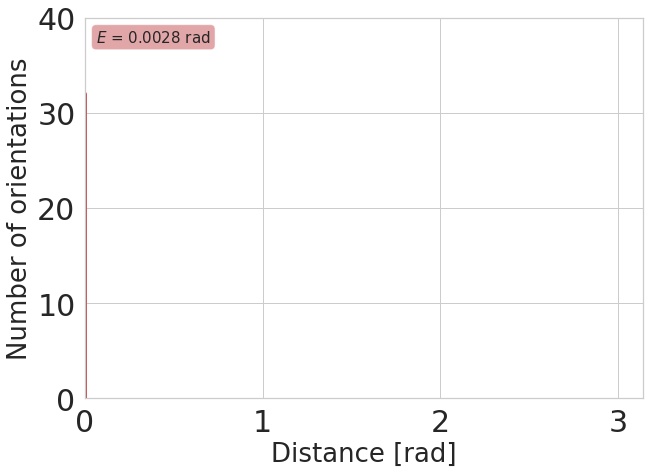

In [291]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64)

d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 40)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.02, 0.97, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

In [292]:
#save just the data for the plot, not the whole pipeline
np.savetxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_halfInplane.csv', d2)

In [293]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_halfInplane.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_halfInplane.csv')
#loss_last= 0.19925397433019346

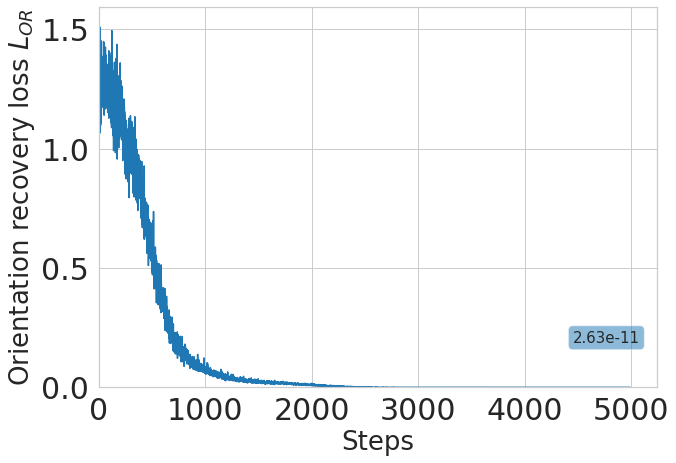

In [294]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.15, f"{np.mean(losses_plot[-20:-10]):.2e}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

In [295]:
tick_size = 22
label_size = 22
textbox_size=22

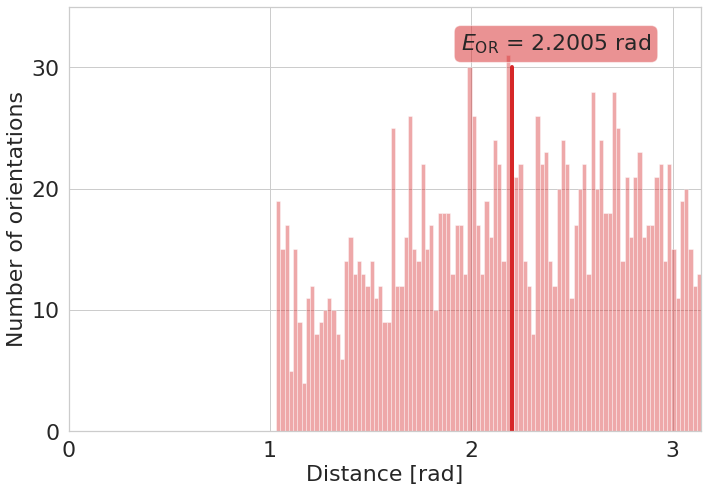

In [296]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted, dtype=tf.float64))
_d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 35)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(_d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = 31  #int(max([h.get_height() for h in s.patches]))
ax.set_ylim((0, 35))
ax.plot([np.median(_d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.62, 0.94, r"$E_\mathrm{OR}$ = "+f"{np.median(_d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
plt.tight_layout()
plt.savefig("pdfs/BeforeAA.pdf")

In [297]:
from cryoem.rotation_matrices import RotationMatrix

def plot_only_selected_in_euclidean_space(angles, angles_true, selected, connection=True):
    ipv.clear()
    aps = RotationMatrix(np.take(angles, selected, axis=0))[:, :3]
    ats = RotationMatrix(np.take(angles_true, selected, axis=0))[:, :3]
    
    if connection:
        connections = np.empty((len(selected)*2, 2, 3))
        connections[:] = np.nan
        connections[::2] = np.stack([ats, aps], axis=1)
        ipv.plot(connections[:, :, 0].flatten(), connections[:, :, 1].flatten(), connections[:, :, 2].flatten(), color="red", lynestyle="--")

    ipv.scatter(ats[:, 0], ats[:, 1], ats[:, 2],
                marker="sphere", color="green", size=1)
    ipv.scatter(aps[:, 0], aps[:, 1], aps[:, 2],
                marker="sphere", color="red", size=1)
    
    ipv.xlim(-1, 1)
    ipv.ylim(-1, 1)
    ipv.zlim(-1, 1)
    ipv.view(90, 45,1.5)
    ipv.show()

In [298]:
#from cryoem.plots import plot_rays, plot_only_selected_in_euclidean_space

angles_pred = quaternion2euler(q_predicted_rot)

#plot_rays(angles_true, indices=range(100))
plot_only_selected_in_euclidean_space(angles_pred, angles_true, selected=range(1000), connection=False)

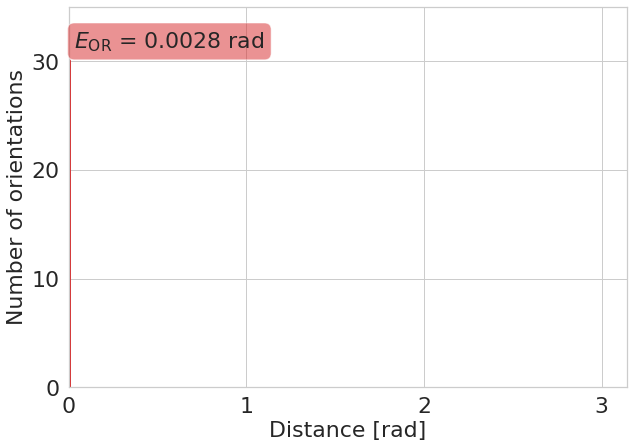

In [299]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64))
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 35)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = 31 #int(max([h.get_height() for h in s.patches]))
ax.set_ylim((0, 35))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.94, r"$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
plt.savefig("pdfs/AfterAA.pdf")

In [300]:
#from cryoem.plots import plot_rays, plot_only_selected_in_euclidean_space

angles_pred = quaternion2euler(q_predicted_rot)

#plot_rays(angles_true, indices=range(100))
plot_only_selected_in_euclidean_space(angles_pred, angles_true, selected=range(1000), connection=False)

In [151]:
props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

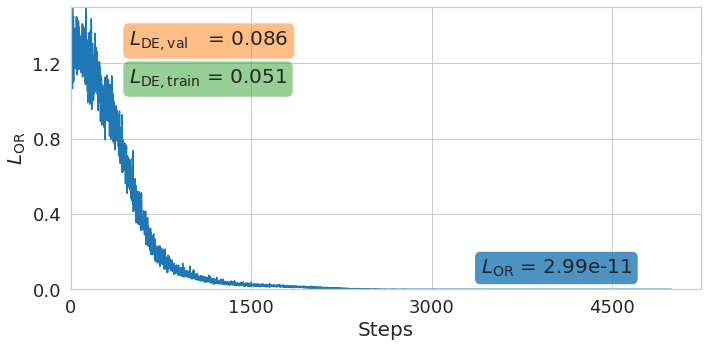

In [260]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
#ax1 = fig.add_axes([0.092, 0.17, 0.65, 0.8])
#ax2 = fig.add_axes([0.435, 0.45, 0.307, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.5)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(0.7, 0.07, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.2e}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 30)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.51, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

#ax1.text(0.07, 0.67, "$L_\mathrm{DE, val}$   = "+f"{0.086:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
#ax1.text(0.07, 0.57, "$L_\mathrm{DE, train}$ = "+f"{0.051:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.tight_layout()
plt.savefig("pdfs/5a1a_quartercov_uniformS2_halfInplane_ar_aa.pdf")
plt.show();

---

## `5a1a` Quarter Coverage Uniform S2 sampling with Perfect distances

In [474]:
import h5py
PROTEIN="5a1a"

projections_filename = f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0_PERFECT/5a1a_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.4_AngShift0.0,0.0,0.0.h5"

data = h5py.File(projections_filename, 'r')

angles_true = data['Angles']

In [475]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0_PERFECT/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [476]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0_PERFECT/angle_recovery.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)
angles_predicted.shape

TensorShape([1650, 3])

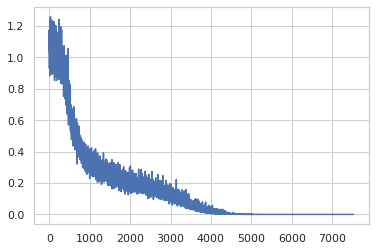

In [477]:
plt.plot(losses[:7530])

In [478]:
losses_plot = losses[:7530]
np.savetxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_perfect.csv', losses_plot)

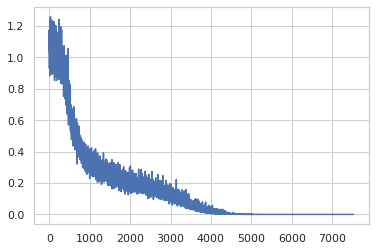

In [479]:
plt.plot(losses_plot)

In [480]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [3.97654419 0.63700068 5.7775043  1.65673284 2.23134892 1.86999115] 
loss_first= 2.1091746125102686 
trajectory_last= [  7.57872261   3.96981037 -11.32778327  25.99371729  28.07214806
  -0.30208768] 
loss_last= 0.0038581772430738752


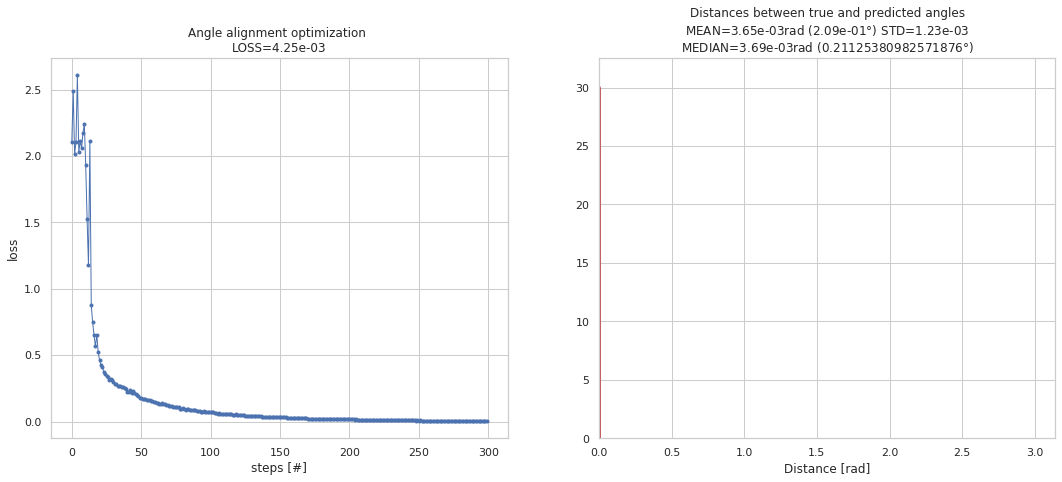

In [490]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=np.array(angles_true)[test_idx], 
                                                        angles_predicted=angles_predicted.numpy())

In [497]:
m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [3.97654419 ,0.63700068 ,5.7775043 , 1.65673284 ,2.23134892 ,1.86999115] 
loss_first= 2.1091746125102686 
trajectory_last= [  7.57872261  , 3.96981037 ,-11.32778327 , 25.99371729 , 28.07214806, -0.30208768] 
loss_last= 0.0038581772430738752

In [498]:
# m= [1.0, 1.0, 1.0, -1.0] 
# trajectory_first= [1.02965785 ,2.64205405 ,2.28131569 ,5.04643507 ,4.88854666 ,0.77038739] 
# loss_first= 2.450347871600699 
# trajectory_last= [  7.54879667  , 7.13950558, -10.66259065 , 18.01545487  ,-2.90641096,-3.44206382] 
# loss_last= 0.010471679658431923

In [499]:
#np.median(d2)

Text(0.02, 0.97, '$E$ = 0.0037 rad')

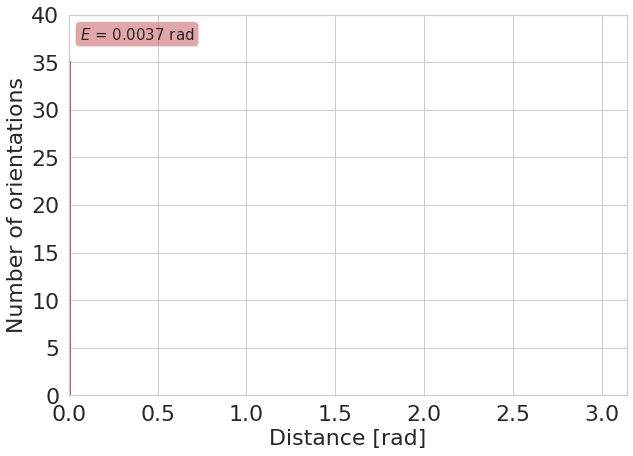

In [500]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64)

d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 40)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.02, 0.97, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

In [501]:
#save just the data for the plot, not the whole pipeline
np.savetxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_perfect.csv', d2)

In [502]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_perfect.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_perfect.csv')
#loss_last= 0.19925397433019346

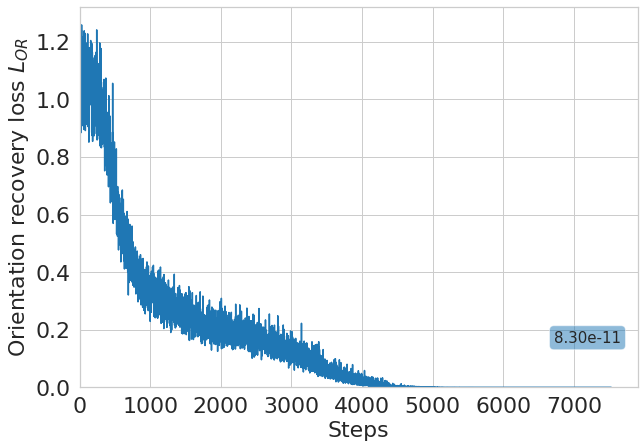

In [503]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.15, f"{np.mean(losses_plot[-20:-10]):.2e}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

In [531]:
tick_size = 25
label_size = 30
textbox_size=32

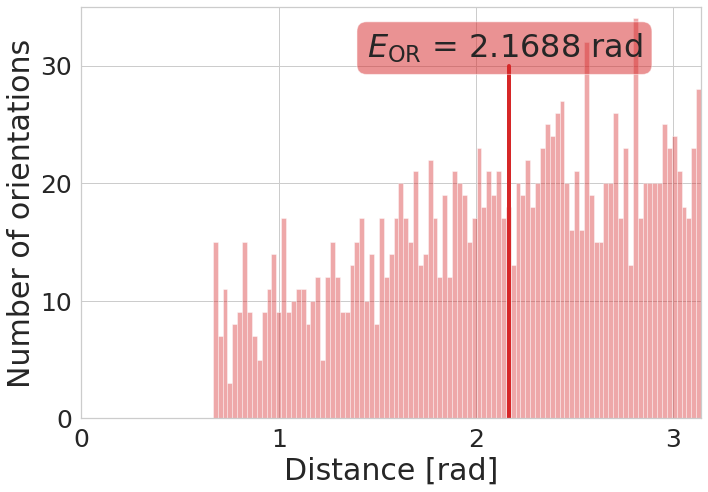

In [535]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted, dtype=tf.float64))
_d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 35)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(_d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = 31  #int(max([h.get_height() for h in s.patches]))
ax.set_ylim((0, 35))
ax.plot([np.median(_d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=label_size)
plt.ylabel("Number of orientations", fontsize=label_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.46, 0.94, r"$E_\mathrm{OR}$ = "+f"{np.median(_d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
plt.tight_layout()
plt.savefig("pdfs/BeforeAA.pdf")

In [506]:
from cryoem.rotation_matrices import RotationMatrix

def plot_only_selected_in_euclidean_space(angles, angles_true, selected, connection=True):
    ipv.clear()
    aps = RotationMatrix(np.take(angles, selected, axis=0))[:, :3]
    ats = RotationMatrix(np.take(angles_true, selected, axis=0))[:, :3]
    
    if connection:
        connections = np.empty((len(selected)*2, 2, 3))
        connections[:] = np.nan
        connections[::2] = np.stack([ats, aps], axis=1)
        ipv.plot(connections[:, :, 0].flatten(), connections[:, :, 1].flatten(), connections[:, :, 2].flatten(), color="red", lynestyle="--")

    ipv.scatter(ats[:, 0], ats[:, 1], ats[:, 2],
                marker="sphere", color="green", size=1)
    ipv.scatter(aps[:, 0], aps[:, 1], aps[:, 2],
                marker="sphere", color="red", size=1)
    
    ipv.xlim(-1, 1)
    ipv.ylim(-1, 1)
    ipv.zlim(-1, 1)
    ipv.view(90, 45,1.5)
    ipv.show()

In [507]:
#from cryoem.plots import plot_rays, plot_only_selected_in_euclidean_space

angles_pred = quaternion2euler(q_predicted_rot)

#plot_rays(angles_true, indices=range(100))
plot_only_selected_in_euclidean_space(angles_pred, angles_true, selected=range(1000), connection=False)

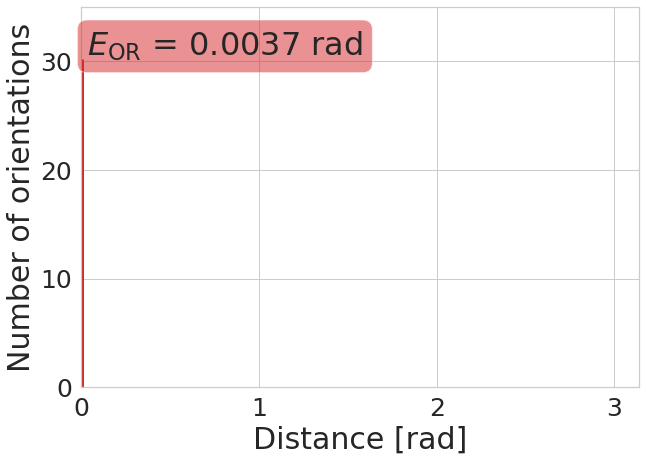

In [536]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64))
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 35)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = 31 #int(max([h.get_height() for h in s.patches]))
ax.set_ylim((0, 35))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=label_size)
plt.ylabel("Number of orientations", fontsize=label_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=tick_size)
ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.94, r"$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
plt.savefig("pdfs/AfterAA.pdf")

In [509]:
#from cryoem.plots import plot_rays, plot_only_selected_in_euclidean_space

angles_pred = quaternion2euler(q_predicted_rot)

#plot_rays(angles_true, indices=range(100))
plot_only_selected_in_euclidean_space(angles_pred, angles_true, selected=range(1000), connection=False)

In [510]:
props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

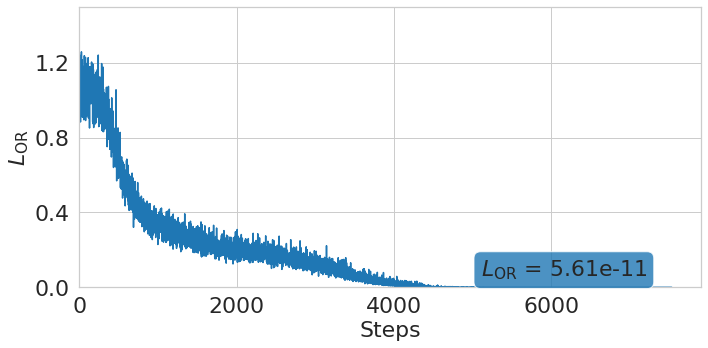

In [511]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
#ax1 = fig.add_axes([0.092, 0.17, 0.65, 0.8])
#ax2 = fig.add_axes([0.435, 0.45, 0.307, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.5)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(0.7, 0.07, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.2e}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
#ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 30)
# plot histogram
# s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
# max_count = int(max([h.get_height() for h in s.patches]))
# # plot median line
# ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
# ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
# ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
# ax2.text(0.51, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
# #ax2.patch.set_facecolor("black")
# #fig.patch.set_facecolor('white')
# ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
# ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
# ax2.tick_params(axis='both', which='major', labelsize=tick_size)

#ax1.text(0.07, 0.67, "$L_\mathrm{DE, val}$   = "+f"{0.086:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
#ax1.text(0.07, 0.57, "$L_\mathrm{DE, train}$ = "+f"{0.051:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.tight_layout()
plt.savefig("pdfs/5a1a_quartercov_uniformS2_perfect_ar_aa.pdf")
plt.show();

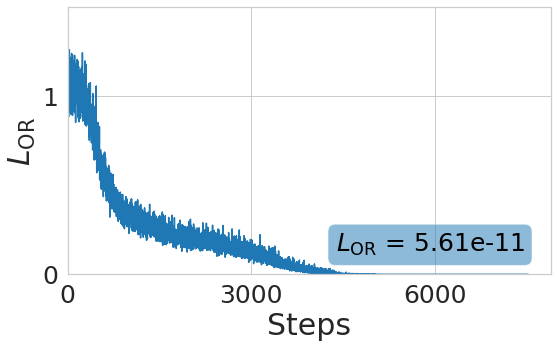

In [523]:
tick_size = 25
label_size = 30
textbox_size=25
label_size_small = 17

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


#fig = plt.figure(figsize=(8, 5))
#fig = plt.figure(figsize=(8.2, 3))
fig, ax1 = plt.subplots(figsize=(8, 5))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
#ax1 = fig.add_axes([0.12, 0.13, 0.77, 0.85])
# ax2 = fig.add_axes([0.483, 0.46, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.5)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(steps=[1]))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.44, 0.14, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.2e}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
# ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 360)
# # plot histogram
# s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
# max_count = 10#int(max([h.get_height() for h in s.patches]))
# plot median line
#print(np.arange(0, max_count,1))
#ax2.plot([np.median(d2)-0.2]*max_count, np.linspace(0, 350,max_count), c=TEST_COLOR_EOR, lw=4)
# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position("right")
# ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
# ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# # We change the fontsize of minor ticks label 
# props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# # place a text box in upper left in axes coords
# ax2.text(0.35, 0.75, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
# #ax2.patch.set_facecolor("black")
# #fig.patch.set_facecolor('white')
# ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
# ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
# ax2.tick_params(axis='both', which='major', labelsize=tick_size)

# ax1.text(0.03, 0.75, "$L_\mathrm{DE, val}$   = "+f"{0.1725:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
# ax1.text(0.03, 0.66, "$L_\mathrm{DE, train}$ = "+f"{0.1134:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.tight_layout()
plt.savefig("pdfs/5a1a_quartercov_uniformS2_perfect_ar_aa.pdf")
plt.show();

---

## `5a1a` Quarter Coverage Uniform S2 sampling with Noise 0 LATEST

In [30]:
import h5py
PROTEIN="5a1a"

projections_filename = f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0/5a1a_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.4_AngShift0.0,0.0,0.0.h5"

data = h5py.File(projections_filename, 'r')

angles_true = data['Angles']

In [31]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [32]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise0/angle_recovery.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)
angles_predicted.shape

TensorShape([1650, 3])

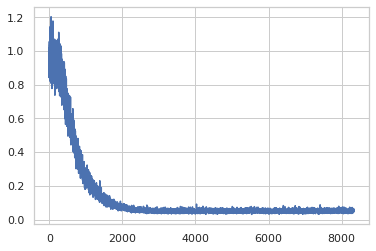

In [34]:
plt.plot(losses[:8330])

In [35]:
losses_plot = losses[:8330]
np.savetxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_noise0_LAST.csv', losses_plot)

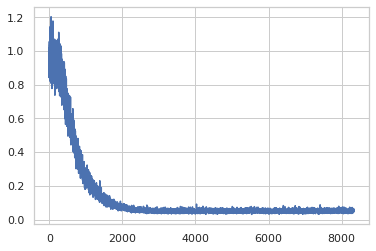

In [36]:
plt.plot(losses_plot)

In [37]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

In [38]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=np.array(angles_true)[test_idx], 
#                                                         angles_predicted=angles_predicted.numpy())

In [39]:
m= [1.0, 1.0, 1.0, 1.0] 
trajectory_first= [0.52933976, 3.05966377 ,3.33140294, 1.30740198 ,1.84920131, 2.83804645] 
loss_first= 2.047569392574239 
trajectory_last= [-29.27182096 ,-15.71352812 ,  5.34588988,  36.43967498,  7.1815495,11.18016876] 
loss_last= 0.20675683332566855

In [40]:
#np.median(d2)

Text(0.02, 0.97, '$E$ = 0.1264 rad')

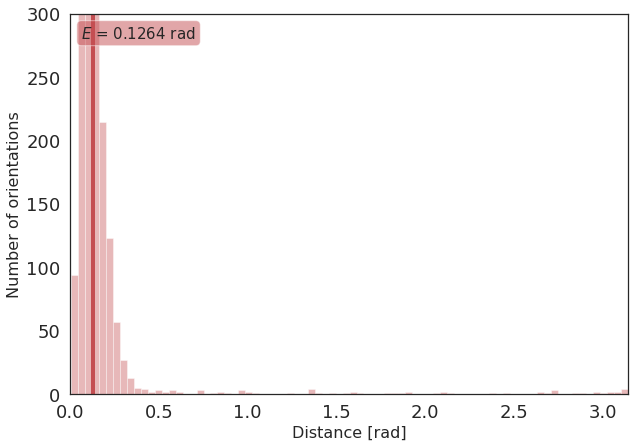

In [41]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64)

d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 300)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.02, 0.97, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

In [42]:
#save just the data for the plot, not the whole pipeline
np.savetxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_noise0_LAST.csv', d2)

In [283]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_noise0_LAST.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_noise0_LAST.csv')
#loss_last= 0.19925397433019346

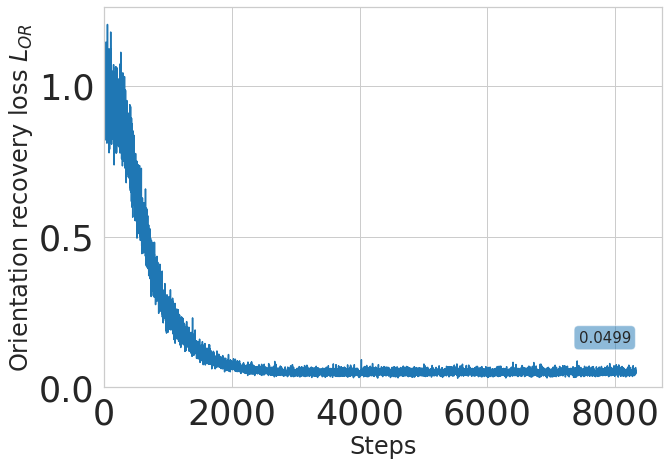

In [284]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.15, f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 0.1264 rad')

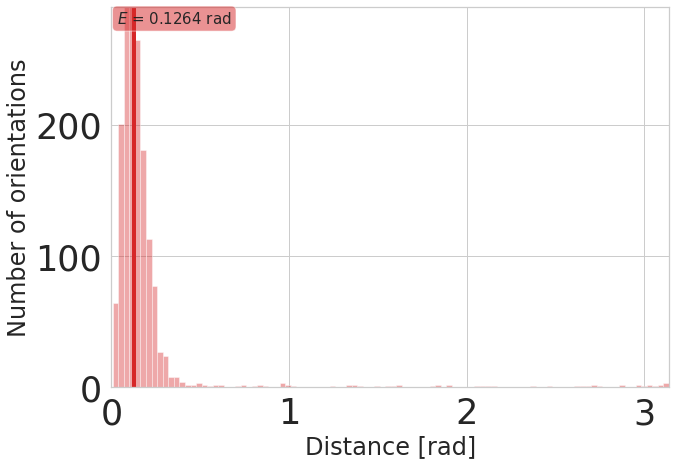

In [285]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 290)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

In [286]:
props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

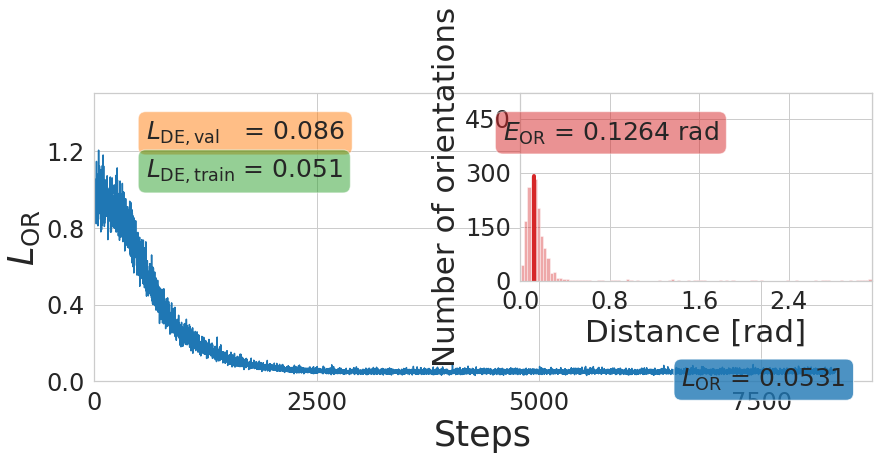

In [287]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.092, 0.17, 0.9, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.5)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(1.06, 0.08, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 520)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.74, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.086:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.051:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_quartercov_uniformS2_noise0_LAST_ar_aa.pdf")
plt.show();

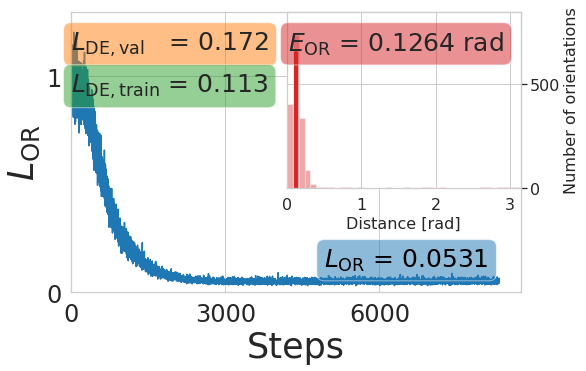

In [292]:
tick_size = 24
tick_size_small = 16
label_size = 35
textbox_size=25
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.11, 0.2, 0.78, 0.78])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.42, 0.16, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 650,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.355, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(-0.034, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.172:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(-0.034, 0.62, "$L_\mathrm{DE, train}$ = "+f"{0.113:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_quartercov_uniformS2_noise0_LAST_ar_aa.pdf")
plt.show();

---

## `5a1a` Quarter Coverage Uniform S2 sampling with Noise 16 LATEST

In [33]:
import h5py
PROTEIN="5a1a"

projections_filename = f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise16/5a1a_uniform_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.4_AngShift0.0,0.0,0.0.h5"

data = h5py.File(projections_filename, 'r')

angles_true = data['Angles']

In [34]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise16/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data['arr_0'], data['arr_1'], data['arr_2']

In [ ]:
data = np.load(f"../data/results_pipeline_5a1a_quartercov_uniformS2_noise16/angle_recovery.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)
angles_predicted.shape

In [1]:
plt.plot(losses[:17570])

NameError: name 'plt' is not defined

In [13]:
losses_plot = losses[:17570]
np.savetxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_noise16_LAST.csv', losses_plot)

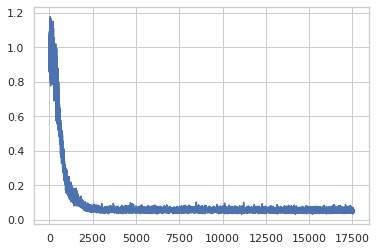

In [14]:
plt.plot(losses_plot)

In [15]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

In [16]:
# m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
#                                                         steps=300, 
#                                                         batch_size=256, 
#                                                         optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
#                                                         angles_true=np.array(angles_true)[test_idx], 
#                                                         angles_predicted=angles_predicted.numpy())

In [17]:
m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [1.83142675 ,6.211531  , 4.83411248, 0.5488734 , 5.32406159, 0.24812518] 
loss_first= 2.216163178982548 
trajectory_last= [ -3.17271922 , -3.46359059  ,31.58886814, -16.56551642 , 21.54259749,  20.26241948] 
loss_last= 0.21476936588068427

In [18]:
#np.median(d2)

NameError: name 'tick_size' is not defined

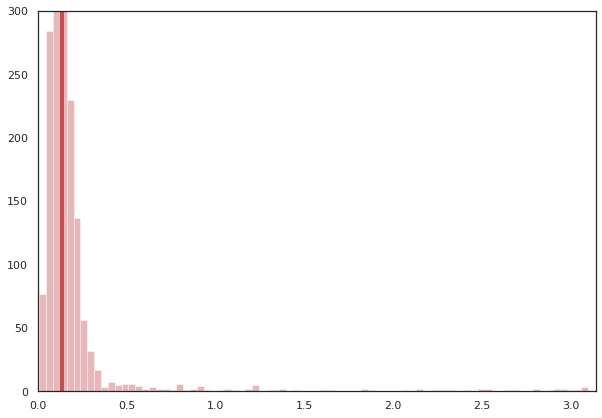

In [19]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted, dtype=tf.float64)

d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 300)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.02, 0.97, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

In [20]:
#save just the data for the plot, not the whole pipeline
np.savetxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_noise16_LAST.csv', d2)

In [293]:
losses_plot = np.loadtxt(f'{DATA_DIR}/5a1a_LOR_quartercov_uniformS2_noise16_LAST.csv')
d2 = np.loadtxt(f'{DATA_DIR}/5a1a_EOR_quartercov_uniformS2_noise16_LAST.csv')
#loss_last= 0.19925397433019346

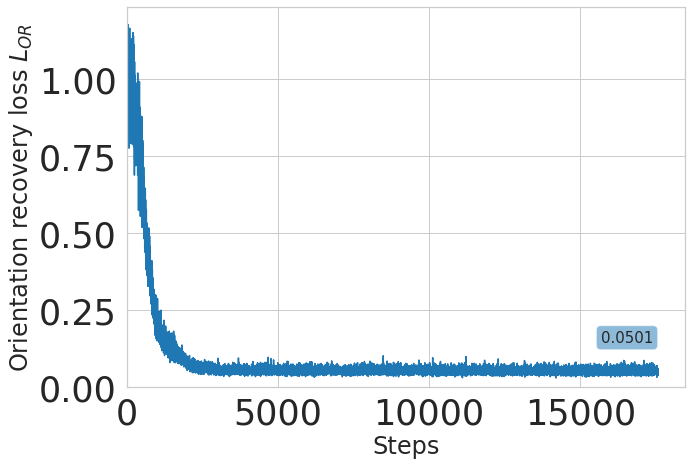

In [294]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(losses_plot, c=TEST_COLOR_LOR) # np.arange(0., 0.474*len(losses[losses>1e-5]), 0.474),
plt.xlabel("Steps", fontsize=tick_size)
plt.ylabel("Orientation recovery loss $L_{OR}$", fontsize=tick_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)
ax.set_xlim(0)
ax.set_ylim(0)

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.85, 0.15, f"{np.mean(losses_plot[-20:-10]):.4f}", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_recovery.pdf")
plt.show()

Text(0.01, 0.99, '$E$ = 0.1347 rad')

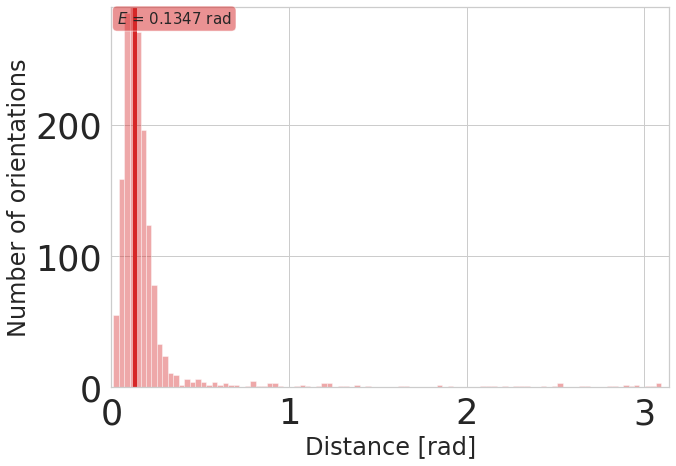

In [295]:
fig, ax = plt.subplots(figsize=(10,7))
# # Distance count subplot (full)
# q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted[test_idx], dtype=tf.float64))
#d2 = d_q(q_predicted_rot, euler2quaternion(angles_true[test_idx]))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 290)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=100, ax=ax, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.01, 0.99, f"$E$ = {np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
#plt.savefig("pdfs/5a1a_noise0_angle_alignment_after.pdf")

In [296]:
props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)

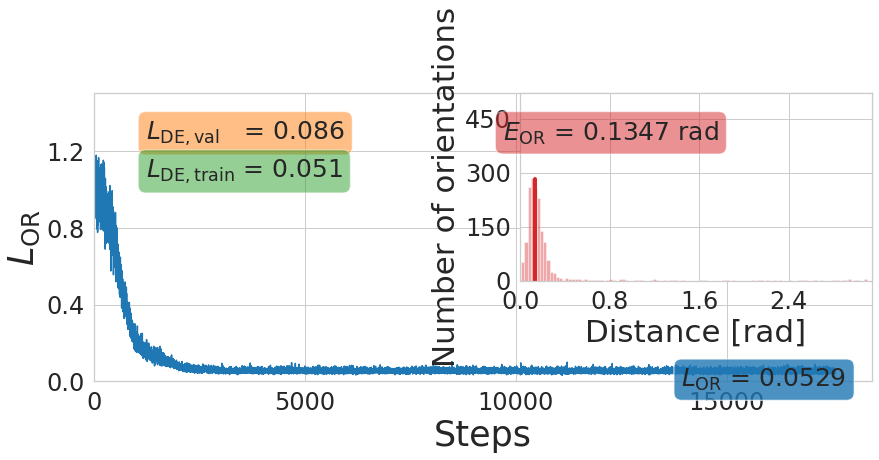

In [297]:
fig = plt.figure(figsize=(12, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.092, 0.17, 0.9, 0.8])
ax2 = fig.add_axes([0.585, 0.45, 0.407, 0.52], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.5)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(1.06, 0.08, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-10:]):.4f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 520)
# plot histogram
s = sns.distplot(d2, kde=False, bins=110, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c=TEST_COLOR_EOR, lw=4)
ax2.set_xlabel("Distance [rad]", fontsize=label_size-4)
ax2.set_ylabel("Number of orientations", fontsize=label_size-4)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.74, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

ax1.text(0.1, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.086:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.1, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.051:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_quartercov_uniformS2_noise16_LAST_ar_aa.pdf")
plt.show();

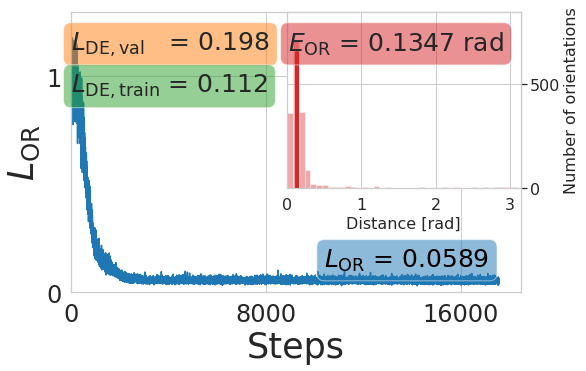

In [300]:
tick_size = 24
tick_size_small = 16
label_size = 35
textbox_size=25
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.11, 0.2, 0.78, 0.78])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.3)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.yaxis.set_major_locator(plt.MaxNLocator(1))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.5)
# place a text box in upper left in axes coords
ax1.text(0.42, 0.16, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-1:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 850)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 650,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.355, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(-0.034, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.198:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(-0.034, 0.62, "$L_\mathrm{DE, train}$ = "+f"{0.1124:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_quartercov_uniformS2_noise16_LAST_ar_aa.pdf")
plt.show();

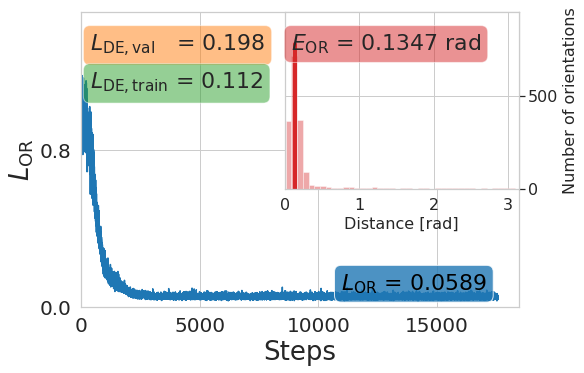

In [298]:
tick_size = 20
tick_size_small=16
label_size = 26
textbox_size=22
label_size_small = 16

props1 = dict(boxstyle='round', facecolor=TRAIN_COLOR, alpha=0.5)
props2 = dict(boxstyle='round', facecolor=VAL_COLOR, alpha=0.5)


fig = plt.figure(figsize=(8, 5))
#fig = plt.figure(figsize=(8.2, 3))
#fig.patch.set_facecolor('white') 
#plt.rcParams['figure.facecolor'] = 'white'
ax1 = fig.add_axes([0.13, 0.16, 0.76, 0.82])
ax2 = fig.add_axes([0.484, 0.49, 0.406, 0.49], facecolor="white")

ax1.plot(losses_plot, c=TEST_COLOR_LOR) 
ax1.set_xlabel("Steps", fontsize=label_size)
ax1.set_ylabel("$L_\mathrm{OR}$", fontsize=label_size)

ax1.set_xlim(0)
ax1.set_ylim(0,1.5)
#ax1.patch.set_facecolor("white")
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(2))

props = dict(boxstyle='round', facecolor=TEST_COLOR_LOR, alpha=0.8)
# place a text box in upper left in axes coords
ax1.text(0.45, 0.1, "$L_\mathrm{OR}$ = "+f"{np.mean(losses_plot[-1:]):.4f}", color="black", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)

### histogram
ax2.set_xlim(0, np.pi);ax2.set_ylim(0, 950)
# plot histogram
s = sns.distplot(d2, kde=False, bins=40, ax=ax2, color=TEST_COLOR_EOR)
max_count = int(max([h.get_height() for h in s.patches]))
# plot median line
#print(np.arange(0, max_count,1))
ax2.plot([np.median(d2)]*max_count, np.linspace(0, 780,max_count), c=TEST_COLOR_EOR, lw=4)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_xlabel("Distance [rad]", fontsize=label_size_small)
ax2.set_ylabel("Number of orientations", fontsize=label_size_small)
# We change the fontsize of minor ticks label 
props = dict(boxstyle='round', facecolor=TEST_COLOR_EOR, alpha=0.5)
# place a text box in upper left in axes coords
ax2.text(0.36, 0.73, "$E_\mathrm{OR}$ = "+f"{np.median(d2):.4f} rad", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props)
#ax2.patch.set_facecolor("black")
#fig.patch.set_facecolor('white')
ax2.xaxis.set_major_locator(plt.MaxNLocator(steps=[1,2,3]))
ax2.yaxis.set_major_locator(plt.MaxNLocator(2))
ax2.tick_params(axis='both', which='major', labelsize=tick_size_small)

ax1.text(0.0, 0.73, "$L_\mathrm{DE, val}$   = "+f"{0.198:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props2)
ax1.text(0.0, 0.63, "$L_\mathrm{DE, train}$ = "+f"{0.1124:.3f}", transform=ax.transAxes, fontsize=textbox_size, verticalalignment='top', bbox=props1)


# tightlayout does not work here
plt.savefig("pdfs/5a1a_quartercov_uniformS2_noise16_LAST_ar_aa.pdf")
plt.show();

---

---

## `5j0n` Projections with Perturbations

In [74]:
PROTEIN = '5j0n'
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

data = h5py.File(os.path.join(DATA_DIR, projections_filename), 'r')
projections = data['Projections']
angles = data['Angles']

In [75]:
from cryoem.plots import plot_projection

In [76]:
# fg_color = 'white'
# bg_color = 'black'


In [77]:
# def _plot(image, title, ax, colorbar=False, mean=0, var=0):
#     im = ax.imshow(image)
  
#     # set title plus title color
#     ax.set_title(title, color=fg_color)

#     # set figure facecolor
#     ax.patch.set_facecolor(bg_color)

#     # set tick and ticklabel color
#     im.axes.tick_params(color=fg_color, labelcolor=fg_color)

#     # set imshow outline
#     for spine in im.axes.spines.values():
#         spine.set_edgecolor(fg_color)    

#     if colorbar:
#         cb = plt.colorbar(im)
#         # set colorbar label plus label color
#         cb.set_label('Closeness', color=fg_color)

#         # set colorbar tick color
#         cb.ax.yaxis.set_tick_params(color=fg_color)

#         # set colorbar edgecolor 
#         cb.outline.set_edgecolor(fg_color)

#         # set colorbar ticklabels
#         plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color)

In [78]:

# def plot_projection(projection, angles, fg_color = 'white', bg_color = 'black', colorbar=True):
#     # NOTE: used
#     projection = np.squeeze(projection)

#     fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    
#     _plot(projection, f"Angles: {', '.join([f'{x:.2f}' for x in angles])} [rad]", ax, colorbar=True)

#     fig.patch.set_facecolor(bg_color) 
#     plt.tight_layout()
#     plt.show()

In [79]:
from cryoem.preprocessing import preprocessing

In [80]:
_projections = preprocessing(projections, rescale_dim=116, noise_var_scale=0, left_limit=0, peak_limit=0, right_limit=0, channels=1, dtype=np.float32)

<class 'numpy.float64'>
Preprocessing projections
	Noise:
		No noise
	Translation:
		No translation
	Image rescaled: 
		from dimension 116 to 116
	Global standardization
		Image shape: (116, 116)
		Data Type: float64
		Mean: 0.262 | Std: 1.046
		Min:  0.000 | Max: 15.458
		Mean: 0.000 | Std: 1.000
		Min:  -0.250 | Max: 14.526
<class 'numpy.float32'>
<class 'numpy.float32'>


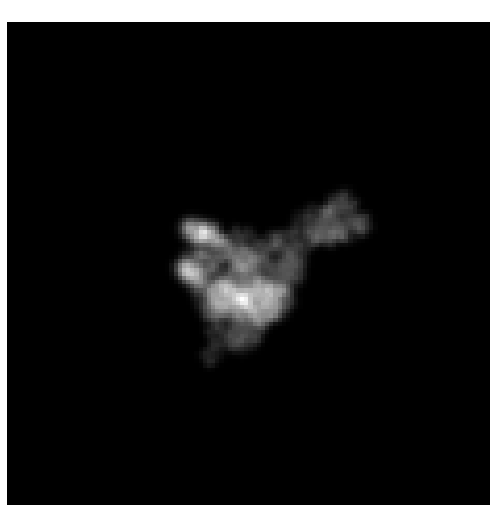

In [81]:
plot_projection(projection=_projections[1], angles=angles[1], bg_color='white', colorbar=False)

In [82]:
_projections = preprocessing(projections, rescale_dim=116, noise_var_scale=16, left_limit=0, peak_limit=0, right_limit=0, channels=1, dtype=np.float32)

<class 'numpy.float64'>
Preprocessing projections
	Noise:
		Variance= 247.32705688476562
	Translation:
		No translation
	Image rescaled: 
		from dimension 116 to 116
	Global standardization
		Image shape: (116, 116)
		Data Type: float64
		Mean: 0.262 | Std: 15.762
		Min:  -85.951 | Max: 87.593
		Mean: 0.000 | Std: 1.000
		Min:  -5.470 | Max: 5.541
<class 'numpy.float32'>
<class 'numpy.float32'>


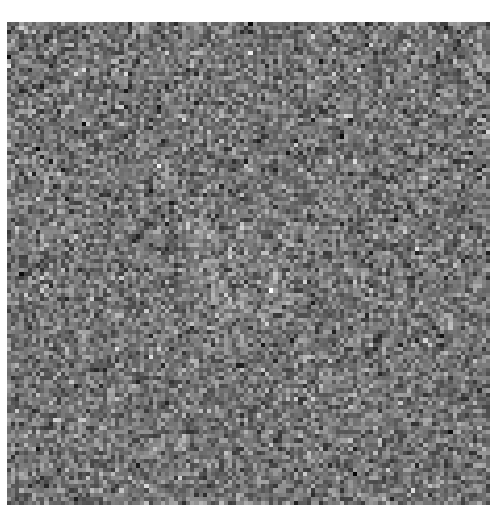

In [83]:
plot_projection(projection=_projections[1], angles=angles[1], bg_color='white', colorbar=False)

In [84]:
_projections = preprocessing(projections, rescale_dim=116, noise_var_scale=0, left_limit=-30, peak_limit=-30, right_limit=0, channels=1, dtype=np.float32)

<class 'numpy.float64'>
Preprocessing projections
	Noise:
		No noise
	Translation:
		left_limit=-30, peak_limit=-30, right_limit=0
	Image rescaled: 
		from dimension 116 to 116
	Global standardization
		Image shape: (116, 116)
		Data Type: float64
		Mean: 0.262 | Std: 1.046
		Min:  0.000 | Max: 15.458
		Mean: 0.000 | Std: 1.000
		Min:  -0.250 | Max: 14.526
<class 'numpy.float32'>
<class 'numpy.float32'>


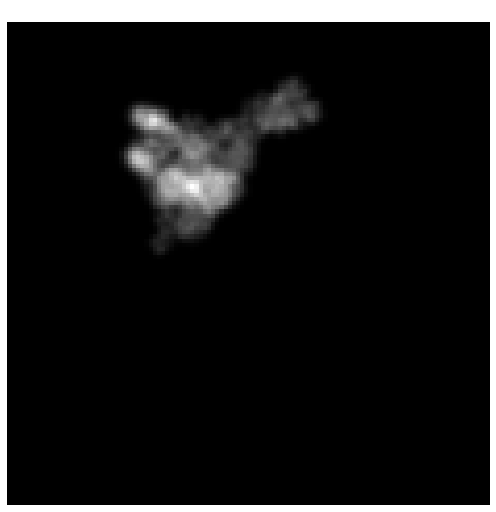

In [85]:
plot_projection(projection=_projections[1], angles=angles[1], bg_color='white', colorbar=False)

In [86]:
_projections = preprocessing(projections, rescale_dim=116, noise_var_scale=16, left_limit=-30, peak_limit=-30, right_limit=0, channels=1, dtype=np.float32)

<class 'numpy.float64'>
Preprocessing projections
	Noise:
		Variance= 247.32705688476562
	Translation:
		left_limit=-30, peak_limit=-30, right_limit=0
	Image rescaled: 
		from dimension 116 to 116
	Global standardization
		Image shape: (116, 116)
		Data Type: float64
		Mean: 0.264 | Std: 15.762
		Min:  -87.285 | Max: 88.037
		Mean: 0.000 | Std: 1.000
		Min:  -5.555 | Max: 5.569
<class 'numpy.float32'>
<class 'numpy.float32'>


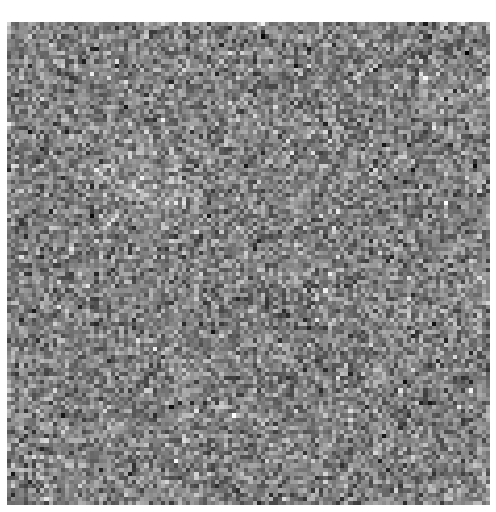

In [87]:
plot_projection(projection=_projections[1], angles=angles[1], bg_color='white', colorbar=False)

---

In [7]:
label_size = 28
legend_size=24
tick_size=25
textbox_size = 26

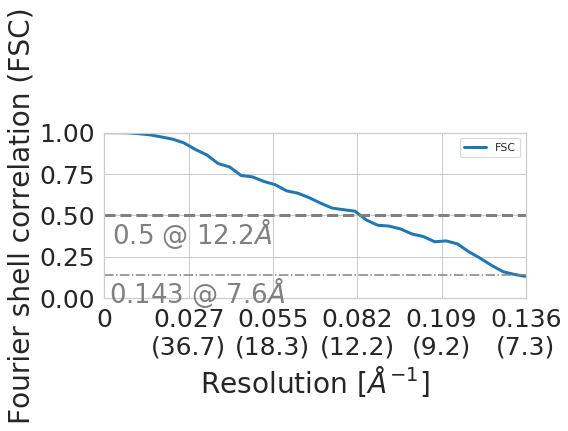

In [8]:
from xml.dom import minidom

# parse an xml file by name
mydoc = minidom.parse(f'{DATA_DIR}/5j0n_fullcvg_uniformS2_noise0_FSC_apr_init.xml')

X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')

x = list(map(lambda i: float(i.firstChild.data), X))
y = list(map(lambda i: float(i.firstChild.data), Y))


fig, ax1 = plt.subplots(figsize=(8, 5))

c1 = "gray"#u'#ff7f0e'
c2 = "gray"#u'#2ca02c'

ax1.plot(x, y, c=TEST_COLOR_LOR, label="FSC", lw=3) 
ax1.set_xlabel(r"Resolution [$\AA^{-1}$]", fontsize=label_size)
ax1.set_ylabel("Fourier shell correlation (FSC)", fontsize=label_size)
ax1.plot(x, np.ones(len(x))*0.5, ls="--", lw=3,color=c1)
ax1.plot(x, np.ones(len(x))*0.143, ls="-.", color=c2)

ax1.set_ylim(0,1);ax1.set_xlim(0,max(x))

# TODO:
ticks = np.linspace(0, max(x), 6)
labels = list(map(lambda x: f"{x:.3f}\n({1/x:.1f})" if x!=0 else "0", ticks))

ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
plt.xticks(ticks, labels)  # Set text labels and properties.

# TODO:
ax1.text(0, 0.5, r" 0.5 @ 12.2$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=c1)
ax1.text(0.01, 0.14, r"0.143 @ 7.6$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=c2)

plt.tight_layout()
plt.savefig("pdfs/5j0n_fullcvg_uniformS2_noise0_FSC_apr_init_customFSC.pdf")

plt.legend()

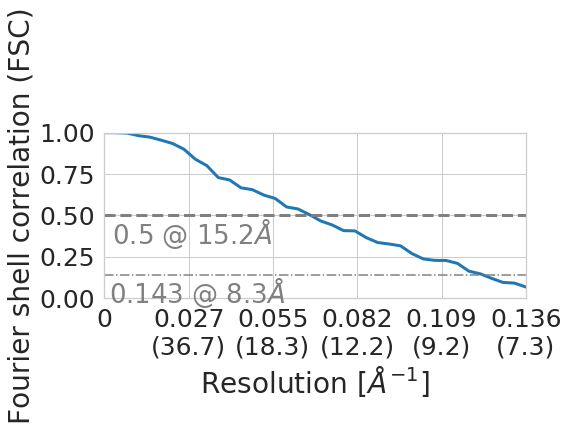

In [9]:
from xml.dom import minidom

# parse an xml file by name
mydoc = minidom.parse(f'{DATA_DIR}/5j0n_fullcvg_uniformS2_noise16_FSC_apr_init.xml')

X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')

x = list(map(lambda i: float(i.firstChild.data), X))
y = list(map(lambda i: float(i.firstChild.data), Y))


fig, ax1 = plt.subplots(figsize=(8, 5))

c1 = "gray"#u'#ff7f0e'
c2 = "gray"#u'#2ca02c'

ax1.plot(x, y, c=TEST_COLOR_LOR, label="FSC", lw=3) 
ax1.set_xlabel(r"Resolution [$\AA^{-1}$]", fontsize=label_size)
ax1.set_ylabel("Fourier shell correlation (FSC)", fontsize=label_size)
ax1.plot(x, np.ones(len(x))*0.5, ls="--", lw=3,color=c1)
ax1.plot(x, np.ones(len(x))*0.143, ls="-.", color=c2)

ax1.set_ylim(0,1);ax1.set_xlim(0,max(x))

# TODO:
ticks = np.linspace(0, max(x), 6)
labels = list(map(lambda x: f"{x:.3f}\n({1/x:.1f})" if x!=0 else "0", ticks))

ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(4))
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
plt.xticks(ticks, labels)  # Set text labels and properties.

# TODO:
ax1.text(0, 0.5, r" 0.5 @ 15.2$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=c1)
ax1.text(0.01, 0.14, r"0.143 @ 8.3$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=c2)

plt.tight_layout()
plt.savefig("pdfs/5j0n_fullcvg_uniformS2_noise16_FSC_apr_init_customFSC.pdf")

#plt.legend()

In [56]:
label_size = 34
legend_size=24
tick_size=28
textbox_size = 32

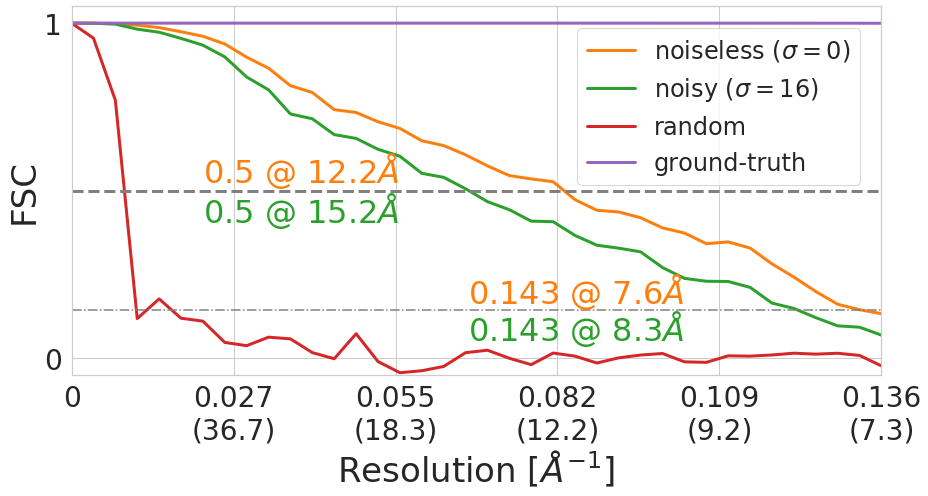

In [75]:
from xml.dom import minidom
legend_size=24
# parse an xml file by name
mydoc = minidom.parse(f'{DATA_DIR}/5j0n_fullcvg_uniformS2_noise0_FSC_apr_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x1 = list(map(lambda i: float(i.firstChild.data), X))
y1 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{DATA_DIR}/5j0n_fullcvg_uniformS2_noise16_FSC_apr_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x2 = list(map(lambda i: float(i.firstChild.data), X))
y2 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{DATA_DIR}/5j0n_fullcvg_uniformS2_noise0_FSC_rand_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x3 = list(map(lambda i: float(i.firstChild.data), X))
y3 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{DATA_DIR}/5j0n_fullcvg_uniformS2_noise0_FSC_gt_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x4 = list(map(lambda i: float(i.firstChild.data), X))
y4 = list(map(lambda i: float(i.firstChild.data), Y))



fig, ax1 = plt.subplots(figsize=(13, 7))

c1 = "gray"#u'#ff7f0e'
c2 = "gray"#u'#2ca02c'

color1 = u'#ff7f0e'
color2 = u'#2ca02c'
color3 = u'#d62728'
color4 = u'#9467bd'

ax1.plot(x1, y1, c=color1, label="noiseless ($\sigma=0$)", lw=3) 
ax1.plot(x2, y2, c=color2, label="noisy ($\sigma=16$)", lw=3) 
ax1.plot(x3, y3, c=color3, label="random", lw=3) 
ax1.plot(x4, y4, c=color4, label="ground-truth", lw=3) 
ax1.set_xlabel(r"Resolution [$\AA^{-1}$]", fontsize=label_size)
ax1.set_ylabel("FSC", fontsize=label_size)
ax1.plot(x1, np.ones(len(x1))*0.5, ls="--", lw=3,color=c1)
ax1.plot(x1, np.ones(len(x1))*0.143, ls="-.", color=c2)

ax1.set_ylim(-0.05,1.05);ax1.set_xlim(0,max(x1))

# TODO:
ticks = np.linspace(0, max(x1), 6)
labels = list(map(lambda x: f"{x:.3f}\n({1/x:.1f})" if x!=0 else "0", ticks))

ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
plt.xticks(ticks, labels)  # Set text labels and properties.

# TODO:
ax1.text(0.15, 0.61, r" 0.5 @ 12.2$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=color1)
ax1.text(0.49, 0.28, r"0.143 @ 7.6$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=color1)
ax1.text(0.15, 0.5, r" 0.5 @ 15.2$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=color2)
ax1.text(0.49, 0.18, r"0.143 @ 8.3$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', color=color2)


plt.tight_layout()
plt.legend(fontsize=legend_size, borderaxespad=0.9)
plt.savefig("pdfs/5j0n_fullcvg_uniformS2_FSC_apr_init_customFSC2.pdf")

legend_size=24

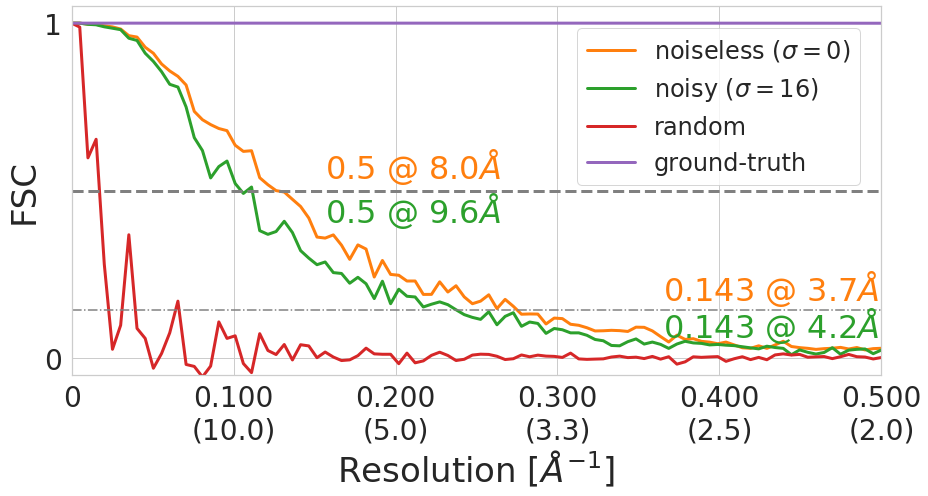

In [76]:
from xml.dom import minidom
legend_size=24
# parse an xml file by name
mydoc = minidom.parse(f'{DATA_DIR}/5a1a_quartercov_uniformS2_noise0_FSC_apr_init2.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x1 = list(map(lambda i: float(i.firstChild.data), X))
y1 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{DATA_DIR}/5a1a_quartercov_uniformS2_noise16_FSC_apr_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x2 = list(map(lambda i: float(i.firstChild.data), X))
y2 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{DATA_DIR}/5a1a_quartercvg_uniformS2_noise0_FSC_rand_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x3 = list(map(lambda i: float(i.firstChild.data), X))
y3 = list(map(lambda i: float(i.firstChild.data), Y))
# parse an xml file by name
mydoc = minidom.parse(f'{DATA_DIR}/5a1a_quartercvg_uniformS2_noise0_FSC_gt_init.xml')
X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')
x4 = list(map(lambda i: float(i.firstChild.data), X))
y4 = list(map(lambda i: float(i.firstChild.data), Y))



fig, ax1 = plt.subplots(figsize=(13, 7))

c1 = "gray"#u'#ff7f0e'
c2 = "gray"#u'#2ca02c'

color1 = u'#ff7f0e'
color2 = u'#2ca02c'
color3 = u'#d62728'
color4 = u'#9467bd'

ax1.plot(x1, y1, c=color1, label="noiseless ($\sigma=0$)", lw=3) 
ax1.plot(x2, y2, c=color2, label="noisy ($\sigma=16$)", lw=3) 
ax1.plot(x3, y3, c=color3, label="random", lw=3) 
ax1.plot(x4, y4, c=color4, label="ground-truth", lw=3) 
ax1.set_xlabel(r"Resolution [$\AA^{-1}$]", fontsize=label_size)
ax1.set_ylabel("FSC", fontsize=label_size)
ax1.plot(x1, np.ones(len(x1))*0.5, ls="--", lw=3,color=c1)
ax1.plot(x1, np.ones(len(x1))*0.143, ls="-.", color=c2)

ax1.set_ylim(-0.05,1.05);ax1.set_xlim(0,max(x1))


# TODO:
ticks = np.linspace(0, max(x1), 6)
labels = list(map(lambda x: f"{x:.3f}\n({1/x:.1f})" if x!=0 else "0", ticks))

ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
plt.xticks(ticks, labels)  # Set text labels and properties.

# TODO:
ax1.text(0.3, 0.62, r" 0.5 @ 8.0$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color1)
ax1.text(0.73, 0.29, r"0.143 @ 3.7$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color1)

ax1.text(0.3, 0.5, r" 0.5 @ 9.6$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color2)
ax1.text(0.73, 0.19, r"0.143 @ 4.2$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color2)


plt.tight_layout()
plt.legend(fontsize=legend_size, borderaxespad=0.9)
plt.savefig("pdfs/5a1a_quartercvg_uniformS2_noise0_FSC_apr_init_customFSC2.pdf")
legend_size=24

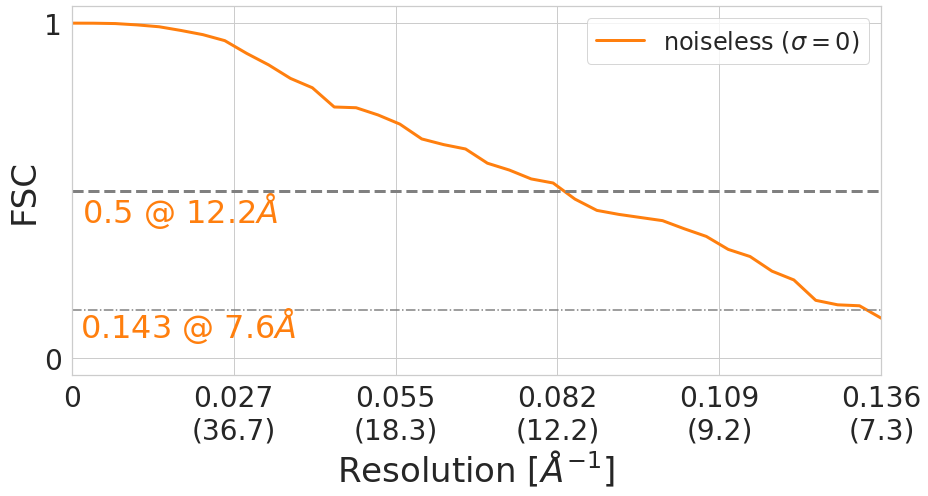

In [77]:
from xml.dom import minidom

# parse an xml file by name
mydoc = minidom.parse(f'{DATA_DIR}/5j0n_fullcvg_noise0_FSC_apr_init.xml')

X = mydoc.getElementsByTagName('x')
Y = mydoc.getElementsByTagName('y')

x = list(map(lambda i: float(i.firstChild.data), X))
y = list(map(lambda i: float(i.firstChild.data), Y))


fig, ax1 = plt.subplots(figsize=(13, 7))

c1 = "gray"#u'#ff7f0e'
c2 = "gray"#u'#2ca02c'

ax1.plot(x, y, c=color1, label="noiseless ($\sigma=0$)", lw=3) 
ax1.set_xlabel(r"Resolution [$\AA^{-1}$]", fontsize=label_size)
ax1.set_ylabel("FSC", fontsize=label_size)
ax1.plot(x, np.ones(len(x))*0.5, ls="--", lw=3,color=c1)
ax1.plot(x, np.ones(len(x))*0.143, ls="-.", color=c2)

ax1.set_ylim(-0.05,1.05);ax1.set_xlim(0,max(x))

# TODO:
ticks = np.linspace(0, max(x), 6)
labels = list(map(lambda x: f"{x:.3f}\n({1/x:.1f})" if x!=0 else "0", ticks))

ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(steps=[1]))
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
plt.xticks(ticks, labels)  # Set text labels and properties.

# TODO:
ax1.text(0, 0.5, r" 0.5 @ 12.2$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color1)
ax1.text(0.01, 0.19, r"0.143 @ 7.6$\AA$", transform=ax1.transAxes, fontweight='medium', fontsize=textbox_size, verticalalignment='top', c=color1)

plt.tight_layout()
plt.legend(fontsize=legend_size)
plt.savefig("pdfs/5j0n_fullcvg_noise0_FSC_apr_init_customFSC.pdf")
